In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import loadmat
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.model_selection import cross_val_score
from sklearn.gaussian_process.kernels import RBF, Matern
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import seaborn as sns
import os
import math
from ruamel.yaml import YAML
from ruamel.yaml.scalarstring import LiteralScalarString
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score
from sklearn.model_selection import StratifiedKFold

# Usefull functions

### General functions

In [168]:
def fix_mat(data):
    if data.dtype.names:
        new_data = dict()
        for name in data.dtype.names:
            new_data[name]=data[0][name][0]
        for k,v in new_data.items():
            if v.dtype.names:
                new_data[k] = fix_mat(v)
            else:
                new_data[k] = np.squeeze(v)
        return new_data
    else:
        return data
    
def print_cm(cm, title, tick_labels):
    cm = np.array(cm)
    cm = cm / cm.sum(axis=1)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=tick_labels)

    disp.plot()
    plt.show()

def print_cm_rej(model, X, y_true, th_rej, title, ticket_label):
    cm = [[0, 0], [0, 0]]
    y_probs = model.predict_proba(X)
    count_integrated = 0
    
    for idx_p in range(len(y_probs)):
        if y_true[idx_p] == 730 and y_probs[idx_p,0] > th_rej[0]:
            cm[0][0] += 1 
            count_integrated = count_integrated + 1
        elif y_true[idx_p] == 730 and y_probs[idx_p, 1] > th_rej[0]:
            cm[0][1] += 1
            count_integrated = count_integrated + 1
        elif y_true[idx_p] == 731 and y_probs[idx_p, 1] > th_rej[1]:
            cm[1][1] += 1
            count_integrated = count_integrated + 1
        elif y_true[idx_p] == 731 and y_probs[idx_p, 0] > th_rej[1]:
            cm[1][0] += 1
            count_integrated = count_integrated + 1
    
    # print accuracy
    print('Accuracy:', np.trace(cm)/np.sum(cm))
    print('Accuracy 730:', cm[0][0]/(cm[0][0]+cm[0][1]))
    print('Accuracy 731:', cm[1][1]/(cm[1][0]+cm[1][1]))
    print('Integrated: ', count_integrated, ' percentual: ', count_integrated/len(y_probs), '%')   
    print_cm(cm, title, ticket_label)
    
def accuracy_online(prob, hit, miss, timeout, target, ths):
        
    i1 = np.where(prob[:,0] > ths[0])[0]
    if len(i1) == 0:
        i1 = len(prob[:,0]) + 1
    else:
        i1 = i1[0]
    i2 = np.where(prob[:,1] > ths[1])[0]
    if len(i2) == 0:
        i2 = len(prob[:,1]) + 1
    else:
        i2 = i2[0]
        
        
    
    if (target == 730 and i1 < i2) or (target == 731 and i1 > i2):
        hit += 1
    elif (target == 730 and i1 > i2) or (target == 731 and i1 < i2):
        miss += 1
    elif i1 == i2:
        timeout += 1
        
    return hit, miss, timeout
    
def histo_prediction(X, model, bins_step, classes):
    probs = model.predict_proba(X)
    bins = np.arange(0, 1.0+bins_step, bins_step)
    figure = plt.figure(figsize=(5, 3))
    plt.hist(probs[:,0], bins=bins)
    # Add title and labels
    plt.xticks(np.arange(0, 1.1, 0.1))
    plt.title('Probability Distribution of class ' + classes[0])
    plt.xlabel('Probability')
    plt.ylabel('Frequency')

    # Show the plot
    plt.show()
    
    
def stratified_kfold(y, n_splits=5, shuffle=True, random_state=None):
    y = np.array(y)
    unique_classes = np.unique(y)
    rng = np.random.default_rng(random_state)
    
    # Hold fold indices
    folds = [[] for _ in range(n_splits)]

    for cls in unique_classes:
        cls_indices = np.where(y == cls)[0]
        if shuffle:
            rng.shuffle(cls_indices)
        
        # Split into k roughly equal parts
        cls_folds = np.array_split(cls_indices, n_splits)
        
        for i in range(n_splits):
            folds[i].extend(cls_folds[i])

    # Yield train and test indices
    for i in range(n_splits):
        test_idx = np.array(folds[i])
        train_idx = np.array([idx for j in range(n_splits) if j != i for idx in folds[j]])
        yield train_idx, test_idx
    
def save_qda(subject, day, model_qda, chosen_qda, type_qda):
    print('saving qda: ' + str(chosen_qda+1))
    path = '/home/paolo/cvsa_ws/record/' + subject + '/' + day + '/calibration/two_classifier/dataset/' + type_qda + '/' + type_qda + '_data' + str(chosen_qda+1) +'.mat' 
    data = loadmat(path)
    info = fix_mat(data['info'])
    
    features_label = []
    if type(info['chSelected'].tolist()) == int:
        features_label.append(str(info['channelsLabel'][info['chSelected'].tolist() - 1][0]))
    else:
        for i in range(0, len(info['chSelected'].tolist())):
            features_label.append(str(info['channelsLabel'][info['chSelected'][i] - 1][0]))
    
    files = []
    for i in range(0, len(info['files'])):
        str_file = info['files'][i][0]
        files.append(str(str_file))
            
    band = info['bandSelected'].tolist()
    id_ch = info['chSelected'].tolist()
    
    model_params = {
        'QdaCfg': {
            'name': "qda",
            'params': {
                'subject': subject,
                'filename': 'qda',
                'filename_dataset': path,
                'files': files,
                'type_data': 'logband',
                'nclasses': int(len(model_qda.classes_)),
                'classlbs': model_qda.classes_.tolist(),
                'nfeatures': int(model_qda.n_features_in_),
                'chans': features_label,
                'idchans': id_ch, 
                'note': 'idchans are saved in matlab convention, instead the names are correct',
                'sampleRate': int(info['sampleRate']),
                'band': band,
                'filterOrder': int(info['filterOrder']),
                'priors': model_qda.priors_.tolist(),
                'means': model_qda.means_.tolist(),
                'covs': [arr.tolist() for arr in model_qda.covariance_],
                'rotations': [arr.tolist() for arr in model_qda.rotations_],
                'scalings': [arr.tolist() for arr in model_qda.scalings_]
            }
        }
    }
    
    # Save parameters to a YAML file
    c_dir = os.getcwd()
    c_prev = os.path.abspath(os.path.join(c_dir, os.pardir))
    path2save = c_prev[0:20] + 'record/' + subject + '/' + day + '/calibration/two_classifier/classifier/' + type_qda + '/cl_best_' + type_qda + '.yaml'
    
    yaml = YAML()
    with open(path2save, 'w') as file:
        yaml.dump(model_params, file)
            
    print(path2save)

## Create QDA

In [76]:
#subject = 'monitor/h7'
subject = 'c7'
day = '20250217'
max_dataset = 27
classes = [730, 731]
nqda = 27
nfold = 10
seeds = [0, 1, 42, 123, 777]

In [170]:
# function to compute seed and other staff
# considering the seed, so use a custom function to divide the trials in training and testing of the k-folds
def select_best_qda_seed(subject, day, nqda, seeds, classes, type_qda, nfold):
    nseed = len(seeds)
    auc_scores_test = np.zeros((nqda, nseed))
    model_matrix = [[None for _ in range(nseed)] for _ in range(nqda)]
    
    param_grid = {'reg_param': [0.0, 0.01, 0.1, 0.05], 'priors': [[0.5, 0.5]]}
    le = LabelEncoder()
    le.classes_ = np.array(classes)

    print('Start computing QDA')
    for idx_qda in range(1, nqda+1):
        # load the data
        path = '/home/paolo/cvsa_ws/record/' + subject + '/' + day + '/calibration/two_classifier/dataset/' + type_qda + '/' + type_qda + '_data' + str(idx_qda) +'.mat' 
        data = loadmat(path)
        info = fix_mat(data['info'])
        typ = info['typ']
        ntest = info['nTest']
        typ_train = typ[0:len(typ)-ntest]
        start_trials = info['startTrial'] - 1
        start_trials = np.append(start_trials, fix_mat(data['X']).shape[0]) 
        
        train_idx = range(0, len(typ)-ntest)
        X_train = np.empty((0, idx_qda))
        y_train = np.empty((0, 1))
        for i in range(0, len(train_idx)):
            c_start = start_trials[train_idx[i]]
            c_end = start_trials[train_idx[i] + 1] # not -1 since it is excluded in the slicing
            X_train = np.vstack([X_train,fix_mat(data['X'])[c_start:c_end,:]]) 
            y_train = np.vstack([y_train,fix_mat(data['y'])[c_start:c_end,:]])

        # encode the labels to have 0 as 730 and 1 as 731
        y_train_enc = le.transform(y_train.ravel())
        
            
        for idx_seed in range(0,nseed):
            c_seed = seeds[idx_seed]
            cv_splitter = StratifiedTrialCV(typ_train, start_trials, n_splits=nfold, shuffle=True, random_state=c_seed)

            grid_search = GridSearchCV(estimator=QuadraticDiscriminantAnalysis(store_covariance=True), scoring='roc_auc', param_grid=param_grid, cv=cv_splitter, n_jobs=-1).fit(X_train, y_train_enc)

            model_qda = grid_search.best_estimator_

            model_matrix[idx_qda-1][idx_seed] = model_qda
            auc_scores_test[idx_qda-1, idx_seed] = grid_search.best_score_

    best_qda_idx, best_seed_idx = np.unravel_index(np.argmax(auc_scores_test), auc_scores_test.shape)    
    best_model = model_matrix[best_qda_idx][best_seed_idx]
    print('Best QDA: ', best_qda_idx, ' with n features: ', best_qda_idx + 1, ' with seed: ', seeds[best_seed_idx], ' with auc: ', auc_scores_test[best_qda_idx][best_seed_idx])
    path = '/home/paolo/cvsa_ws/record/' + subject + '/' + day + '/calibration/two_classifier/dataset/' + type_qda + '/' + type_qda + '_data' + str(best_qda_idx+1) +'.mat' 
    data = loadmat(path)
    info = fix_mat(data['info'])
    typ = info['typ']
    ntest = info['nTest']
    typ_train = typ[0:len(typ)-ntest]
    start_trials = info['startTrial'] - 1
    start_trials = np.append(start_trials, fix_mat(data['X']).shape[0]) 
    X_test = np.empty((0, best_qda_idx+1))
    y_test = np.empty((0, 1))
    test_idx = range(len(typ)-ntest, len(typ))
    for i in range(0, len(test_idx)):
        c_start = start_trials[test_idx[i]]
        c_end = start_trials[test_idx[i] + 1] # not -1 since it is excluded in the slicing
        X_test = np.vstack([X_test,fix_mat(data['X'])[c_start:c_end,:]])
        y_test = np.vstack([y_test,fix_mat(data['y'])[c_start:c_end,:]])
    y_test_enc = le.transform(y_test.ravel())
    y_prob = best_model.predict_proba(X_test)
    print('test auc: ', roc_auc_score(y_test_enc, y_prob[:,1]))
    
    return auc_scores_test, best_model, best_qda_idx
  
class StratifiedTrialCV:
    def __init__(self, typ, start_trials, n_splits=5, shuffle=True, random_state=None):
        self.typ = np.asarray(typ)
        self.start_trials = np.asarray(start_trials)
        self.n_splits = n_splits
        self.shuffle = shuffle
        self.random_state = random_state

    def split(self, X=None, y=None, groups=None):
        n_trials = len(self.typ)
        trial_indices = np.arange(n_trials)

        for train_trial_idx, test_trial_idx in stratified_kfold(typ_train, n_splits=self.n_splits, shuffle=self.shuffle, random_state=self.random_state):
            
            train_sample_idx = []
            test_sample_idx = []
            for idx in train_trial_idx:
                start = self.start_trials[idx]
                end = self.start_trials[idx + 1] 
                train_sample_idx.extend(range(start, end))

            for idx in test_trial_idx:
                start = self.start_trials[idx]
                end = self.start_trials[idx + 1] 
                test_sample_idx.extend(range(start, end))

            yield np.array(train_sample_idx), np.array(test_sample_idx)

    def get_n_splits(self, X=None, y=None, groups=None):
        return self.n_splits
  

# Shift

### With seed

In [ ]:
auc_scores_test, best_model, chosen_qda = select_best_qda_seed(subject, day, nqda, seeds, classes, 'shift', fold)
save_qda(subject, day, best_model, chosen_qda, 'shift')

### Tonin Vote rules

In [112]:
# shift
auc_scores_test, best_model, chosen_qda = select_best_qda_vote(subject, day, nqda, nfold, classes, 'shift')
save_qda(subject, day, best_model, chosen_qda, 'shift')


def voting(auc_scores_test):
    chosen_qda = np.argmax(np.mean(auc_scores_test, axis=1))
    print('chose qda: ', chosen_qda + 1)

    return chosen_qda

# this mode is without the seed
def select_best_qda_vote(subject, day, nqda, nfold, classes, type_qda):
    auc_scores_test = np.zeros((nqda, nfold))
    model_matrix = [[None for _ in range(nfold)] for _ in range(nqda)]
    
    param_grid = {'reg_param': [0.0, 0.01, 0.1, 0.05], 'priors': [[0.5, 0.5]]}
    le = LabelEncoder()
    le.classes_ = np.array(classes)

    # take a dataset to have initial values for the variables for the fold creation
    path = '/home/paolo/cvsa_ws/record/' + subject + '/' + day + '/calibration/two_classifier/dataset/' + type_qda + '/' + type_qda + '_data' + str(1) +'.mat' 
    data = loadmat(path)
    info = fix_mat(data['info'])
    typ = info['typ']
    ntest = info['nTest']
    typ_train = typ[0:len(typ)-ntest]

    print('Start computing QDA')
    for idx_qda in range(1, nqda+1):
        # load the data
        path = '/home/paolo/cvsa_ws/record/' + subject + '/' + day + '/calibration/two_classifier/dataset/' + type_qda + '/' + type_qda + '_data' + str(idx_qda) +'.mat' 
        data = loadmat(path)
        info = fix_mat(data['info'])
        start_trials = info['startTrial'] - 1
        start_trials = np.append(start_trials, fix_mat(data['X']).shape[0]) 
      
        # iterate over the division in train/test
        for idx_fold, (train_idx, test_idx) in enumerate(stratified_kfold(typ_train, n_splits=nfold, shuffle=True, random_state=42)):
            # create the train and the test set
            X_train_cv = np.empty((0, idx_qda))
            y_train_cv = np.empty((0, 1))
            for i in range(0, len(train_idx)):
                c_start = start_trials[train_idx[i]]
                c_end = start_trials[train_idx[i] + 1] # not -1 since it is excluded in the slicing
                X_train_cv = np.vstack([X_train_cv,fix_mat(data['X'])[c_start:c_end,:]])
                y_train_cv = np.vstack([y_train_cv,fix_mat(data['y'])[c_start:c_end,:]])

            X_test_cv = np.empty((0, idx_qda))
            y_test_cv = np.empty((0, 1))
            for i in range(0, len(test_idx)):
                c_start = start_trials[test_idx[i]]
                c_end = start_trials[test_idx[i] + 1] # not -1 since it is excluded in the slicing
                X_test_cv = np.vstack([X_test_cv,fix_mat(data['X'])[c_start:c_end,:]])
                y_test_cv = np.vstack([y_test_cv,fix_mat(data['y'])[c_start:c_end,:]])

            # encode the labels to have 0 as 730 and 1 as 731
            y_train_enc = le.transform(y_train_cv.ravel())
            y_test_enc = le.transform(y_test_cv.ravel())

            # perform the cv with the train to have the best parameters
            grid_search = GridSearchCV(estimator=QuadraticDiscriminantAnalysis(), scoring='roc_auc', param_grid=param_grid, cv=5, n_jobs=-1).fit(X_train_cv, y_train_enc)

            model_qda = grid_search.best_estimator_
            model_matrix[idx_qda-1][idx_fold] = model_qda

            # test the qda with the fold outside and save the auc and accuracy
            y_prob = model_qda.predict_proba(X_test_cv)
            auc = roc_auc_score(y_test_cv, y_prob[:, 1])
            auc_scores_test[idx_qda-1, idx_fold] = auc # since 731 is 1 and 730 is 0 in y_test_enc, so take the correct prob
    
    # vote the best qda
    chosen_qda = voting(auc_scores_test)
    
    #################### train it again on the overall train set
    path = '/home/paolo/cvsa_ws/record/' + subject + '/' + day + '/calibration/two_classifier/dataset/' + type_qda + '/' + type_qda + '_data' + str(chosen_qda+1) +'.mat'   
    start_trials = info['startTrial'] - 1
    data = loadmat(path)
    info = fix_mat(data['info'])
    start_trials = info['startTrial'] - 1
    start_trials = np.append(start_trials, fix_mat(data['X']).shape[0]) 
    train_idx = range(0, len(typ)-ntest)
    test_idx = range(len(typ)-ntest, len(typ))
    X_train = np.empty((0, chosen_qda+1))
    y_train = np.empty((0, 1))
    for i in range(0, len(train_idx)):
        c_start = start_trials[train_idx[i]]
        c_end = start_trials[train_idx[i] + 1] # not -1 since it is excluded in the slicing
        X_train = np.vstack([X_train,fix_mat(data['X'])[c_start:c_end,:]]) # dsa
        y_train = np.vstack([y_train,fix_mat(data['y'])[c_start:c_end,:]])
    #sdsdsda
    X_test = np.empty((0, chosen_qda+1))
    y_test = np.empty((0, 1))
    for i in range(0, len(test_idx)):
        c_start = start_trials[test_idx[i]]
        c_end = start_trials[test_idx[i] + 1] # not -1 since it is excluded in the slicing
        X_test = np.vstack([X_test,fix_mat(data['X'])[c_start:c_end,:]])
        y_test = np.vstack([y_test,fix_mat(data['y'])[c_start:c_end,:]])

    # encode the labels to have 0 as 730 and 1 as 731
    y_train_enc = le.transform(y_train.ravel())
    y_test_enc = le.transform(y_test.ravel())

    # perform the cv with the train to have the best parameters
    grid_search = GridSearchCV(estimator=QuadraticDiscriminantAnalysis(store_covariance=True), scoring='roc_auc', param_grid=param_grid, cv=5, n_jobs=-1).fit(X_train, y_train_enc)
    best_model = grid_search.best_estimator_
    
    y_pred_train = best_model.predict_proba(X_train)
    y_pred_test  = best_model.predict_proba(X_test)
    print('Final AUC train: ', roc_auc_score(y_train_enc, y_pred_train[:, 1]))
    print('Final AUC test: ' , roc_auc_score(y_test_enc, y_pred_test[:, 1]))
    
    return auc_scores_test, best_model, chosen_qda

### One QDA for each dataset

Train set: (17864, 1) (17864,)
Test set: (8932, 1) (8932,)
Best parameters found:  {'priors': None, 'reg_param': 1.0}
Best score found:  0.6179535203838419
Accuracy train: 0.6178907299596955
Accuracy test:  0.6064711150918047
Accuracy all:   0.6140841916703985
Accuracy: 0.6178907299596955
Accuracy 730: 0.8396103896103896
Accuracy 731: 0.3803339517625232
Integrated:  17864  percentual:  1.0 %


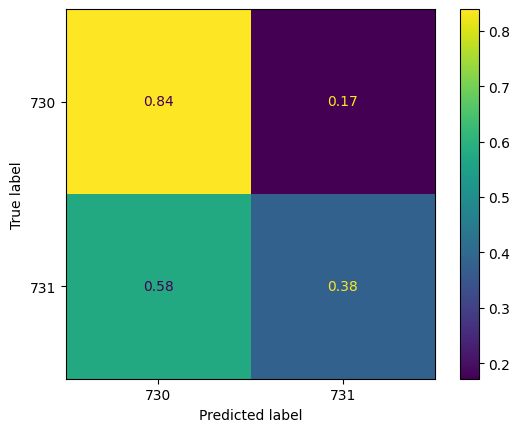

Accuracy: 0.6064711150918047
Accuracy 730: 0.804945054945055
Accuracy 731: 0.445211038961039
Integrated:  8932  percentual:  1.0 %


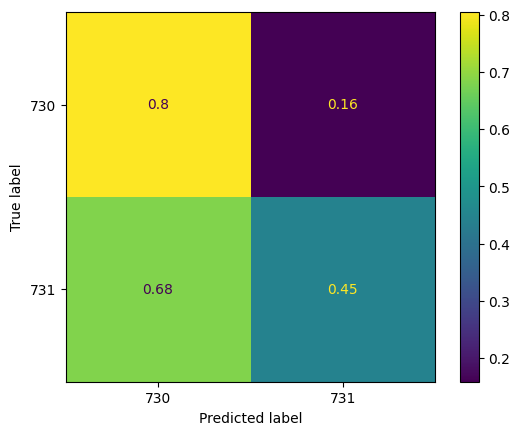

Accuracy: 0.6140841916703985
Accuracy 730: 0.829130172153428
Accuracy 731: 0.40392561983471076
Integrated:  26796  percentual:  1.0 %


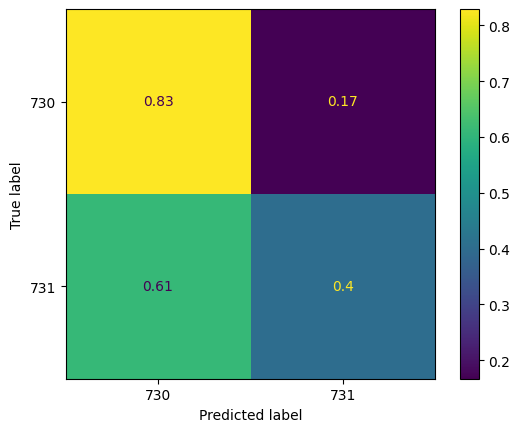

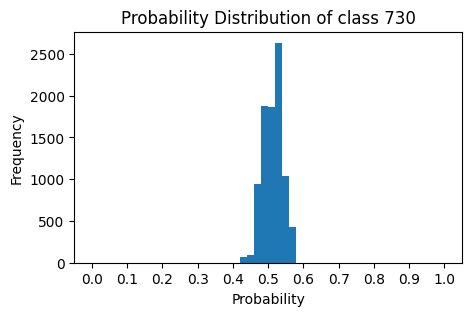

/home/paolo/cvsa_ws/record/monitor/h7/20240923/calibration/two_classifier/classifier/shift/cl_shift1.yaml
Train set: (17864, 2) (17864,)
Test set: (8932, 2) (8932,)
Best parameters found:  {'priors': None, 'reg_param': 1.0}
Best score found:  0.6292038490746042
Accuracy train: 0.6257277205553068
Accuracy test:  0.603448275862069
Accuracy all:   0.6183012389908942
Accuracy: 0.6257277205553068
Accuracy 730: 0.7667748917748918
Accuracy 731: 0.47460575139146566
Integrated:  17864  percentual:  1.0 %


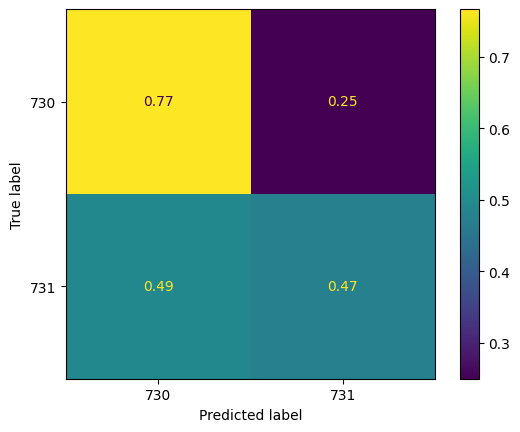

Accuracy: 0.603448275862069
Accuracy 730: 0.7147852147852148
Accuracy 731: 0.512987012987013
Integrated:  8932  percentual:  1.0 %


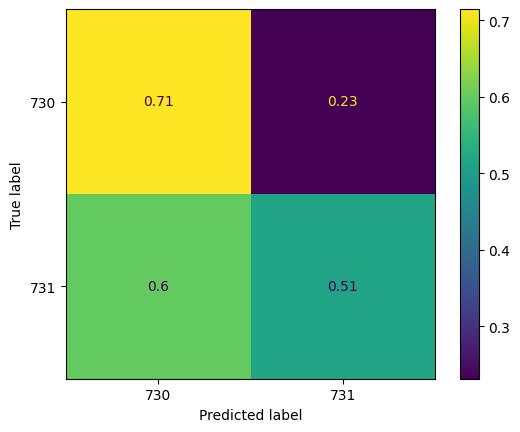

Accuracy: 0.6183012389908942
Accuracy 730: 0.7510570824524313
Accuracy 731: 0.4885625737898465
Integrated:  26796  percentual:  1.0 %


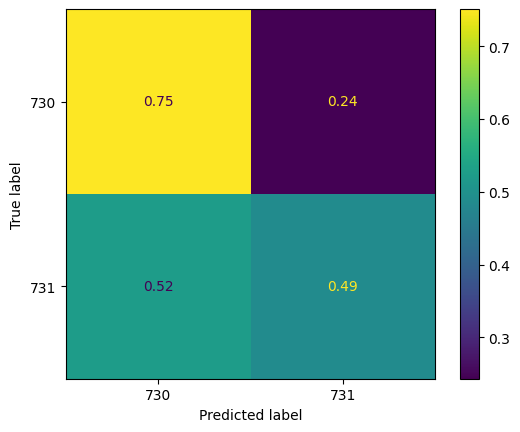

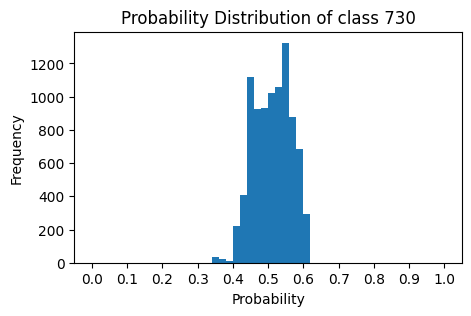

/home/paolo/cvsa_ws/record/monitor/h7/20240923/calibration/two_classifier/classifier/shift/cl_shift2.yaml
Train set: (17864, 3) (17864,)
Test set: (8932, 3) (8932,)
Best parameters found:  {'priors': None, 'reg_param': 1.0}
Best score found:  0.6191850725658312
Accuracy train: 0.6196260635915808
Accuracy test:  0.579153605015674
Accuracy all:   0.6061352440662785
Accuracy: 0.6196260635915808
Accuracy 730: 0.7351731601731601
Accuracy 731: 0.4958256029684601
Integrated:  17864  percentual:  1.0 %


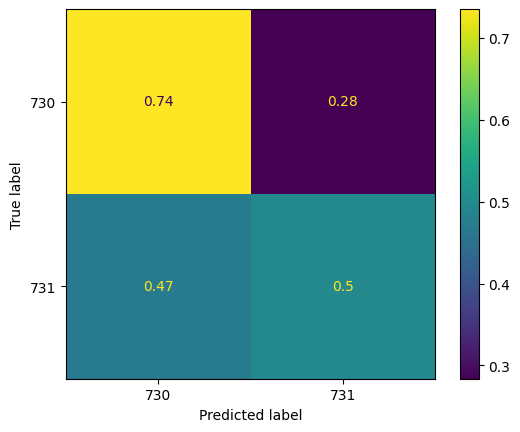

Accuracy: 0.579153605015674
Accuracy 730: 0.6488511488511488
Accuracy 731: 0.5225243506493507
Integrated:  8932  percentual:  1.0 %


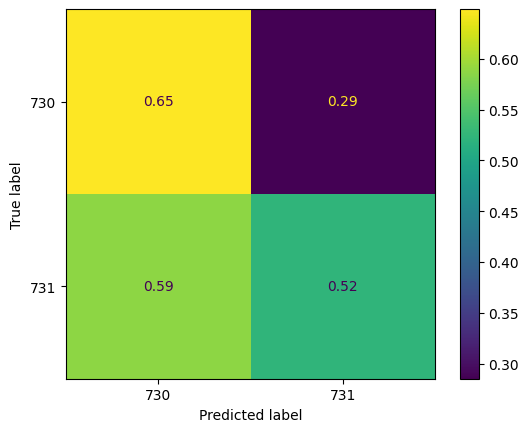

Accuracy: 0.6061352440662785
Accuracy 730: 0.7090758079130172
Accuracy 731: 0.505534238488784
Integrated:  26796  percentual:  1.0 %


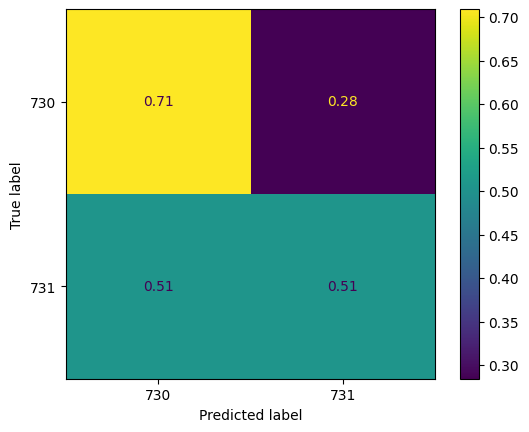

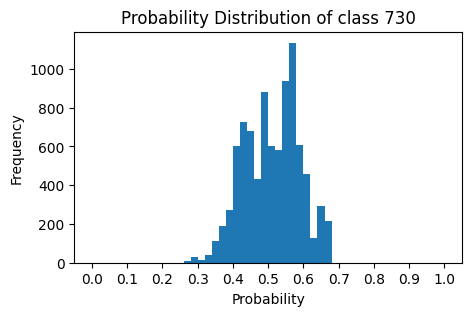

/home/paolo/cvsa_ws/record/monitor/h7/20240923/calibration/two_classifier/classifier/shift/cl_shift3.yaml
Train set: (17864, 4) (17864,)
Test set: (8932, 4) (8932,)
Best parameters found:  {'priors': None, 'reg_param': 1.0}
Best score found:  0.6084910970639884
Accuracy train: 0.609549932825795
Accuracy test:  0.5705329153605015
Accuracy all:   0.5965442603373637
Accuracy: 0.609549932825795
Accuracy 730: 0.6987012987012987
Accuracy 731: 0.514030612244898
Integrated:  17864  percentual:  1.0 %


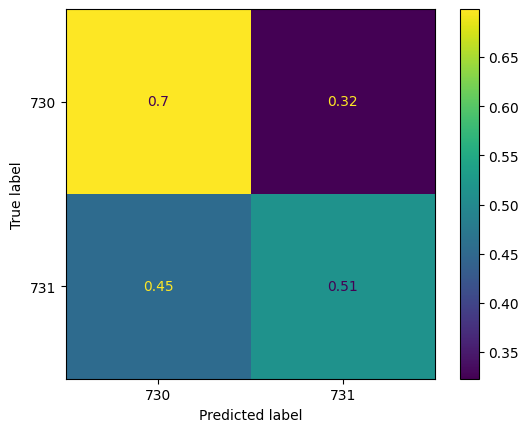

Accuracy: 0.5705329153605015
Accuracy 730: 0.6043956043956044
Accuracy 731: 0.5430194805194806
Integrated:  8932  percentual:  1.0 %


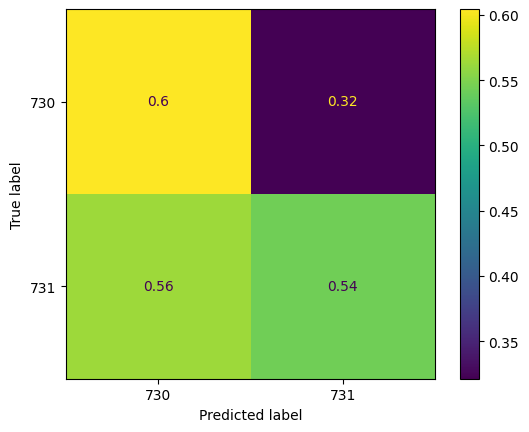

Accuracy: 0.5965442603373637
Accuracy 730: 0.6701902748414377
Accuracy 731: 0.5245720188902007
Integrated:  26796  percentual:  1.0 %


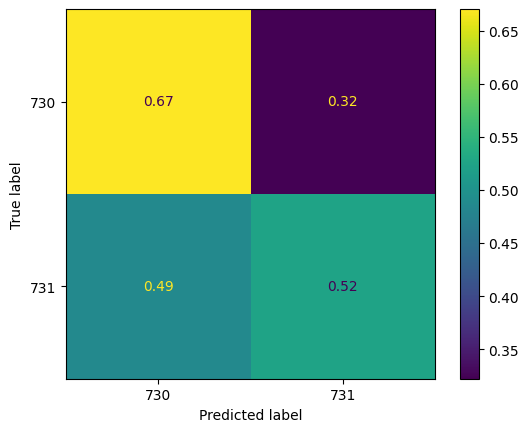

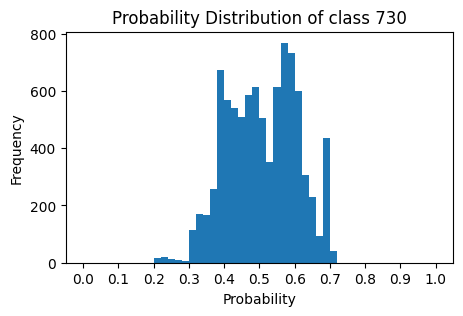

/home/paolo/cvsa_ws/record/monitor/h7/20240923/calibration/two_classifier/classifier/shift/cl_shift4.yaml
Train set: (17864, 5) (17864,)
Test set: (8932, 5) (8932,)
Best parameters found:  {'priors': None, 'reg_param': 1.0}
Best score found:  0.6050760353014661
Accuracy train: 0.606974921630094
Accuracy test:  0.5682937751903269
Accuracy all:   0.5940812061501717
Accuracy: 0.606974921630094
Accuracy 730: 0.6924242424242424
Accuracy 731: 0.515422077922078
Integrated:  17864  percentual:  1.0 %


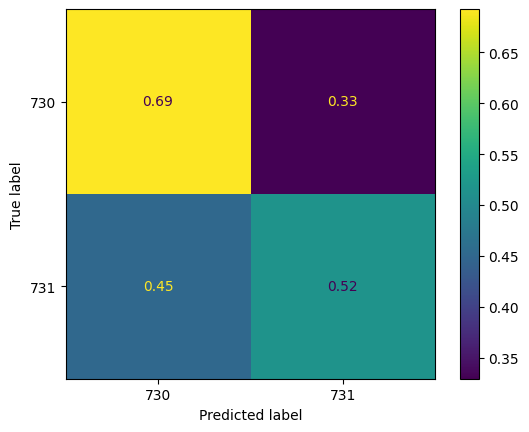

Accuracy: 0.5682937751903269
Accuracy 730: 0.5979020979020979
Accuracy 731: 0.544237012987013
Integrated:  8932  percentual:  1.0 %


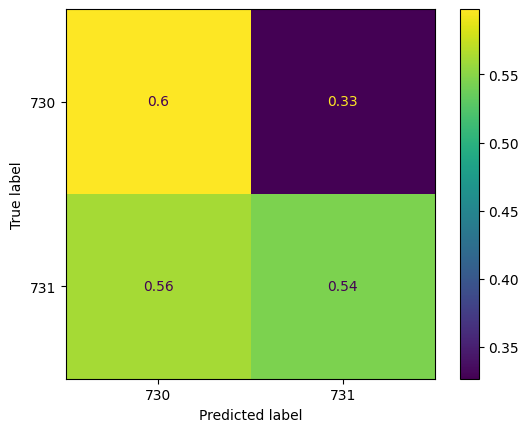

Accuracy: 0.5940812061501717
Accuracy 730: 0.6638477801268499
Accuracy 731: 0.5259002361275088
Integrated:  26796  percentual:  1.0 %


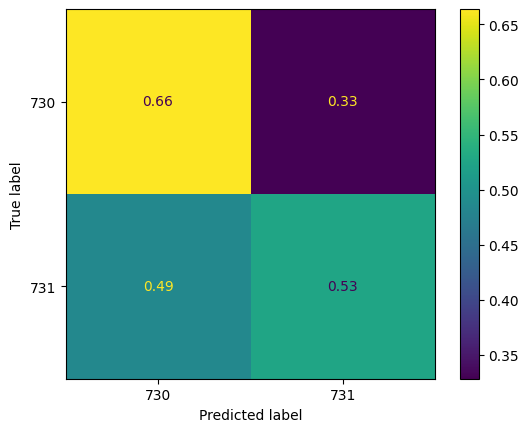

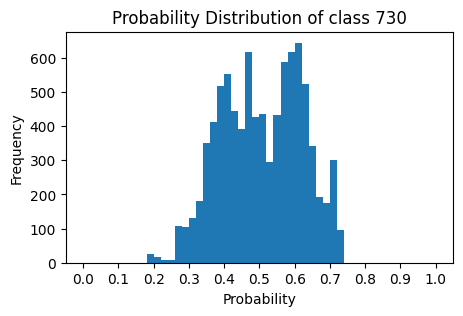

/home/paolo/cvsa_ws/record/monitor/h7/20240923/calibration/two_classifier/classifier/shift/cl_shift5.yaml
Train set: (17864, 6) (17864,)
Test set: (8932, 6) (8932,)
Best parameters found:  {'priors': None, 'reg_param': 1.0}
Best score found:  0.6079867075731918
Accuracy train: 0.6075906851768921
Accuracy test:  0.5640394088669951
Accuracy all:   0.5930735930735931
Accuracy: 0.6075906851768921
Accuracy 730: 0.6865800865800866
Accuracy 731: 0.5229591836734694
Integrated:  17864  percentual:  1.0 %


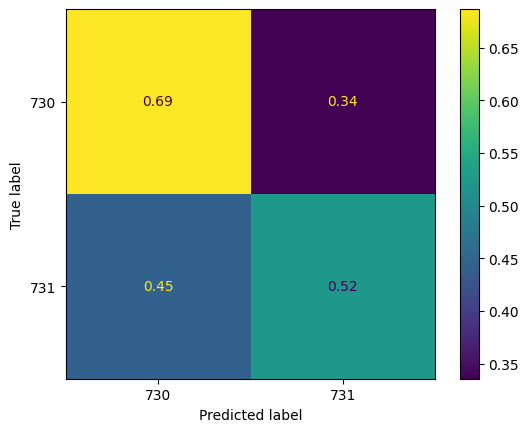

Accuracy: 0.5640394088669951
Accuracy 730: 0.5694305694305695
Accuracy 731: 0.5596590909090909
Integrated:  8932  percentual:  1.0 %


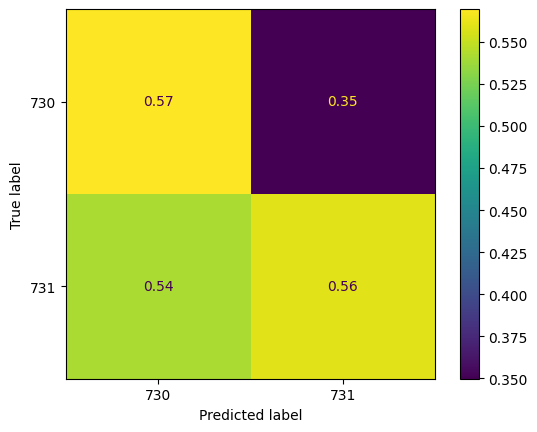

Accuracy: 0.5930735930735931
Accuracy 730: 0.6511627906976745
Accuracy 731: 0.5363046044864227
Integrated:  26796  percentual:  1.0 %


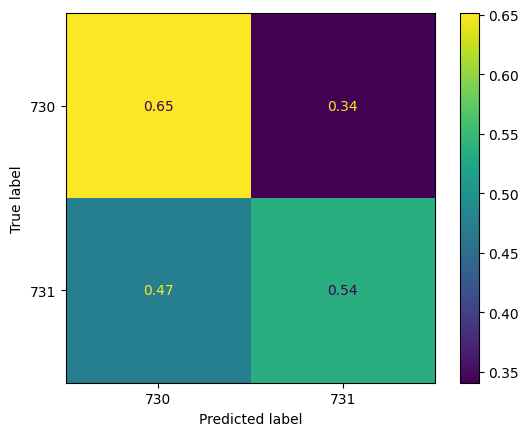

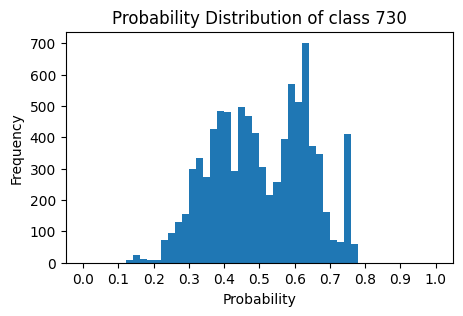

/home/paolo/cvsa_ws/record/monitor/h7/20240923/calibration/two_classifier/classifier/shift/cl_shift6.yaml
Train set: (17864, 7) (17864,)
Test set: (8932, 7) (8932,)
Best parameters found:  {'priors': None, 'reg_param': 1.0}
Best score found:  0.6105060066963592
Accuracy train: 0.6109493954321541
Accuracy test:  0.5575459023734886
Accuracy all:   0.5931482310792655
Accuracy: 0.6109493954321541
Accuracy 730: 0.6916666666666667
Accuracy 731: 0.5244666048237476
Integrated:  17864  percentual:  1.0 %


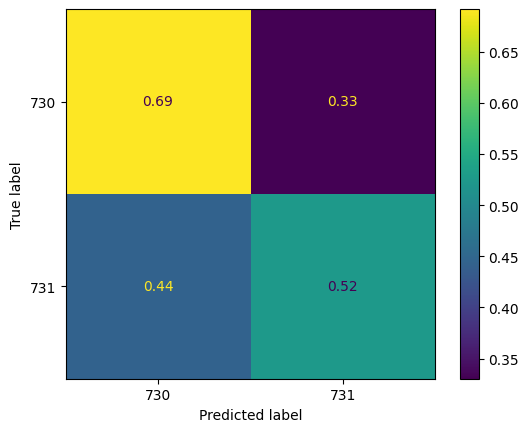

Accuracy: 0.5575459023734886
Accuracy 730: 0.5674325674325674
Accuracy 731: 0.549512987012987
Integrated:  8932  percentual:  1.0 %


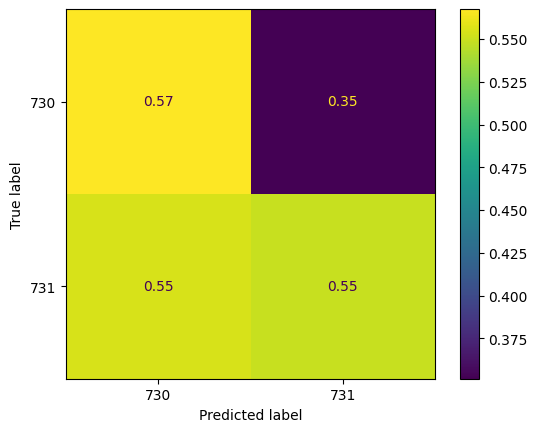

Accuracy: 0.5931482310792655
Accuracy 730: 0.6541075203865901
Accuracy 731: 0.5335743801652892
Integrated:  26796  percentual:  1.0 %


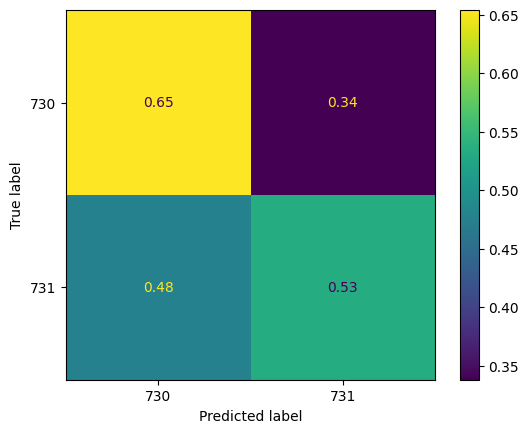

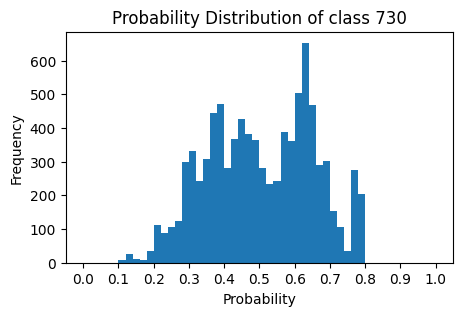

/home/paolo/cvsa_ws/record/monitor/h7/20240923/calibration/two_classifier/classifier/shift/cl_shift7.yaml
Train set: (17864, 8) (17864,)
Test set: (8932, 8) (8932,)
Best parameters found:  {'priors': [0.5, 0.5], 'reg_param': 1.0}
Best score found:  0.6094975411266971
Accuracy train: 0.6134124496193462
Accuracy test:  0.5489252127183162
Accuracy all:   0.5919167039856695
Accuracy: 0.6134124496193462
Accuracy 730: 0.668073593073593
Accuracy 731: 0.5548469387755102
Integrated:  17864  percentual:  1.0 %


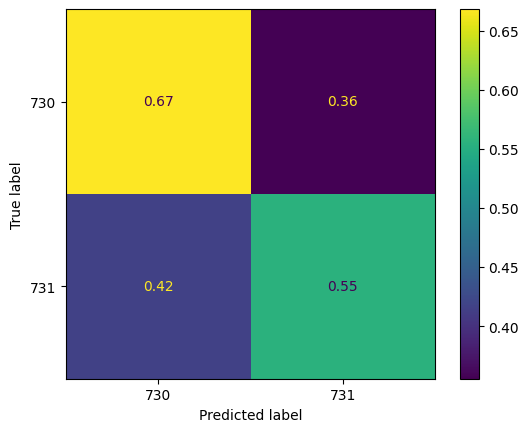

Accuracy: 0.5489252127183162
Accuracy 730: 0.5282217782217782
Accuracy 731: 0.5657467532467533
Integrated:  8932  percentual:  1.0 %


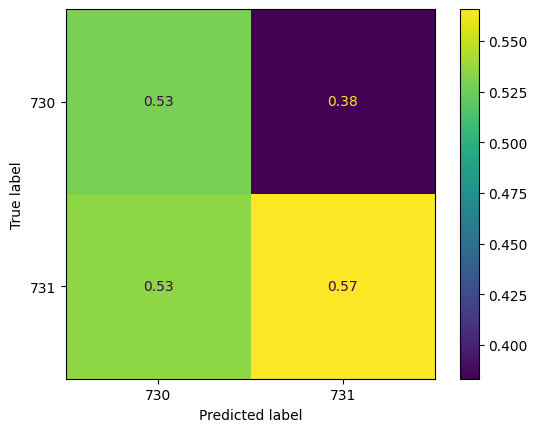

Accuracy: 0.5919167039856695
Accuracy 730: 0.6257928118393234
Accuracy 731: 0.5588105076741441
Integrated:  26796  percentual:  1.0 %


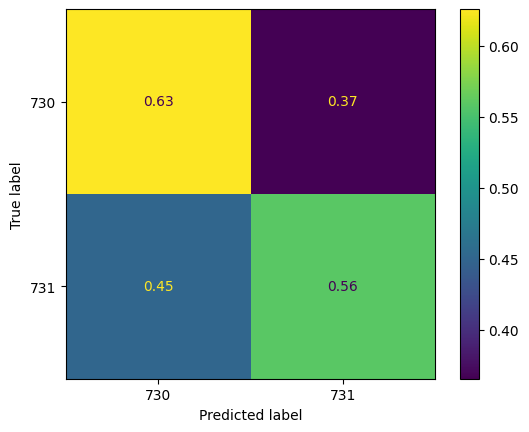

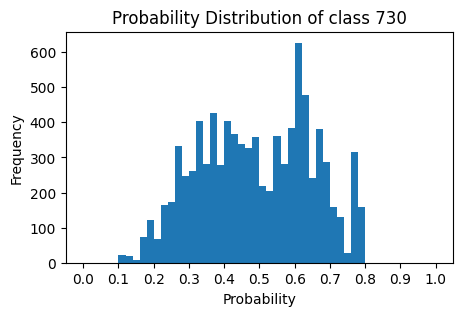

/home/paolo/cvsa_ws/record/monitor/h7/20240923/calibration/two_classifier/classifier/shift/cl_shift8.yaml
Train set: (17864, 9) (17864,)
Test set: (8932, 9) (8932,)
Best parameters found:  {'priors': [0.5, 0.5], 'reg_param': 1.0}
Best score found:  0.6116253574071306
Accuracy train: 0.6106135244066279
Accuracy test:  0.5461262875055979
Accuracy all:   0.5891177787729512
Accuracy: 0.6106135244066279
Accuracy 730: 0.6666666666666666
Accuracy 731: 0.550556586270872
Integrated:  17864  percentual:  1.0 %


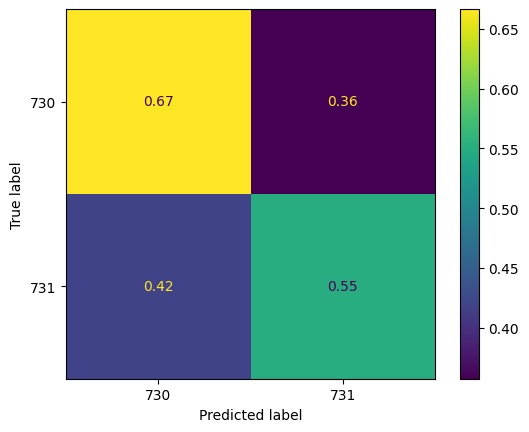

Accuracy: 0.5461262875055979
Accuracy 730: 0.5197302697302697
Accuracy 731: 0.567573051948052
Integrated:  8932  percentual:  1.0 %


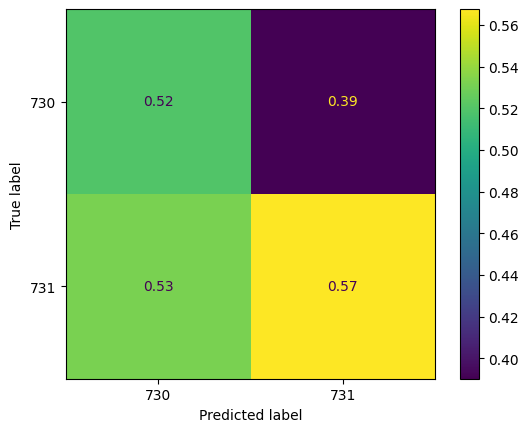

Accuracy: 0.5891177787729512
Accuracy 730: 0.6222440350347327
Accuracy 731: 0.5567443919716647
Integrated:  26796  percentual:  1.0 %


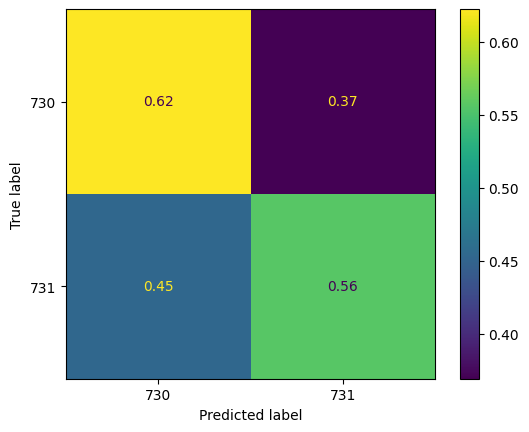

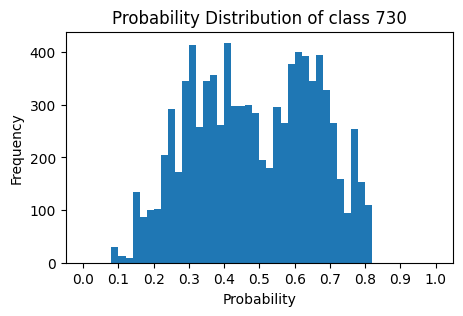

/home/paolo/cvsa_ws/record/monitor/h7/20240923/calibration/two_classifier/classifier/shift/cl_shift9.yaml
Train set: (17864, 10) (17864,)
Test set: (8932, 10) (8932,)
Best parameters found:  {'priors': [0.5, 0.5], 'reg_param': 1.0}
Best score found:  0.6149847728813432
Accuracy train: 0.6197380206000895
Accuracy test:  0.5437751903269145
Accuracy all:   0.5944170771756979
Accuracy: 0.6197380206000895
Accuracy 730: 0.6705627705627706
Accuracy 731: 0.5652829313543599
Integrated:  17864  percentual:  1.0 %


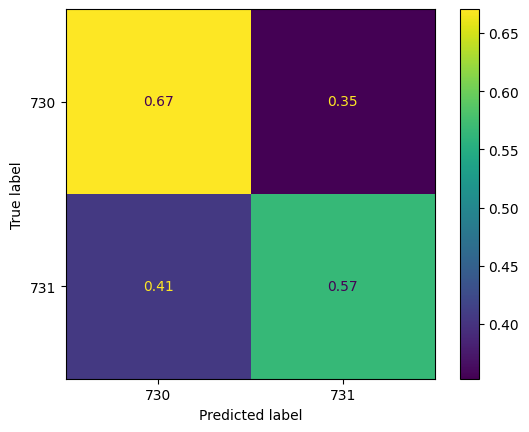

Accuracy: 0.5437751903269145
Accuracy 730: 0.5294705294705294
Accuracy 731: 0.5553977272727273
Integrated:  8932  percentual:  1.0 %


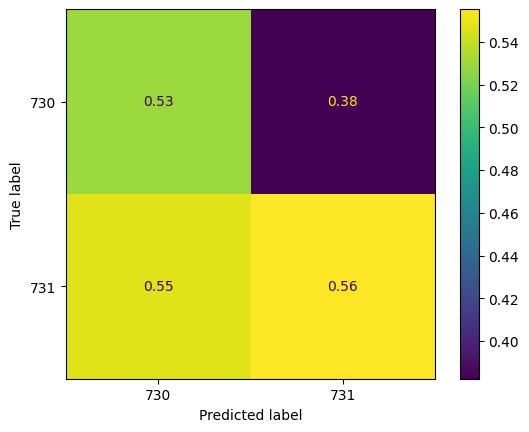

Accuracy: 0.5944170771756979
Accuracy 730: 0.627906976744186
Accuracy 731: 0.5616883116883117
Integrated:  26796  percentual:  1.0 %


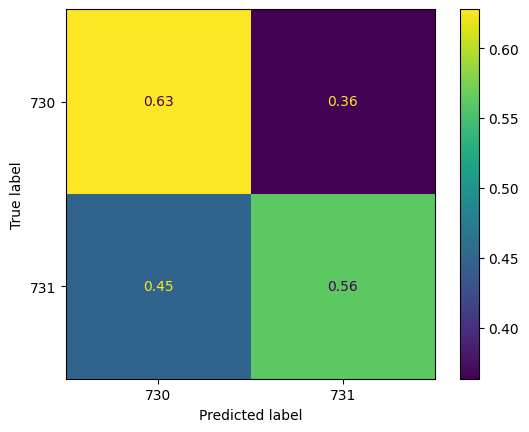

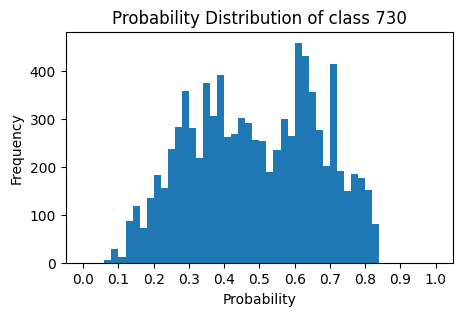

/home/paolo/cvsa_ws/record/monitor/h7/20240923/calibration/two_classifier/classifier/shift/cl_shift10.yaml
Train set: (17864, 11) (17864,)
Test set: (8932, 11) (8932,)
Best parameters found:  {'priors': None, 'reg_param': 1.0}
Best score found:  0.6276366953971384
Accuracy train: 0.635691894312584
Accuracy test:  0.5556426332288401
Accuracy all:   0.6090088072846693
Accuracy: 0.635691894312584
Accuracy 730: 0.7132034632034632
Accuracy 731: 0.5526437847866419
Integrated:  17864  percentual:  1.0 %


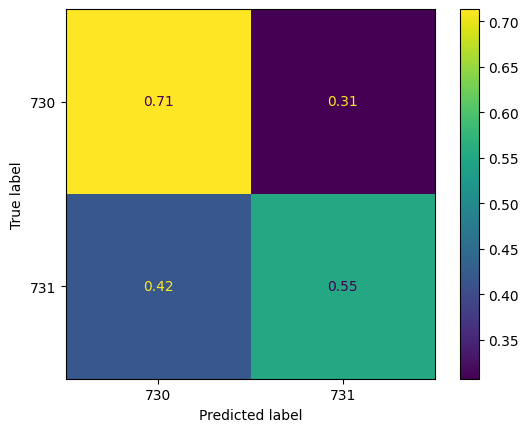

Accuracy: 0.5556426332288401
Accuracy 730: 0.5936563436563437
Accuracy 731: 0.5247564935064936
Integrated:  8932  percentual:  1.0 %


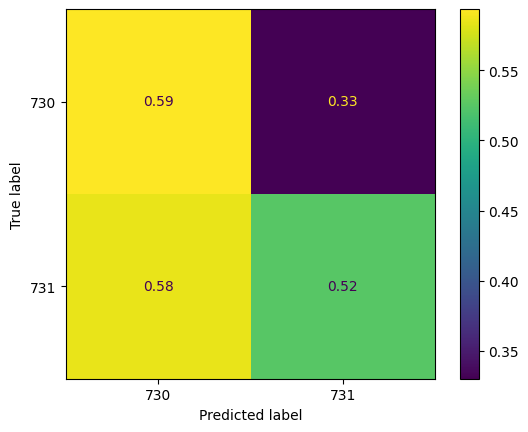

Accuracy: 0.6090088072846693
Accuracy 730: 0.677061310782241
Accuracy 731: 0.5425029515938606
Integrated:  26796  percentual:  1.0 %


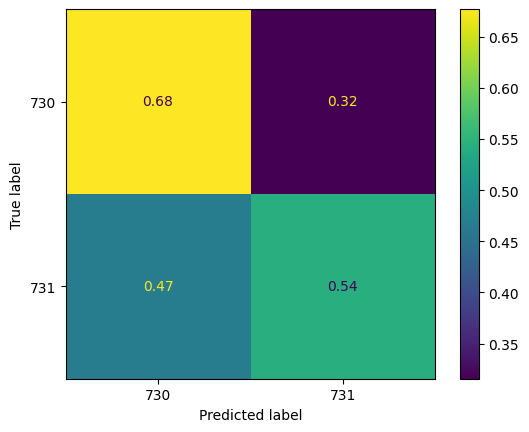

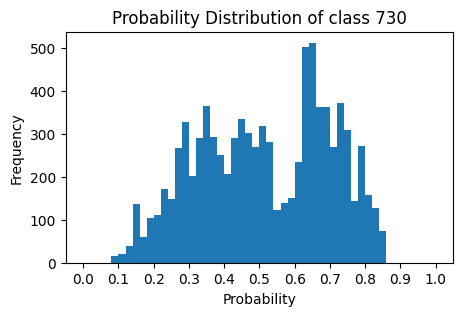

/home/paolo/cvsa_ws/record/monitor/h7/20240923/calibration/two_classifier/classifier/shift/cl_shift11.yaml
Train set: (17864, 12) (17864,)
Test set: (8932, 12) (8932,)
Best parameters found:  {'priors': None, 'reg_param': 1.0}
Best score found:  0.6243901552297952
Accuracy train: 0.6344603672189879
Accuracy test:  0.5537393640841917
Accuracy all:   0.6075533661740559
Accuracy: 0.6344603672189879
Accuracy 730: 0.711038961038961
Accuracy 731: 0.5524118738404453
Integrated:  17864  percentual:  1.0 %


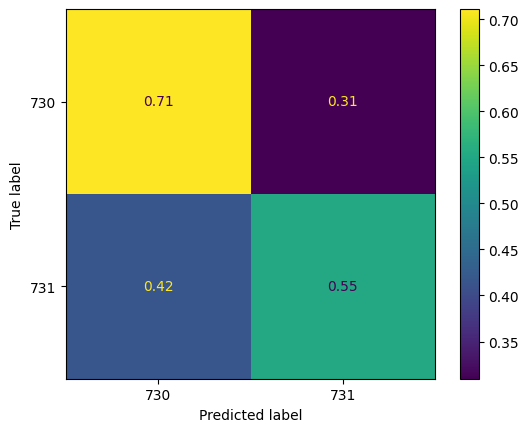

Accuracy: 0.5537393640841917
Accuracy 730: 0.5821678321678322
Accuracy 731: 0.5306412337662337
Integrated:  8932  percentual:  1.0 %


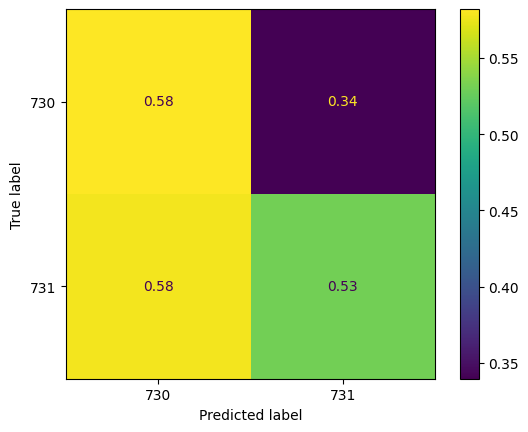

Accuracy: 0.6075533661740559
Accuracy 730: 0.672077922077922
Accuracy 731: 0.544495277449823
Integrated:  26796  percentual:  1.0 %


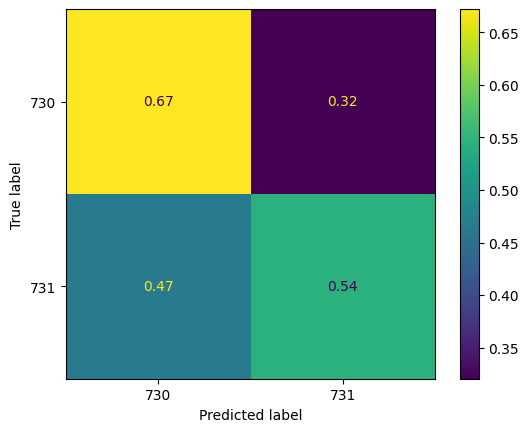

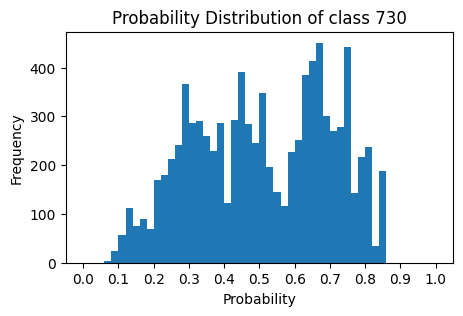

/home/paolo/cvsa_ws/record/monitor/h7/20240923/calibration/two_classifier/classifier/shift/cl_shift12.yaml
Train set: (17864, 13) (17864,)
Test set: (8932, 13) (8932,)
Best parameters found:  {'priors': None, 'reg_param': 1.0}
Best score found:  0.6195746435957876
Accuracy train: 0.6315494849977609
Accuracy test:  0.5460143304970891
Accuracy all:   0.6030377668308703
Accuracy: 0.6315494849977609
Accuracy 730: 0.7100649350649351
Accuracy 731: 0.547425788497217
Integrated:  17864  percentual:  1.0 %


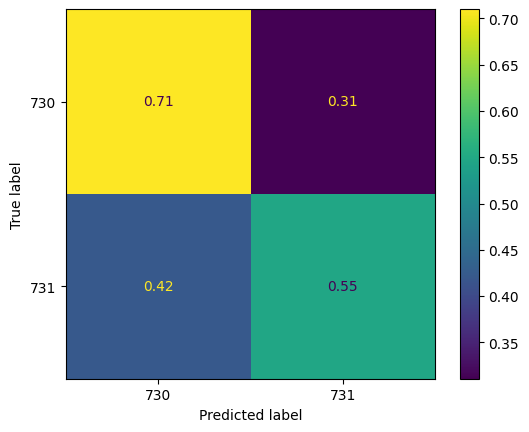

Accuracy: 0.5460143304970891
Accuracy 730: 0.5604395604395604
Accuracy 731: 0.5342938311688312
Integrated:  8932  percentual:  1.0 %


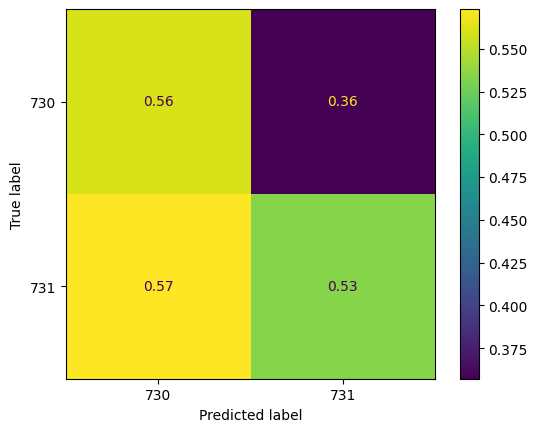

Accuracy: 0.6030377668308703
Accuracy 730: 0.6648293566898218
Accuracy 731: 0.5426505312868949
Integrated:  26796  percentual:  1.0 %


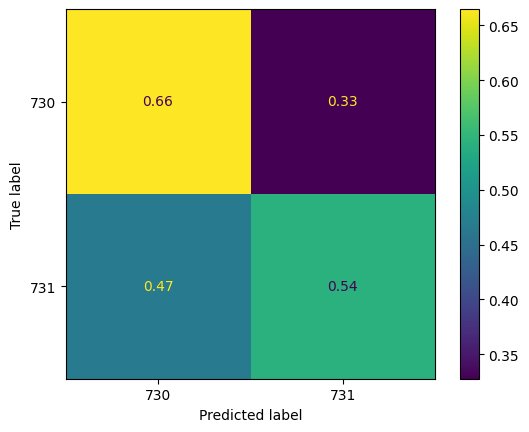

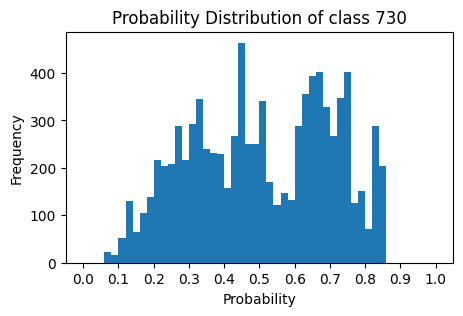

/home/paolo/cvsa_ws/record/monitor/h7/20240923/calibration/two_classifier/classifier/shift/cl_shift13.yaml
Train set: (17864, 14) (17864,)
Test set: (8932, 14) (8932,)
Best parameters found:  {'priors': None, 'reg_param': 1.0}
Best score found:  0.6228771748045642
Accuracy train: 0.6344603672189879
Accuracy test:  0.5460143304970891
Accuracy all:   0.604978354978355
Accuracy: 0.6344603672189879
Accuracy 730: 0.7097402597402598
Accuracy 731: 0.5538033395176253
Integrated:  17864  percentual:  1.0 %


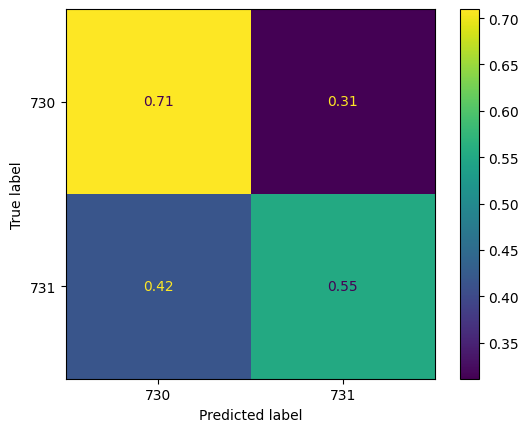

Accuracy: 0.5460143304970891
Accuracy 730: 0.5576923076923077
Accuracy 731: 0.536525974025974
Integrated:  8932  percentual:  1.0 %


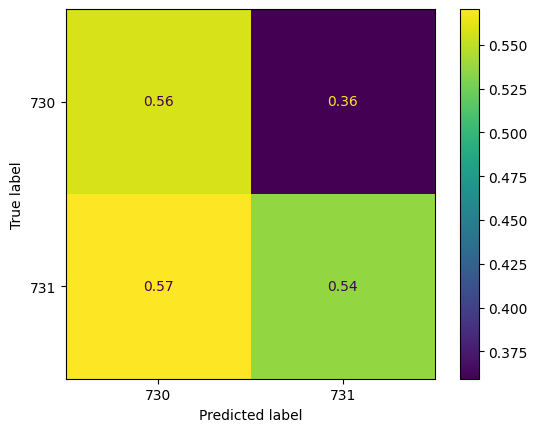

Accuracy: 0.604978354978355
Accuracy 730: 0.6637722742373905
Accuracy 731: 0.5475206611570248
Integrated:  26796  percentual:  1.0 %


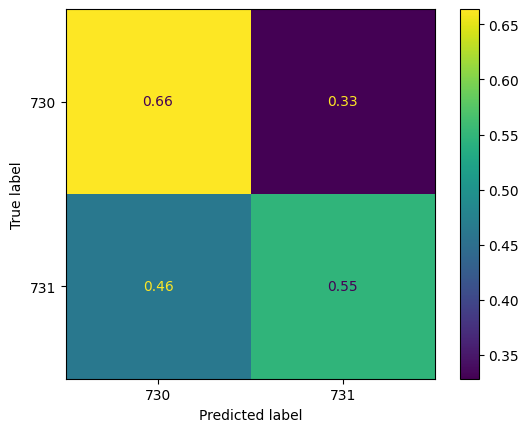

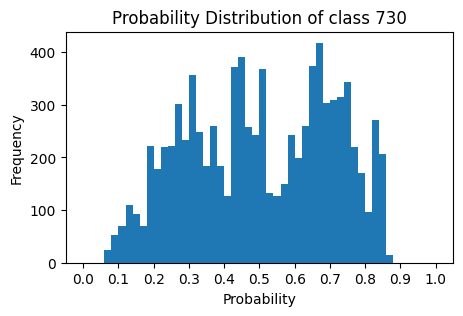

/home/paolo/cvsa_ws/record/monitor/h7/20240923/calibration/two_classifier/classifier/shift/cl_shift14.yaml
Train set: (17864, 15) (17864,)
Test set: (8932, 15) (8932,)
Best parameters found:  {'priors': None, 'reg_param': 1.0}
Best score found:  0.6233810001538853
Accuracy train: 0.6271271831616659
Accuracy test:  0.5420958351992835
Accuracy all:   0.5987834005075384
Accuracy: 0.6271271831616659
Accuracy 730: 0.6977272727272728
Accuracy 731: 0.5514842300556586
Integrated:  17864  percentual:  1.0 %


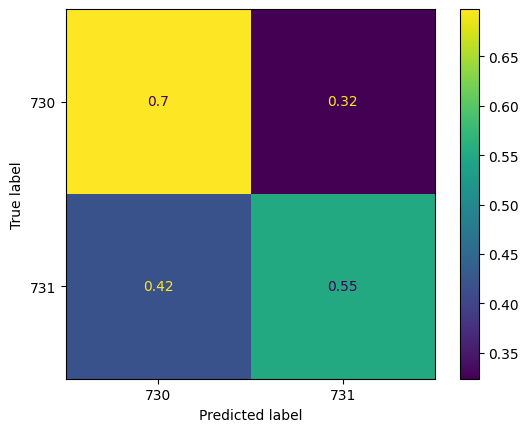

Accuracy: 0.5420958351992835
Accuracy 730: 0.5437062937062938
Accuracy 731: 0.5407873376623377
Integrated:  8932  percentual:  1.0 %


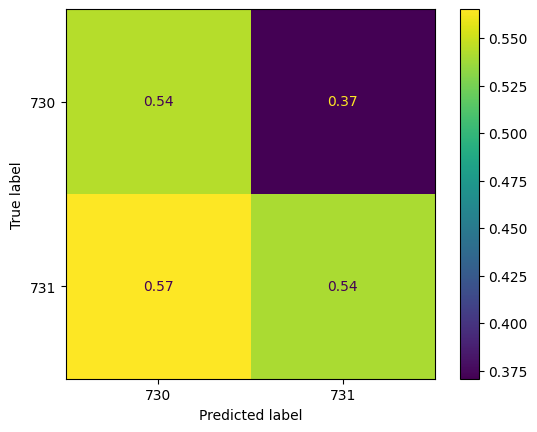

Accuracy: 0.5987834005075384
Accuracy 730: 0.6511627906976745
Accuracy 731: 0.5475944510035419
Integrated:  26796  percentual:  1.0 %


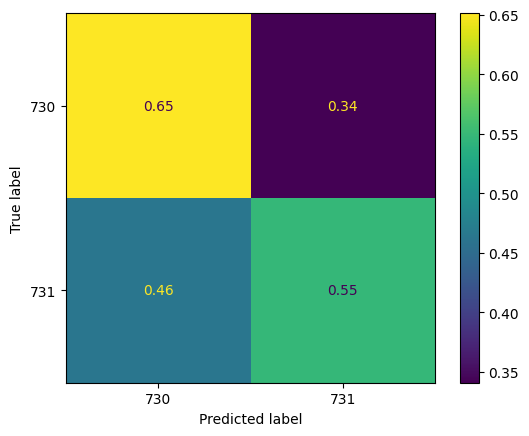

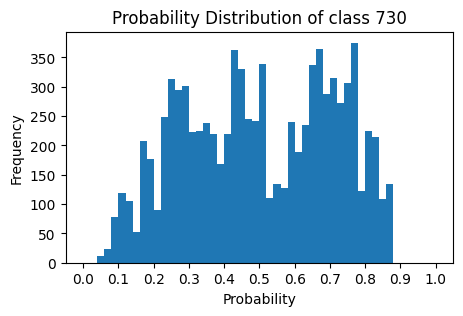

/home/paolo/cvsa_ws/record/monitor/h7/20240923/calibration/two_classifier/classifier/shift/cl_shift15.yaml
Train set: (17864, 16) (17864,)
Test set: (8932, 16) (8932,)
Best parameters found:  {'priors': [0.5, 0.5], 'reg_param': 1.0}
Best score found:  0.6226541665452195
Accuracy train: 0.6313255709807434
Accuracy test:  0.5377295118674429
Accuracy all:   0.6001268846096433
Accuracy: 0.6313255709807434
Accuracy 730: 0.6678571428571428
Accuracy 731: 0.5921846011131725
Integrated:  17864  percentual:  1.0 %


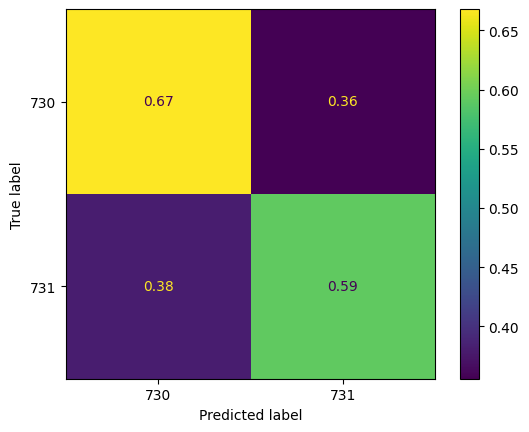

Accuracy: 0.5377295118674429
Accuracy 730: 0.5004995004995005
Accuracy 731: 0.5679788961038961
Integrated:  8932  percentual:  1.0 %


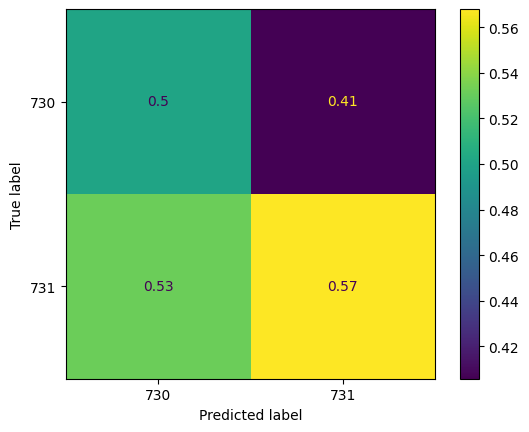

Accuracy: 0.6001268846096433
Accuracy 730: 0.6172606463304138
Accuracy 731: 0.5833825265643447
Integrated:  26796  percentual:  1.0 %


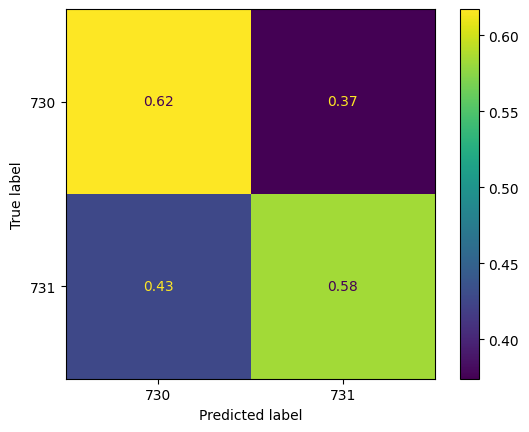

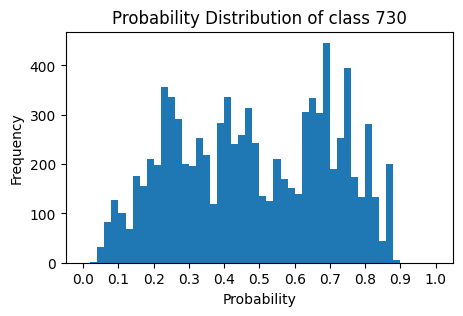

/home/paolo/cvsa_ws/record/monitor/h7/20240923/calibration/two_classifier/classifier/shift/cl_shift16.yaml
Train set: (17864, 17) (17864,)
Test set: (8932, 17) (8932,)
Best parameters found:  {'priors': None, 'reg_param': 1.0}
Best score found:  0.6182861914777655
Accuracy train: 0.6163233318405732
Accuracy test:  0.5400806090461263
Accuracy all:   0.5909090909090909
Accuracy: 0.6163233318405732
Accuracy 730: 0.6807359307359307
Accuracy 731: 0.5473098330241187
Integrated:  17864  percentual:  1.0 %


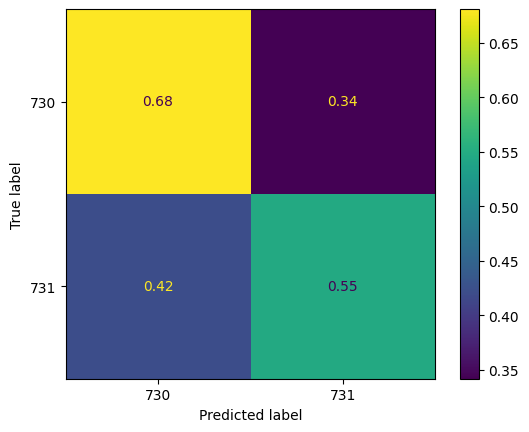

Accuracy: 0.5400806090461263
Accuracy 730: 0.5122377622377622
Accuracy 731: 0.562702922077922
Integrated:  8932  percentual:  1.0 %


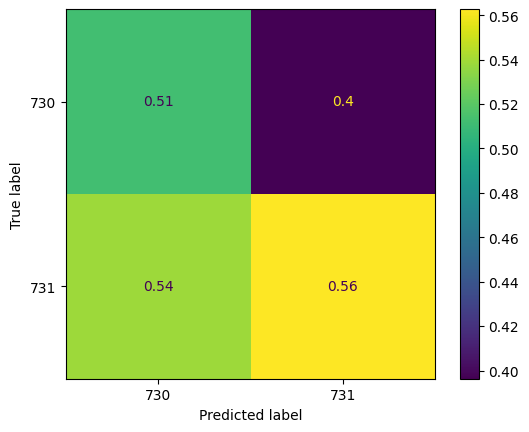

Accuracy: 0.5909090909090909
Accuracy 730: 0.6297946239806705
Accuracy 731: 0.5529073199527745
Integrated:  26796  percentual:  1.0 %


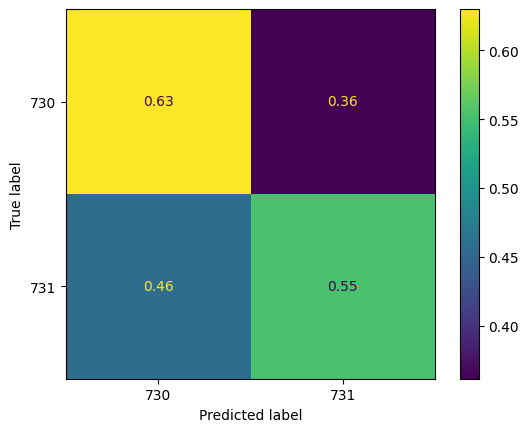

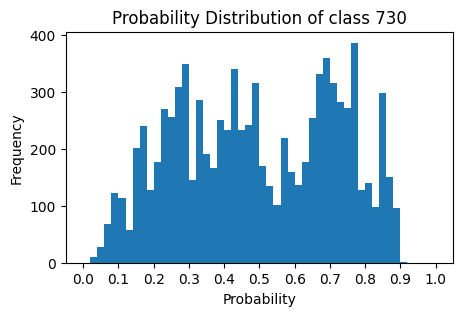

/home/paolo/cvsa_ws/record/monitor/h7/20240923/calibration/two_classifier/classifier/shift/cl_shift17.yaml
Train set: (17864, 18) (17864,)
Test set: (8932, 18) (8932,)
Best parameters found:  {'priors': None, 'reg_param': 1.0}
Best score found:  0.6189581936691416
Accuracy train: 0.617666815942678
Accuracy test:  0.5401925660546351
Accuracy all:   0.591842065979997
Accuracy: 0.617666815942678
Accuracy 730: 0.6806277056277056
Accuracy 731: 0.550208719851577
Integrated:  17864  percentual:  1.0 %


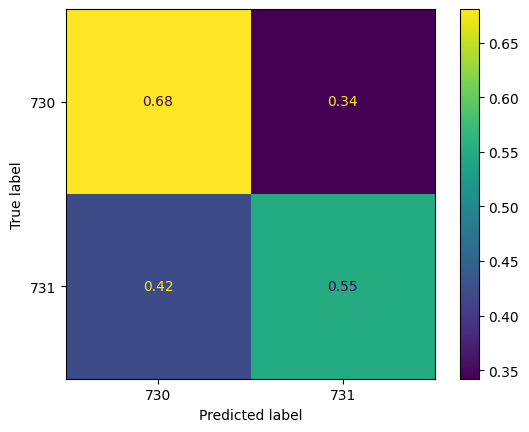

Accuracy: 0.5401925660546351
Accuracy 730: 0.5074925074925075
Accuracy 731: 0.5667613636363636
Integrated:  8932  percentual:  1.0 %


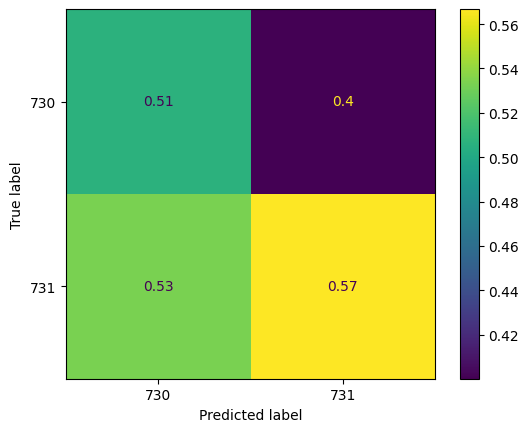

Accuracy: 0.591842065979997
Accuracy 730: 0.6282845061914829
Accuracy 731: 0.5562278630460449
Integrated:  26796  percentual:  1.0 %


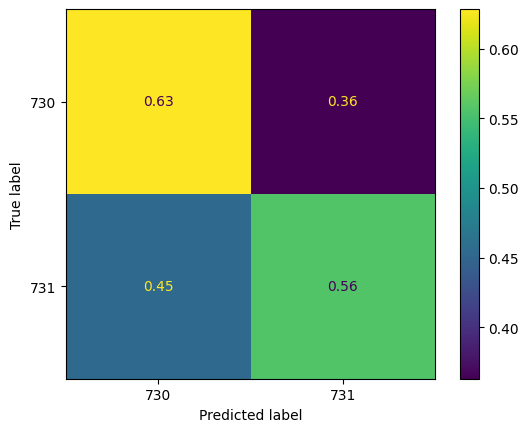

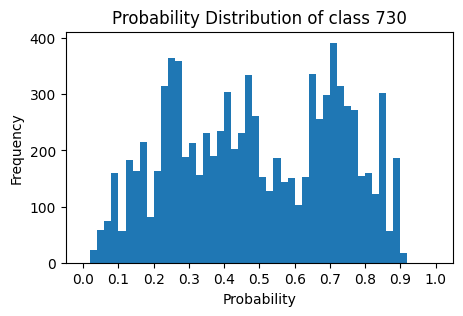

/home/paolo/cvsa_ws/record/monitor/h7/20240923/calibration/two_classifier/classifier/shift/cl_shift18.yaml
Train set: (17864, 19) (17864,)
Test set: (8932, 19) (8932,)
Best parameters found:  {'priors': None, 'reg_param': 1.0}
Best score found:  0.6112897872528473
Accuracy train: 0.6160994178235557
Accuracy test:  0.5398566950291088
Accuracy all:   0.5906851768920734
Accuracy: 0.6160994178235557
Accuracy 730: 0.6779220779220779
Accuracy 731: 0.549860853432282
Integrated:  17864  percentual:  1.0 %


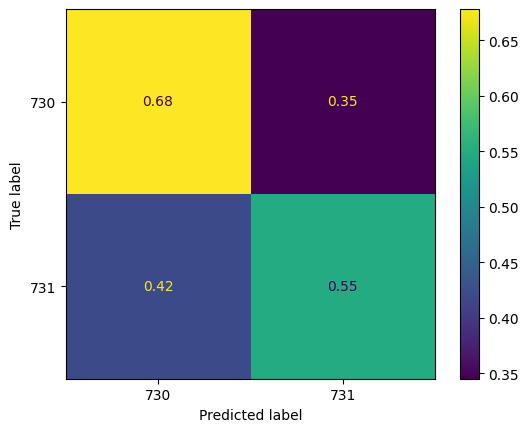

Accuracy: 0.5398566950291088
Accuracy 730: 0.503996003996004
Accuracy 731: 0.5689935064935064
Integrated:  8932  percentual:  1.0 %


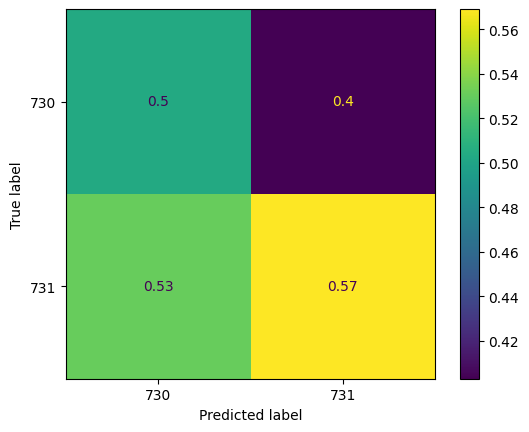

Accuracy: 0.5906851768920734
Accuracy 730: 0.6253397765025672
Accuracy 731: 0.5568181818181818
Integrated:  26796  percentual:  1.0 %


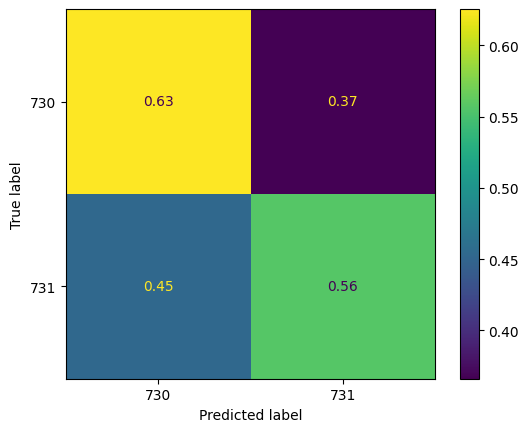

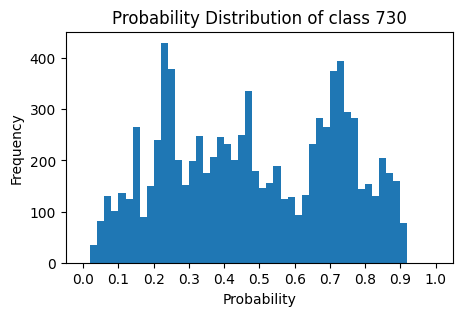

/home/paolo/cvsa_ws/record/monitor/h7/20240923/calibration/two_classifier/classifier/shift/cl_shift19.yaml
Train set: (17864, 20) (17864,)
Test set: (8932, 20) (8932,)
Best parameters found:  {'priors': None, 'reg_param': 1.0}
Best score found:  0.6052443688494866
Accuracy train: 0.6150918047469771
Accuracy test:  0.542319749216301
Accuracy all:   0.5908344529034184
Accuracy: 0.6150918047469771
Accuracy 730: 0.6707792207792208
Accuracy 731: 0.5554267161410018
Integrated:  17864  percentual:  1.0 %


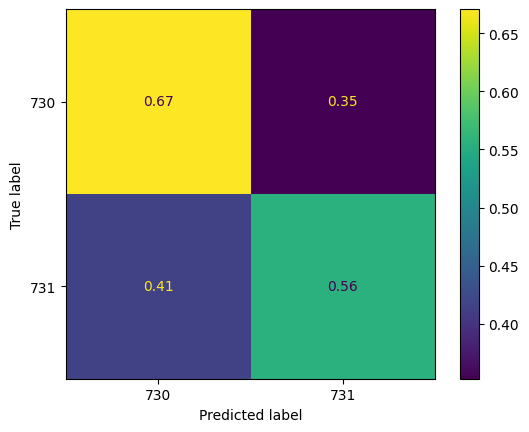

Accuracy: 0.542319749216301
Accuracy 730: 0.5087412587412588
Accuracy 731: 0.5696022727272727
Integrated:  8932  percentual:  1.0 %


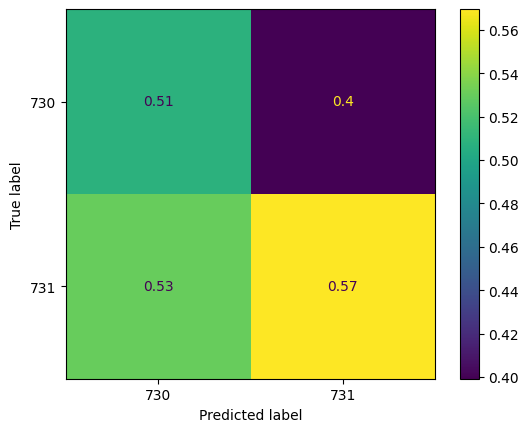

Accuracy: 0.5908344529034184
Accuracy 730: 0.6217909996979765
Accuracy 731: 0.5605814639905549
Integrated:  26796  percentual:  1.0 %


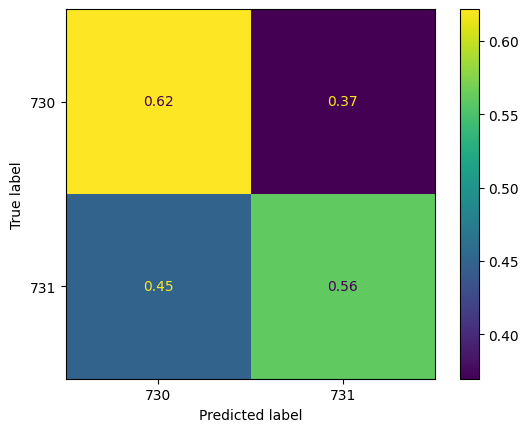

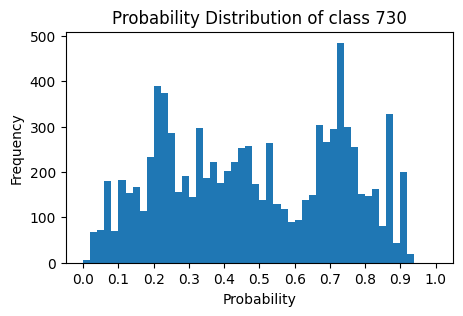

/home/paolo/cvsa_ws/record/monitor/h7/20240923/calibration/two_classifier/classifier/shift/cl_shift20.yaml
Train set: (17864, 21) (17864,)
Test set: (8932, 21) (8932,)
Best parameters found:  {'priors': None, 'reg_param': 1.0}
Best score found:  0.6044609800579123
Accuracy train: 0.6157075682937752
Accuracy test:  0.5444469323779668
Accuracy all:   0.5919540229885057
Accuracy: 0.6157075682937752
Accuracy 730: 0.6688311688311688
Accuracy 731: 0.5587894248608535
Integrated:  17864  percentual:  1.0 %


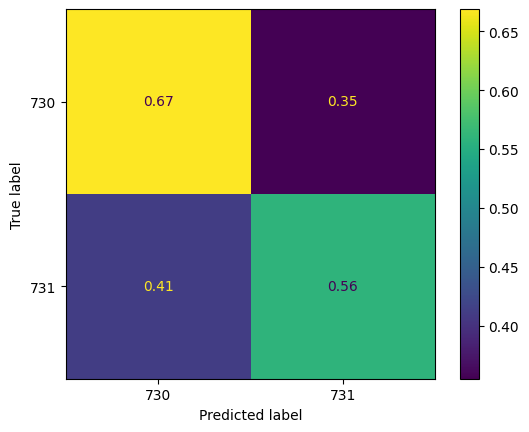

Accuracy: 0.5444469323779668
Accuracy 730: 0.5114885114885115
Accuracy 731: 0.5712256493506493
Integrated:  8932  percentual:  1.0 %


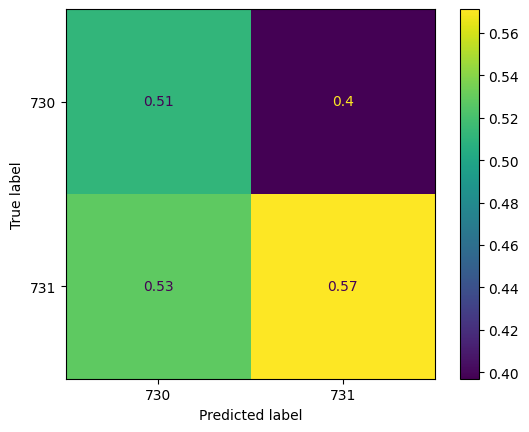

Accuracy: 0.5919540229885057
Accuracy 730: 0.6212624584717608
Accuracy 731: 0.5633116883116883
Integrated:  26796  percentual:  1.0 %


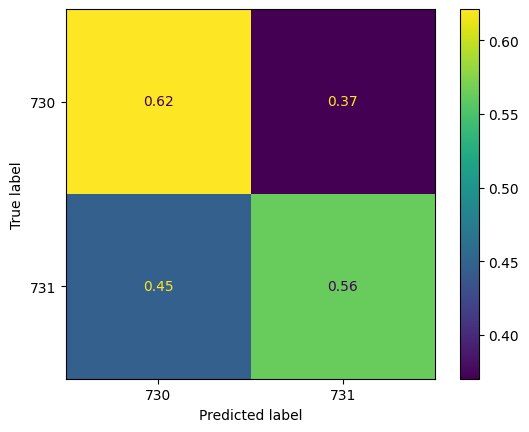

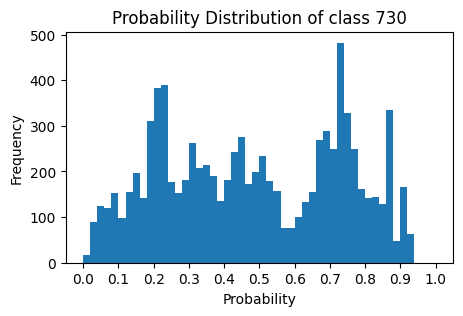

/home/paolo/cvsa_ws/record/monitor/h7/20240923/calibration/two_classifier/classifier/shift/cl_shift21.yaml
Train set: (17864, 22) (17864,)
Test set: (8932, 22) (8932,)
Best parameters found:  {'priors': None, 'reg_param': 1.0}
Best score found:  0.608547824623459
Accuracy train: 0.6191222570532915
Accuracy test:  0.5454545454545454
Accuracy all:   0.5945663531870429
Accuracy: 0.6191222570532915
Accuracy 730: 0.672943722943723
Accuracy 731: 0.561456400742115
Integrated:  17864  percentual:  1.0 %


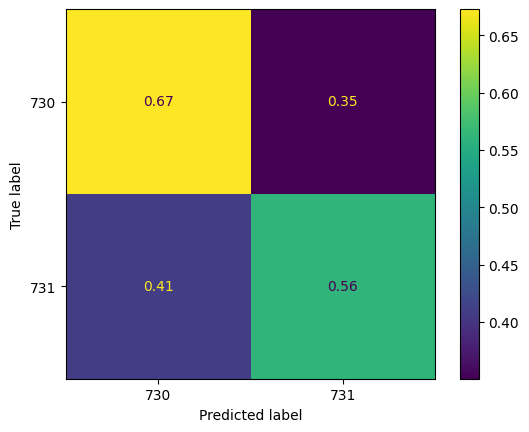

Accuracy: 0.5454545454545454
Accuracy 730: 0.5144855144855145
Accuracy 731: 0.5706168831168831
Integrated:  8932  percentual:  1.0 %


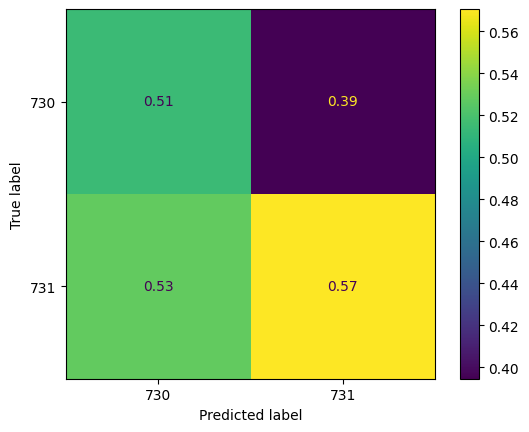

Accuracy: 0.5945663531870429
Accuracy 730: 0.6250377529447297
Accuracy 731: 0.5647874852420307
Integrated:  26796  percentual:  1.0 %


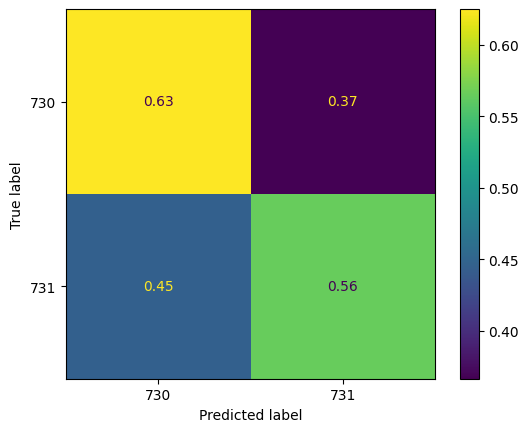

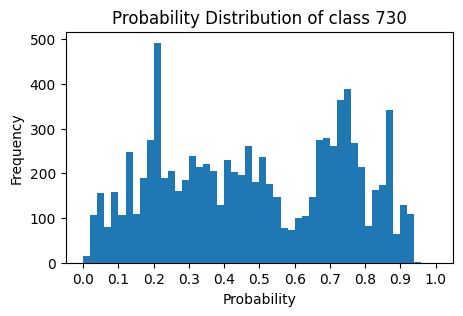

/home/paolo/cvsa_ws/record/monitor/h7/20240923/calibration/two_classifier/classifier/shift/cl_shift22.yaml
Train set: (17864, 23) (17864,)
Test set: (8932, 23) (8932,)
Best parameters found:  {'priors': None, 'reg_param': 1.0}
Best score found:  0.6049096449074165
Accuracy train: 0.6174429019256605
Accuracy test:  0.5448947604120018
Accuracy all:   0.5932601880877743
Accuracy: 0.6174429019256605
Accuracy 730: 0.6628787878787878
Accuracy 731: 0.5687615955473099
Integrated:  17864  percentual:  1.0 %


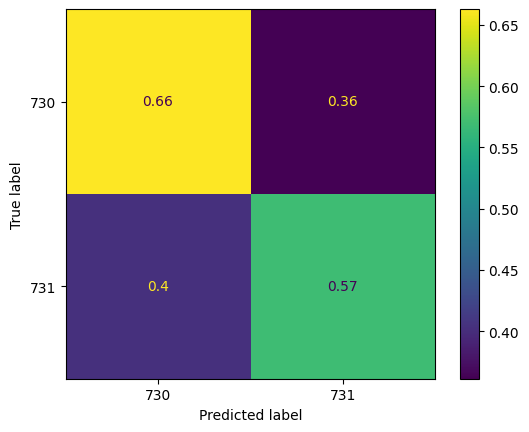

Accuracy: 0.5448947604120018
Accuracy 730: 0.5127372627372627
Accuracy 731: 0.5710227272727273
Integrated:  8932  percentual:  1.0 %


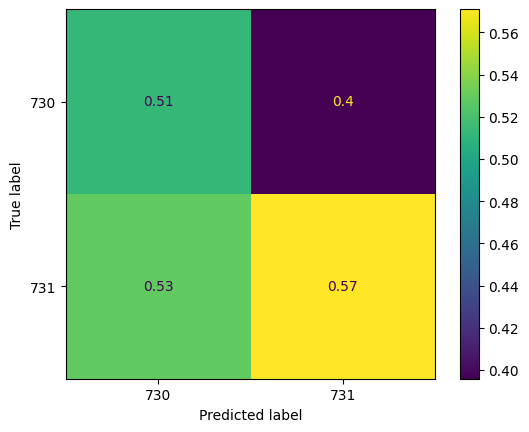

Accuracy: 0.5932601880877743
Accuracy 730: 0.6174871639987919
Accuracy 731: 0.5695838252656434
Integrated:  26796  percentual:  1.0 %


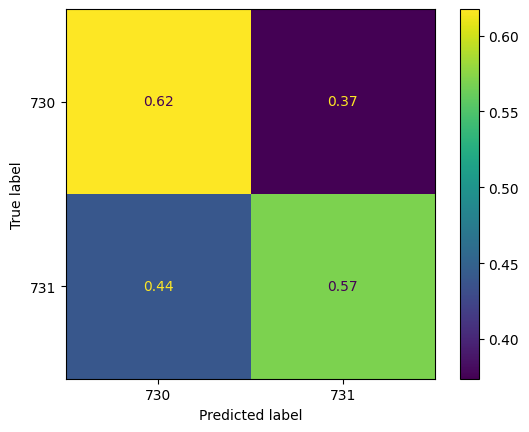

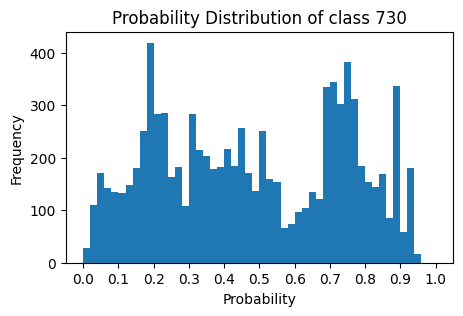

/home/paolo/cvsa_ws/record/monitor/h7/20240923/calibration/two_classifier/classifier/shift/cl_shift23.yaml
Train set: (17864, 24) (17864,)
Test set: (8932, 24) (8932,)
Best parameters found:  {'priors': None, 'reg_param': 1.0}
Best score found:  0.6012149570202548
Accuracy train: 0.609549932825795
Accuracy test:  0.5555306762203314
Accuracy all:   0.5915435139573071
Accuracy: 0.609549932825795
Accuracy 730: 0.6482683982683982
Accuracy 731: 0.5680658627087198
Integrated:  17864  percentual:  1.0 %


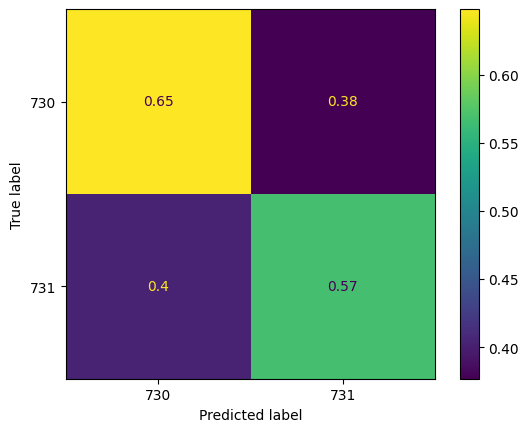

Accuracy: 0.5555306762203314
Accuracy 730: 0.512987012987013
Accuracy 731: 0.5900974025974026
Integrated:  8932  percentual:  1.0 %


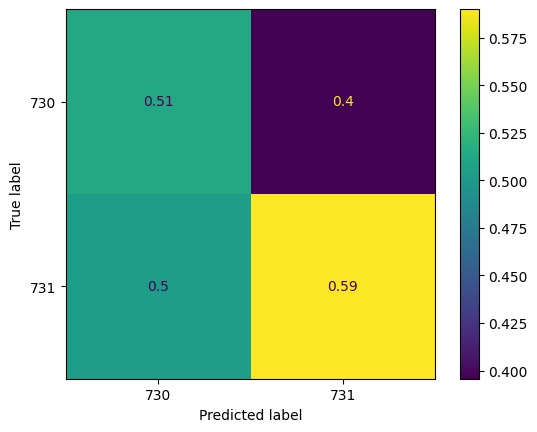

Accuracy: 0.5915435139573071
Accuracy 730: 0.6073693748112353
Accuracy 731: 0.57607733175915
Integrated:  26796  percentual:  1.0 %


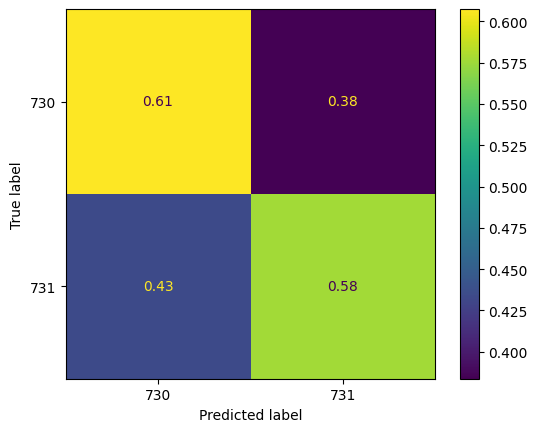

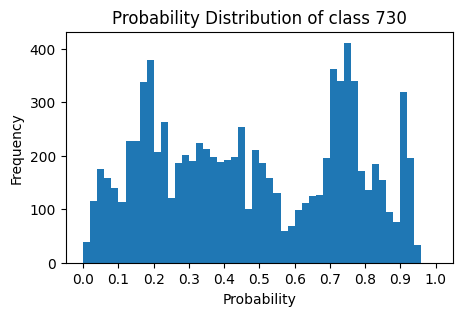

/home/paolo/cvsa_ws/record/monitor/h7/20240923/calibration/two_classifier/classifier/shift/cl_shift24.yaml
Train set: (17864, 25) (17864,)
Test set: (8932, 25) (8932,)
Best parameters found:  {'priors': [0.5, 0.5], 'reg_param': 1.0}
Best score found:  0.5947771782207543
Accuracy train: 0.6048477384684281
Accuracy test:  0.5466860725481415
Accuracy all:   0.5854605164949993
Accuracy: 0.6048477384684281
Accuracy 730: 0.6136363636363636
Accuracy 731: 0.5954313543599258
Integrated:  17864  percentual:  1.0 %


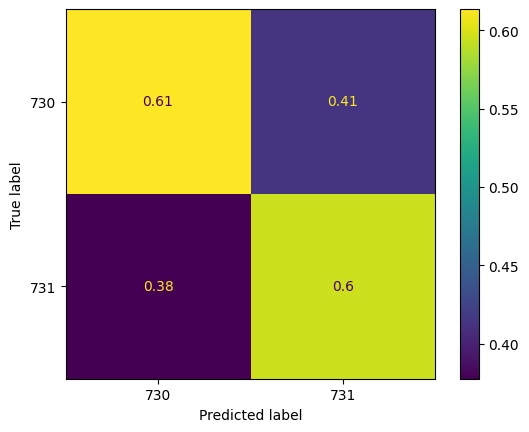

Accuracy: 0.5466860725481415
Accuracy 730: 0.474025974025974
Accuracy 731: 0.6057224025974026
Integrated:  8932  percentual:  1.0 %


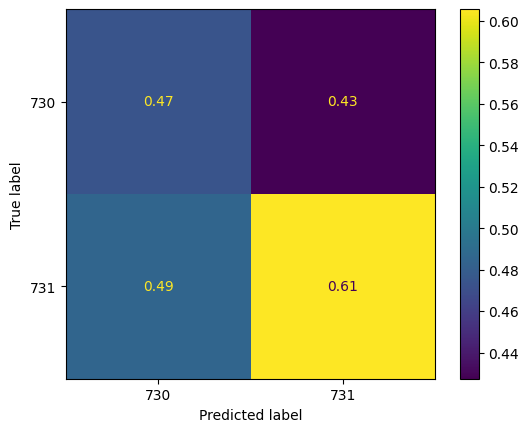

Accuracy: 0.5854605164949993
Accuracy 730: 0.5714285714285714
Accuracy 731: 0.5991735537190083
Integrated:  26796  percentual:  1.0 %


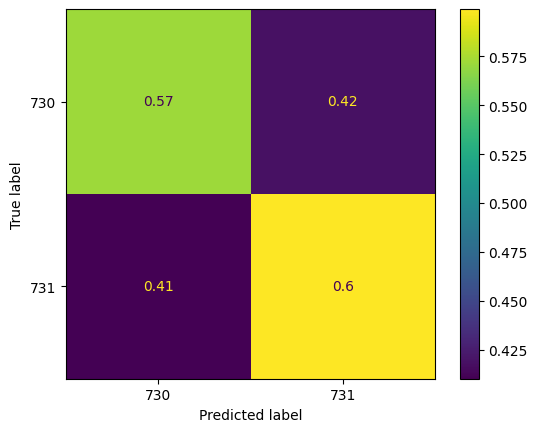

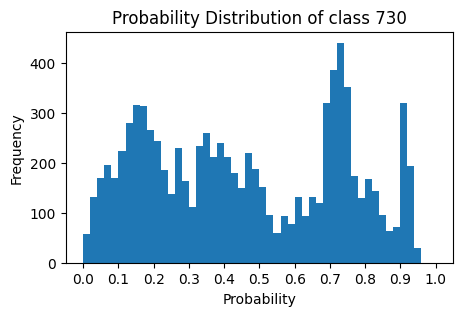

/home/paolo/cvsa_ws/record/monitor/h7/20240923/calibration/two_classifier/classifier/shift/cl_shift25.yaml
Train set: (17864, 26) (17864,)
Test set: (8932, 26) (8932,)
Best parameters found:  {'priors': [0.5, 0.5], 'reg_param': 1.0}
Best score found:  0.5936017111037772
Accuracy train: 0.6054635020152261
Accuracy test:  0.5520600089565607
Accuracy all:   0.5876623376623377
Accuracy: 0.6054635020152261
Accuracy 730: 0.6151515151515151
Accuracy 731: 0.5950834879406308
Integrated:  17864  percentual:  1.0 %


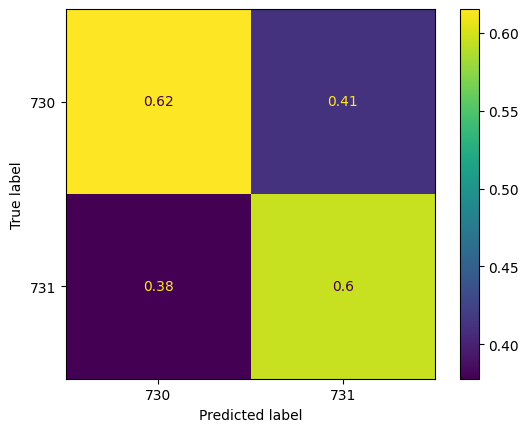

Accuracy: 0.5520600089565607
Accuracy 730: 0.489010989010989
Accuracy 731: 0.6032873376623377
Integrated:  8932  percentual:  1.0 %


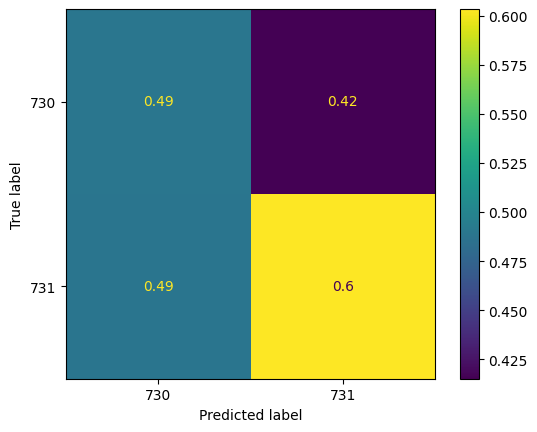

Accuracy: 0.5876623376623377
Accuracy 730: 0.5770160072485654
Accuracy 731: 0.5980667060212514
Integrated:  26796  percentual:  1.0 %


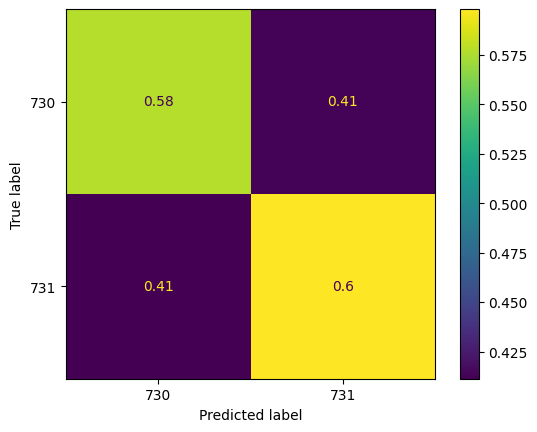

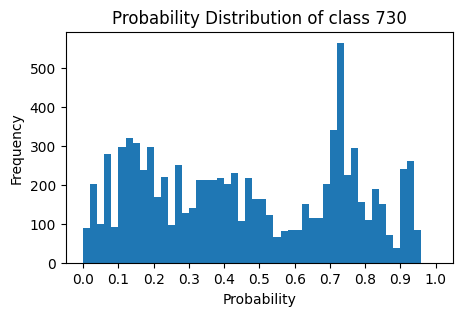

/home/paolo/cvsa_ws/record/monitor/h7/20240923/calibration/two_classifier/classifier/shift/cl_shift26.yaml
Train set: (17864, 27) (17864,)
Test set: (8932, 27) (8932,)
Best parameters found:  {'priors': [0.5, 0.5], 'reg_param': 1.0}
Best score found:  0.5929861073893443
Accuracy train: 0.6073107926556203
Accuracy test:  0.5475817286162113
Accuracy all:   0.587401104642484
Accuracy: 0.6073107926556203
Accuracy 730: 0.6189393939393939
Accuracy 731: 0.5948515769944341
Integrated:  17864  percentual:  1.0 %


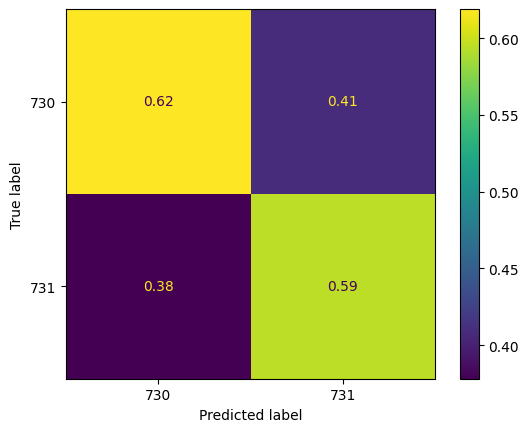

Accuracy: 0.5475817286162113
Accuracy 730: 0.48001998001998003
Accuracy 731: 0.6024756493506493
Integrated:  8932  percentual:  1.0 %


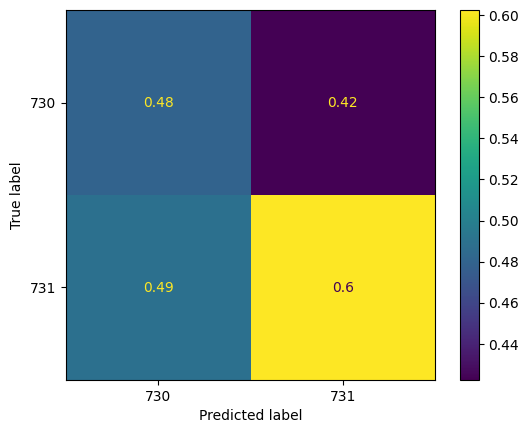

Accuracy: 0.587401104642484
Accuracy 730: 0.576940501359106
Accuracy 731: 0.5976239669421488
Integrated:  26796  percentual:  1.0 %


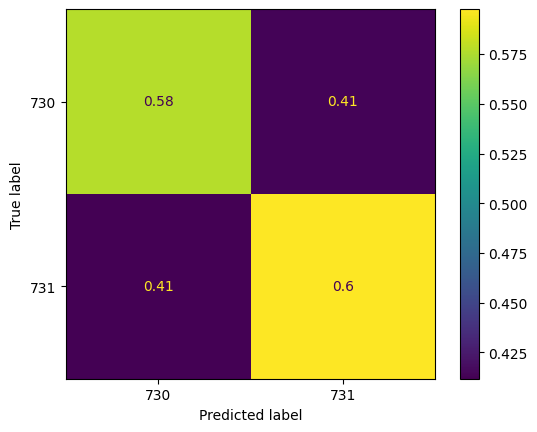

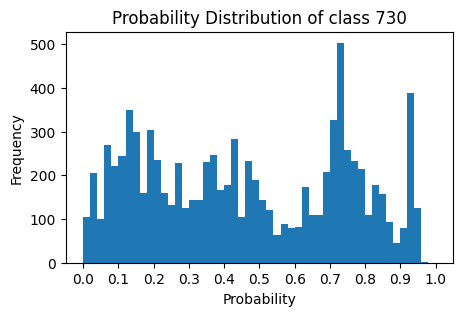

/home/paolo/cvsa_ws/record/monitor/h7/20240923/calibration/two_classifier/classifier/shift/cl_shift27.yaml


In [ ]:
for idx_dataset in range(1, max_dataset+1):
    path = '/home/paolo/cvsa_ws/record/' + subject + '/' + day + '/calibration/two_classifier/dataset/shift/shift_data' + str(idx_dataset) +'.mat'
    data = loadmat(path)

    X = fix_mat(data['X'])
    y = fix_mat(data['y']).ravel()
    info = fix_mat(data['info'])

    if 'logband' in path:
        type_ = 'logbandpower'
    else:
        type_ = 'psd'
        

    # start using last n-1 trials as test set
    n = int(info['nTest'])
    start_test = info['startTrial'][-n] - 1

    X_train = X[:start_test,:]
    y_train = y[:start_test].ravel()
    X_test = X[start_test:,:]
    y_test = y[start_test:].ravel()

    print('Train set:', X_train.shape, y_train.shape)
    print('Test set:', X_test.shape, y_test.shape)
    
    param_grid = {'reg_param': [0.0, 0.1, 0.5, 1.0], 'priors': [None, [0.5, 0.5]]}

    #grid_search = GridSearchCV(estimator=QuadraticDiscriminantAnalysis(), param_grid=param_grid, cv=5, n_jobs=-1, verbose=3).fit(X_train, y_train)
    grid_search = GridSearchCV(estimator=QuadraticDiscriminantAnalysis(), param_grid=param_grid, cv=5, n_jobs=-1).fit(X_train, y_train)

    #print("Results: ", grid_search.cv_results_)
    print("Best parameters found: ", grid_search.best_params_)
    print("Best score found: ", grid_search.best_score_)

    model_qda = QuadraticDiscriminantAnalysis(reg_param=grid_search.best_params_['reg_param'], store_covariance=True, priors=grid_search.best_params_['priors'])
    model_qda.fit(X_train, y_train)

    print(f'Accuracy train: {model_qda.score(X_train, y_train)}')
    print(f'Accuracy test:  {model_qda.score(X_test, y_test)}')
    print(f'Accuracy all:   {model_qda.score(X, y)}')


    ths_rej = [0.5, 0.5]
    bins_step = 0.02

    print_cm_rej(model_qda, X_train, y_train, ths_rej, 'train set',  ['730', '731'])
    print_cm_rej(model_qda, X_test,  y_test,  ths_rej, 'test set',  ['730', '731'])
    print_cm_rej(model_qda, X,  y,  ths_rej, 'all dataset',  ['730', '731'])

    histo_prediction(X_test, model_qda, bins_step, classes=['730', '731'])
    
    features_label = []
    if type(info['chSelected'].tolist()) == int:
        features_label.append(str(info['channelsLabel'][info['chSelected'].tolist() - 1][0]))
    else:
        for i in range(0, len(info['chSelected'].tolist())):
            features_label.append(str(info['channelsLabel'][info['chSelected'][i] - 1][0]))

    files = []
    for i in range(0, len(info['files'])):
        str_file = info['files'][i][0]
        files.append(str(str_file))
        
    band = info['bandSelected'].tolist()
    id_ch = info['chSelected'].tolist()

    model_params = {
        'QdaCfg': {
            'name': "qda",
            'params': {
                'subject': subject,
                'filename': 'qda',
                'filename_dataset': path,
                'files': files,
                'type_data': type_,
                'nclasses': int(len(model_qda.classes_)),
                'classlbs': model_qda.classes_.tolist(),
                'nfeatures': int(model_qda.n_features_in_),
                'chans': features_label,
                'idchans': id_ch, 
                'note': 'idchans are saved in matlab convention, instead the names are correct',
                'sampleRate': int(info['sampleRate']),
                'band': band,
                'filterOrder': int(info['filterOrder']),
                'priors': model_qda.priors_.tolist(),
                'means': model_qda.means_.tolist(),
                'covs': [arr.tolist() for arr in model_qda.covariance_],
                'rotations': [arr.tolist() for arr in model_qda.rotations_],
                'scalings': [arr.tolist() for arr in model_qda.scalings_]
            }
        }
    }

    # Save parameters to a YAML file
    c_dir = os.getcwd()
    c_prev = os.path.abspath(os.path.join(c_dir, os.pardir))
    path2save = c_prev[0:20] + 'record/' + subject + '/' + day + '/calibration/two_classifier/classifier/shift/cl_shift' + str(idx_dataset) + '.yaml'

    yaml = YAML()
    with open(path2save, 'w') as file:
        yaml.dump(model_params, file)
        
    print(path2save)


# Mantained

### With seed

In [ ]:
auc_scores_test, best_model, chosen_qda = select_best_qda_seed(subject, day, nqda, seeds, classes, 'sustained', fold)
save_qda(subject, day, best_model, chosen_qda, 'sustained')

### One QDA for each dataset

Train set: (65134, 1) (65134,)
Test set: (32567, 1) (32567,)
Best parameters found:  {'priors': None, 'reg_param': 0.5}
Best score found:  0.6077035258156089
Accuracy train: 0.6060429268891823
Accuracy test:  0.4748671968557128
Accuracy all:   0.5623176835446925
Accuracy: 0.6060429268891823
Accuracy 730: 0.8066785396260018
Accuracy 731: 0.39107619895687573
Integrated:  65134  percentual:  1.0 %


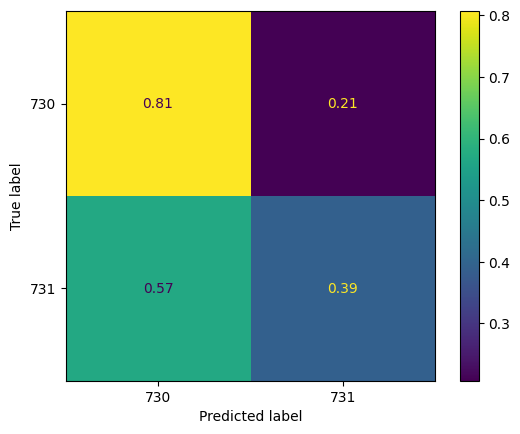

Accuracy: 0.4748671968557128
Accuracy 730: 0.7468319747927941
Accuracy 731: 0.2538958147818344
Integrated:  32567  percentual:  1.0 %


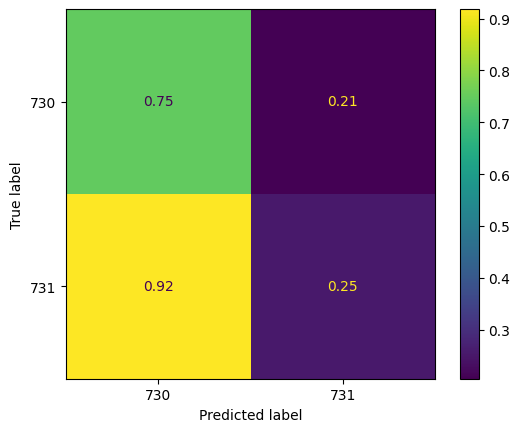

Accuracy: 0.5623176835446925
Accuracy 730: 0.7885853921182878
Accuracy 731: 0.3411924228932243
Integrated:  97701  percentual:  1.0 %


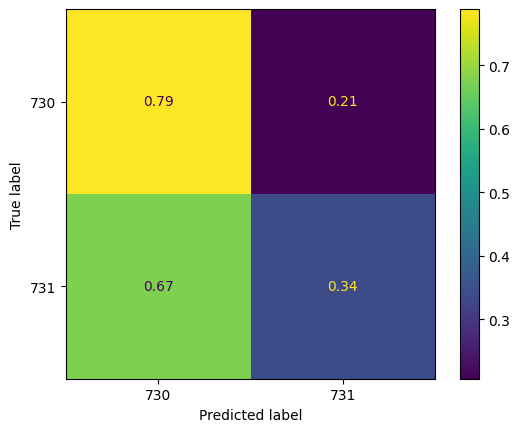

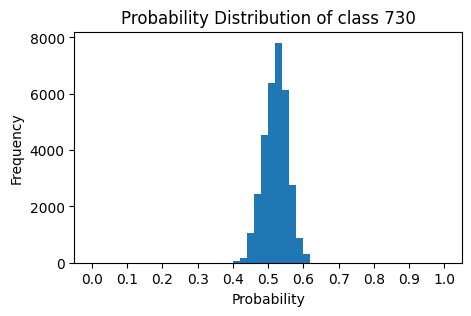

/home/paolo/cvsa_ws/record/monitor/h7/20240923/calibration/two_classifier/classifier/sustained/cl_sus1.yaml
Train set: (65134, 2) (65134,)
Test set: (32567, 2) (32567,)
Best parameters found:  {'priors': None, 'reg_param': 0.1}
Best score found:  0.6048451802926732
Accuracy train: 0.616790002149415
Accuracy test:  0.5507415481929561
Accuracy all:   0.5947738508305954
Accuracy: 0.616790002149415
Accuracy 730: 0.6957257346393588
Accuracy 731: 0.5322160030530467
Integrated:  65134  percentual:  1.0 %


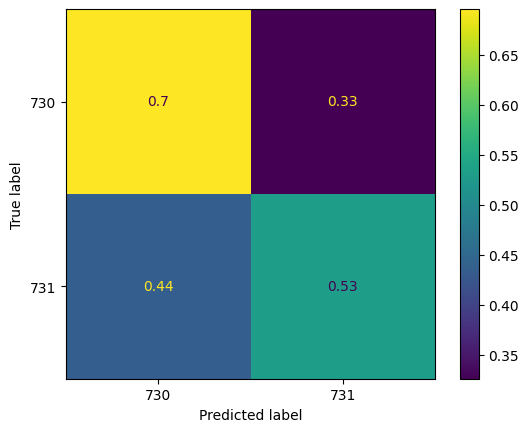

Accuracy: 0.5507415481929561
Accuracy 730: 0.6528529351325433
Accuracy 731: 0.4677760463045414
Integrated:  32567  percentual:  1.0 %


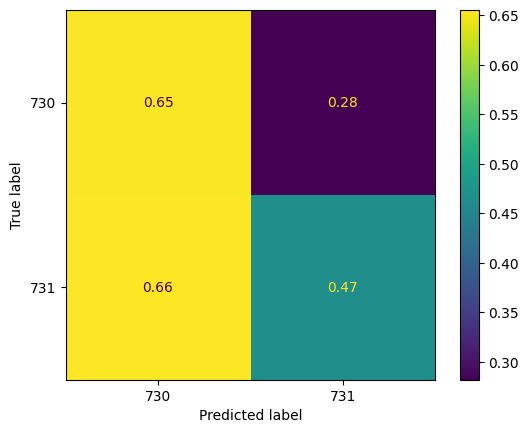

Accuracy: 0.5947738508305954
Accuracy 730: 0.6827641906024147
Accuracy 731: 0.5087832915081357
Integrated:  97701  percentual:  1.0 %


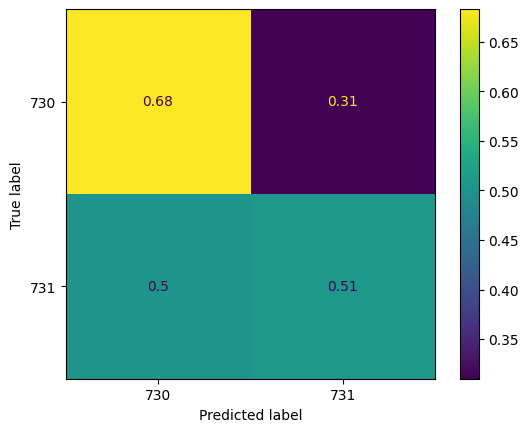

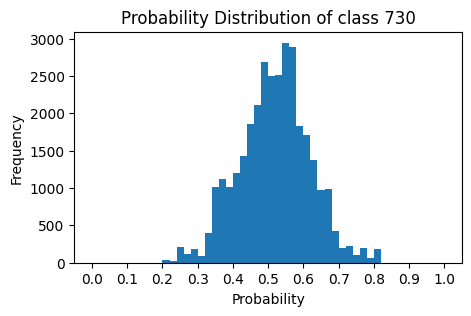

/home/paolo/cvsa_ws/record/monitor/h7/20240923/calibration/two_classifier/classifier/sustained/cl_sus2.yaml
Train set: (65134, 3) (65134,)
Test set: (32567, 3) (32567,)
Best parameters found:  {'priors': None, 'reg_param': 1.0}
Best score found:  0.6063668589623664
Accuracy train: 0.6138882918291522
Accuracy test:  0.5161666717843215
Accuracy all:   0.5813144184808753
Accuracy: 0.6138882918291522
Accuracy 730: 0.7653606411398041
Accuracy 731: 0.4515964889963109
Integrated:  65134  percentual:  1.0 %


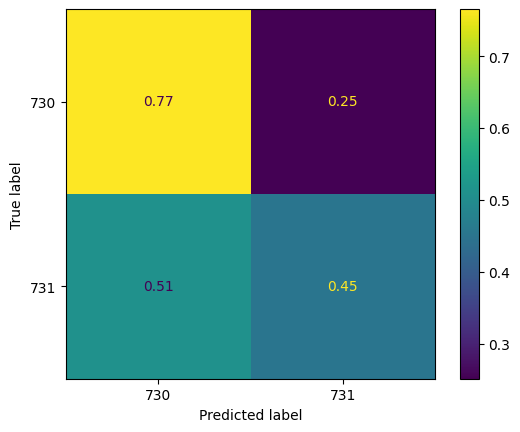

Accuracy: 0.5161666717843215
Accuracy 730: 0.7603945475717515
Accuracy 731: 0.31773152270703475
Integrated:  32567  percentual:  1.0 %


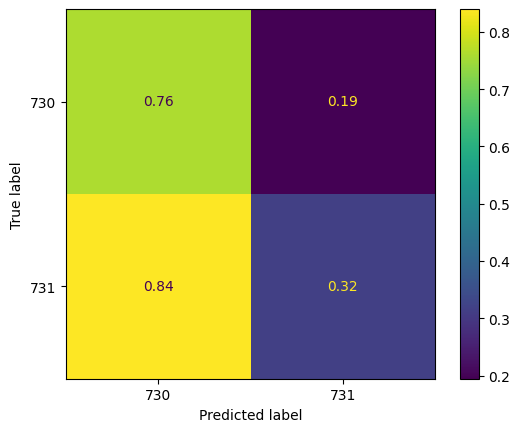

Accuracy: 0.5813144184808753
Accuracy 730: 0.7638592640145789
Accuracy 731: 0.40291831943657413
Integrated:  97701  percentual:  1.0 %


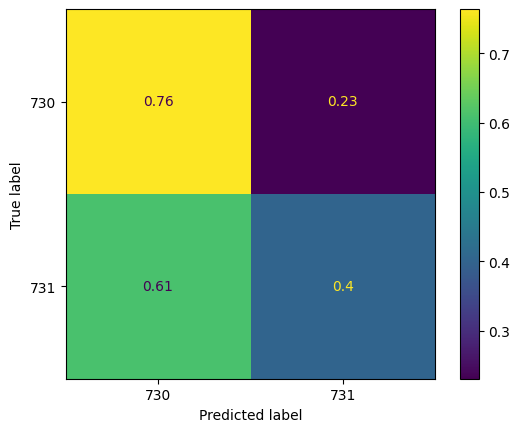

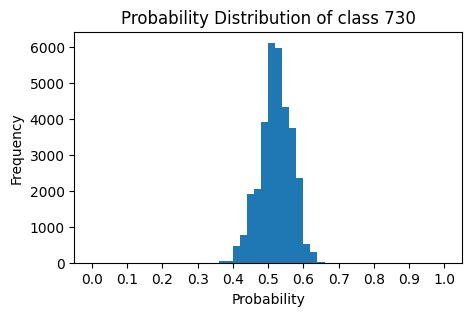

/home/paolo/cvsa_ws/record/monitor/h7/20240923/calibration/two_classifier/classifier/sustained/cl_sus3.yaml
Train set: (65134, 4) (65134,)
Test set: (32567, 4) (32567,)
Best parameters found:  {'priors': None, 'reg_param': 0.1}
Best score found:  0.5990728052548528
Accuracy train: 0.6117542297417632
Accuracy test:  0.5420824761261399
Accuracy all:   0.5885303118698887
Accuracy: 0.6117542297417632
Accuracy 730: 0.6801721579103591
Accuracy 731: 0.5384493067039817
Integrated:  65134  percentual:  1.0 %


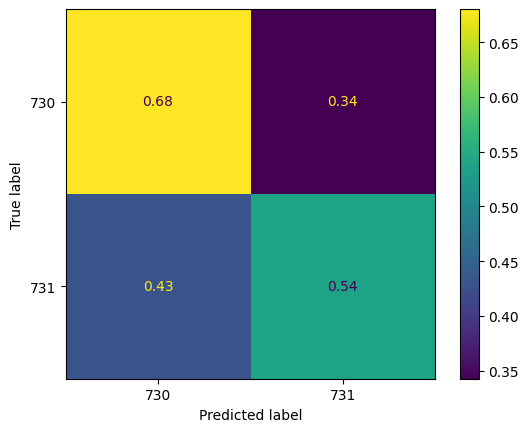

Accuracy: 0.5420824761261399
Accuracy 730: 0.6829919857524488
Accuracy 731: 0.427593499554764
Integrated:  32567  percentual:  1.0 %


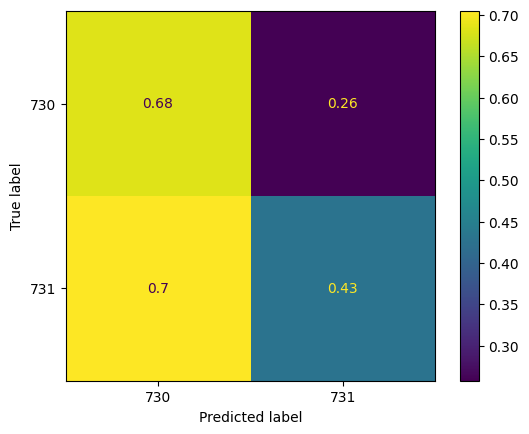

Accuracy: 0.5885303118698887
Accuracy 730: 0.6810246640021537
Accuracy 731: 0.4981381041042662
Integrated:  97701  percentual:  1.0 %


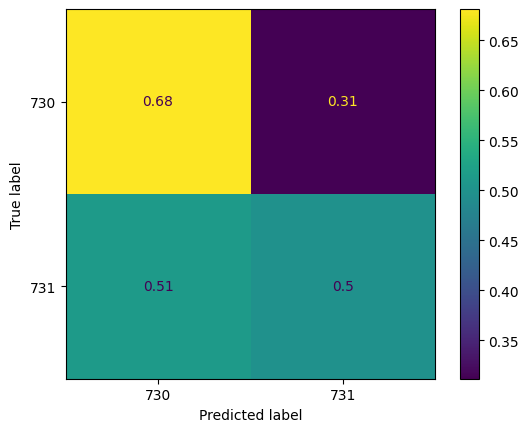

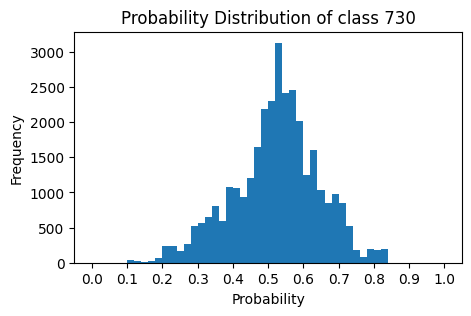

/home/paolo/cvsa_ws/record/monitor/h7/20240923/calibration/two_classifier/classifier/sustained/cl_sus4.yaml
Train set: (65134, 5) (65134,)
Test set: (32567, 5) (32567,)
Best parameters found:  {'priors': None, 'reg_param': 0.1}
Best score found:  0.6018055945433861
Accuracy train: 0.6197684772929652
Accuracy test:  0.5340068167163079
Accuracy all:   0.5911812571007462
Accuracy: 0.6197684772929652
Accuracy 730: 0.6960225586227368
Accuracy 731: 0.5380676758682101
Integrated:  65134  percentual:  1.0 %


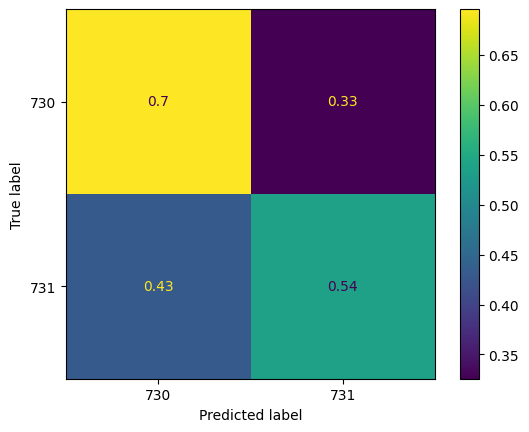

Accuracy: 0.5340068167163079
Accuracy 730: 0.6884033152955682
Accuracy 731: 0.40855966162065893
Integrated:  32567  percentual:  1.0 %


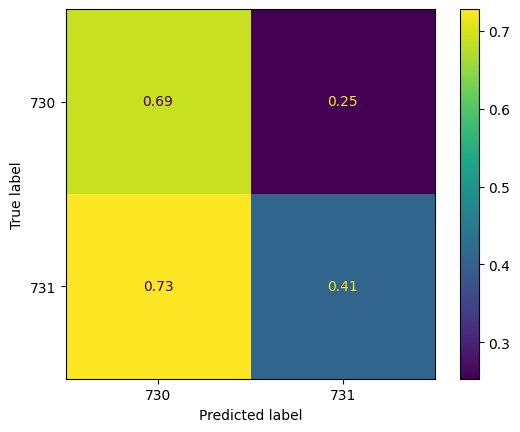

Accuracy: 0.5911812571007462
Accuracy 730: 0.6937190664540579
Accuracy 731: 0.49097385250546427
Integrated:  97701  percentual:  1.0 %


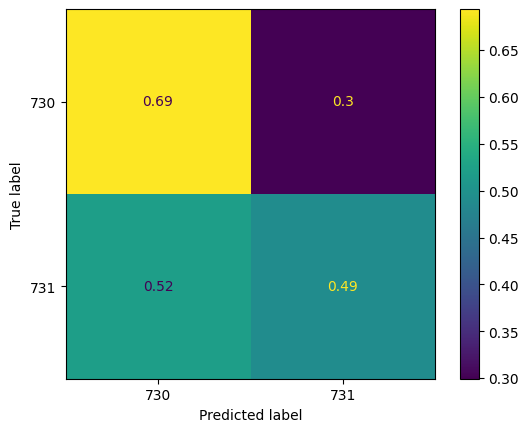

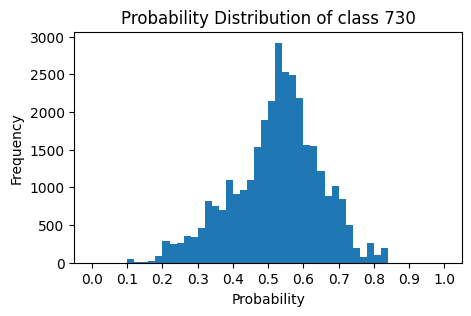

/home/paolo/cvsa_ws/record/monitor/h7/20240923/calibration/two_classifier/classifier/sustained/cl_sus5.yaml
Train set: (65134, 6) (65134,)
Test set: (32567, 6) (32567,)
Best parameters found:  {'priors': None, 'reg_param': 0.5}
Best score found:  0.6069049104700531
Accuracy train: 0.6199680658335125
Accuracy test:  0.4966991125986428
Accuracy all:   0.5788784147552226
Accuracy: 0.6199680658335125
Accuracy 730: 0.6830216681507866
Accuracy 731: 0.5524106347792902
Integrated:  65134  percentual:  1.0 %


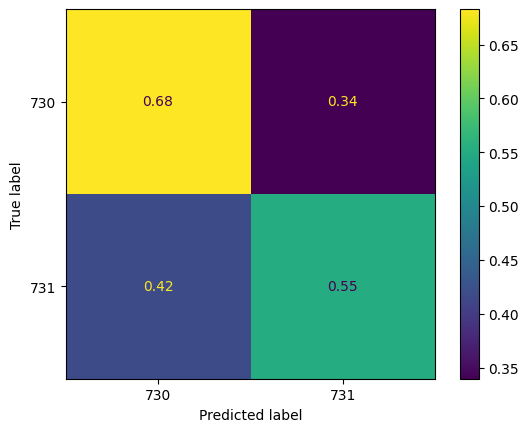

Accuracy: 0.4966991125986428
Accuracy 730: 0.6631276114802384
Accuracy 731: 0.3614759572573464
Integrated:  32567  percentual:  1.0 %


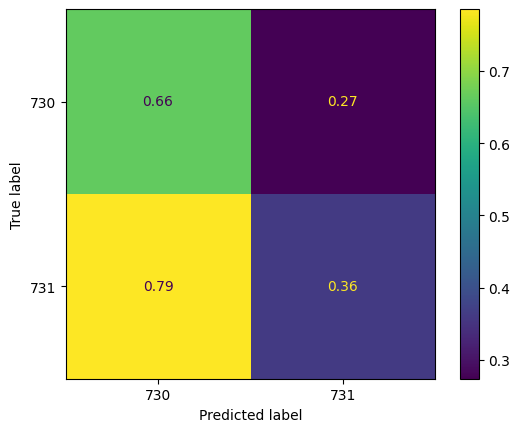

Accuracy: 0.5788784147552226
Accuracy 730: 0.6770071859015511
Accuracy 731: 0.4829798429531288
Integrated:  97701  percentual:  1.0 %


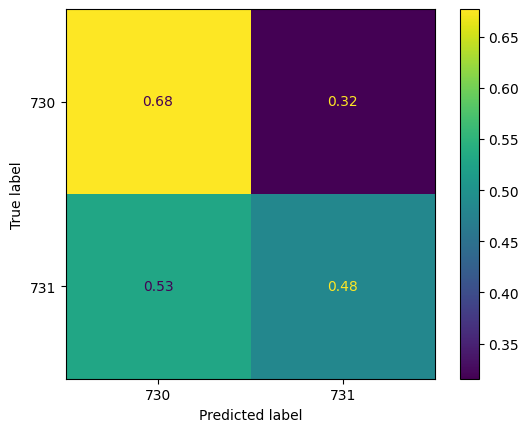

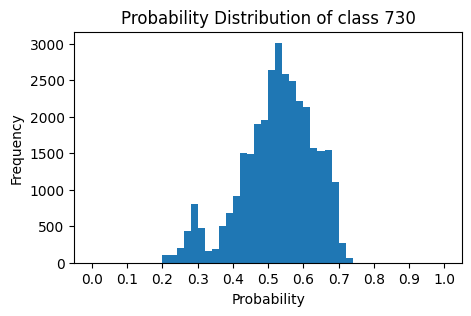

/home/paolo/cvsa_ws/record/monitor/h7/20240923/calibration/two_classifier/classifier/sustained/cl_sus6.yaml
Train set: (65134, 7) (65134,)
Test set: (32567, 7) (32567,)
Best parameters found:  {'priors': None, 'reg_param': 0.5}
Best score found:  0.6117872421038255
Accuracy train: 0.6223631283200786
Accuracy test:  0.5014585316424601
Accuracy all:   0.5820615960942058
Accuracy: 0.6223631283200786
Accuracy 730: 0.681300089047195
Accuracy 731: 0.5592163846838825
Integrated:  65134  percentual:  1.0 %


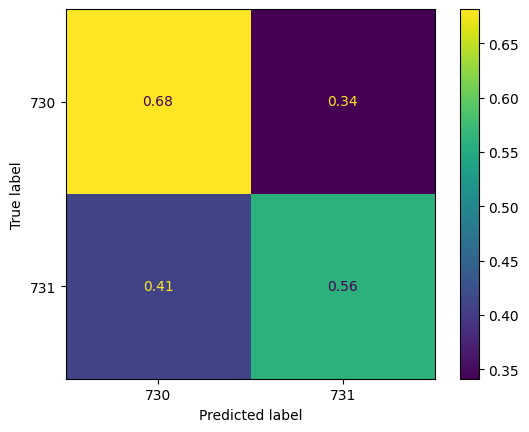

Accuracy: 0.5014585316424601
Accuracy 730: 0.6533324200287691
Accuracy 731: 0.37806099732858417
Integrated:  32567  percentual:  1.0 %


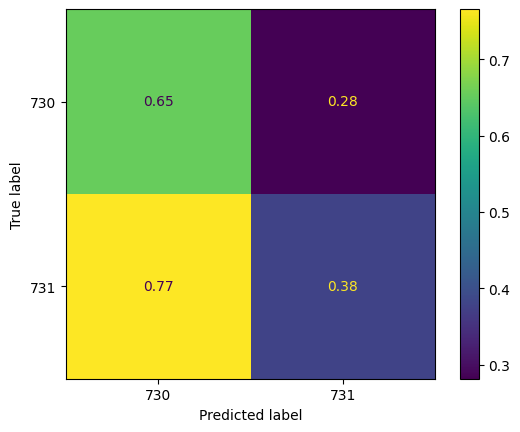

Accuracy: 0.5820615960942058
Accuracy 730: 0.6728447472509267
Accuracy 731: 0.4933416983728649
Integrated:  97701  percentual:  1.0 %


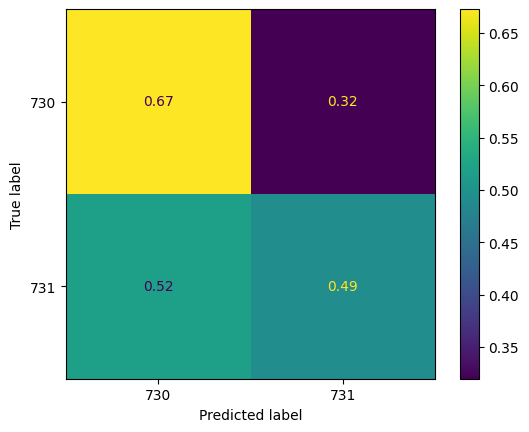

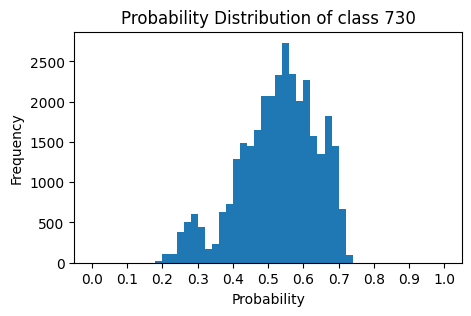

/home/paolo/cvsa_ws/record/monitor/h7/20240923/calibration/two_classifier/classifier/sustained/cl_sus7.yaml
Train set: (65134, 8) (65134,)
Test set: (32567, 8) (32567,)
Best parameters found:  {'priors': None, 'reg_param': 0.5}
Best score found:  0.6169458344620111
Accuracy train: 0.631805201584426
Accuracy test:  0.5036386526238217
Accuracy all:   0.5890830185975579
Accuracy: 0.631805201584426
Accuracy 730: 0.6908875037102998
Accuracy 731: 0.5685027350209897
Integrated:  65134  percentual:  1.0 %


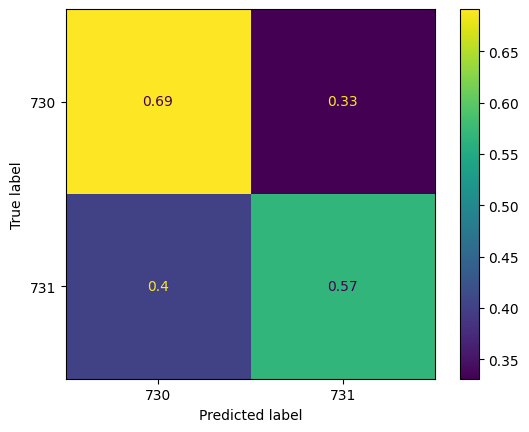

Accuracy: 0.5036386526238217
Accuracy 730: 0.6490170559627372
Accuracy 731: 0.3855186999109528
Integrated:  32567  percentual:  1.0 %


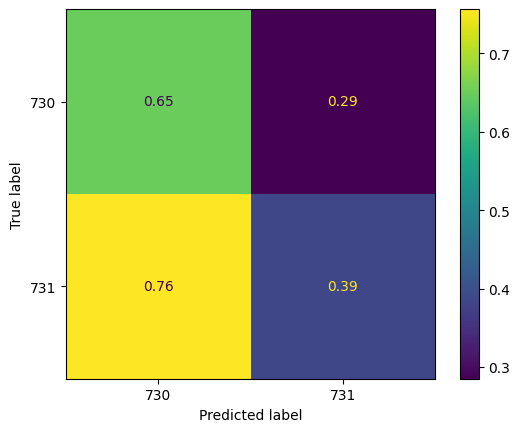

Accuracy: 0.5890830185975579
Accuracy 730: 0.6782289962517344
Accuracy 731: 0.5019630858900672
Integrated:  97701  percentual:  1.0 %


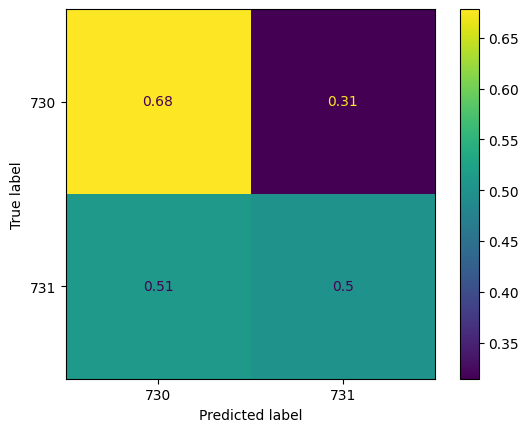

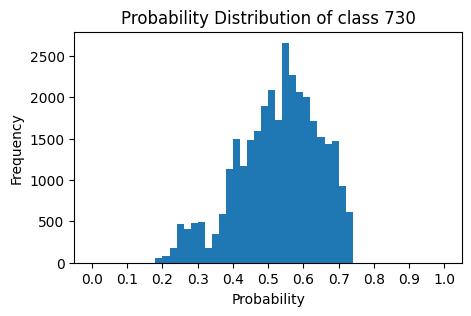

/home/paolo/cvsa_ws/record/monitor/h7/20240923/calibration/two_classifier/classifier/sustained/cl_sus8.yaml
Train set: (65134, 9) (65134,)
Test set: (32567, 9) (32567,)
Best parameters found:  {'priors': [0.5, 0.5], 'reg_param': 1.0}
Best score found:  0.6113114230113976
Accuracy train: 0.6155157060828446
Accuracy test:  0.4867810974299137
Accuracy all:   0.572604169865201
Accuracy: 0.6155157060828446
Accuracy 730: 0.6273078064707628
Accuracy 731: 0.6028813128100751
Integrated:  65134  percentual:  1.0 %


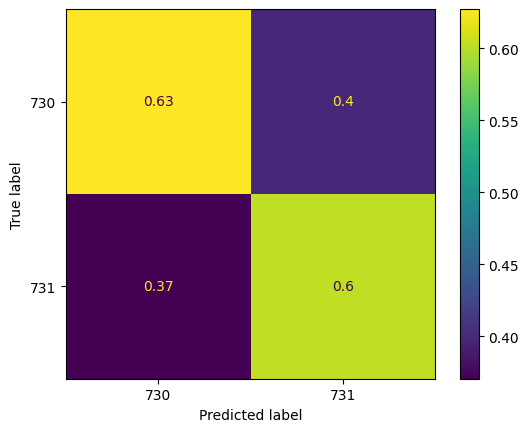

Accuracy: 0.4867810974299137
Accuracy 730: 0.556202479621892
Accuracy 731: 0.4303762243989314
Integrated:  32567  percentual:  1.0 %


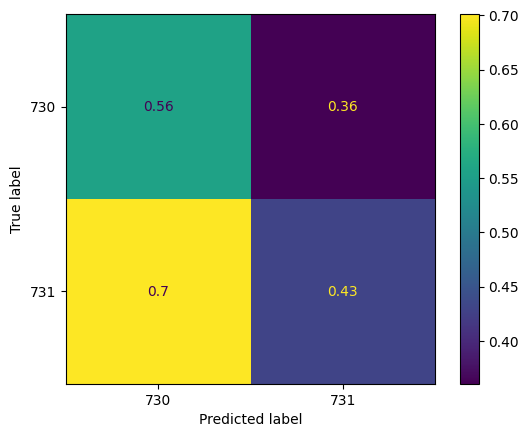

Accuracy: 0.572604169865201
Accuracy 730: 0.6058108471908716
Accuracy 731: 0.5401521897514774
Integrated:  97701  percentual:  1.0 %


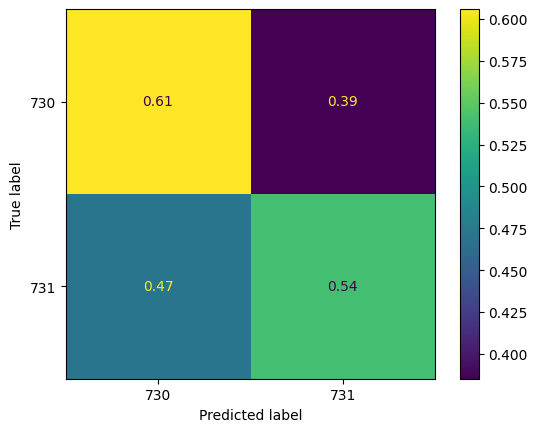

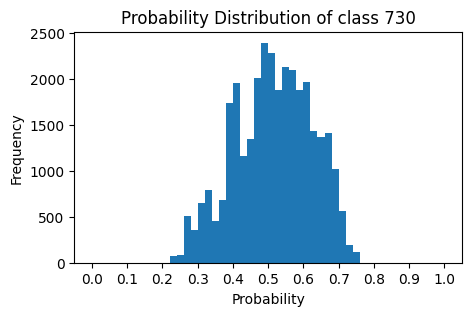

/home/paolo/cvsa_ws/record/monitor/h7/20240923/calibration/two_classifier/classifier/sustained/cl_sus9.yaml
Train set: (65134, 10) (65134,)
Test set: (32567, 10) (32567,)
Best parameters found:  {'priors': None, 'reg_param': 1.0}
Best score found:  0.605584865721551
Accuracy train: 0.6081462830472564
Accuracy test:  0.44882856879663463
Accuracy all:   0.5550403782970491
Accuracy: 0.6081462830472564
Accuracy 730: 0.6637874740279015
Accuracy 731: 0.5485307212822796
Integrated:  65134  percentual:  1.0 %


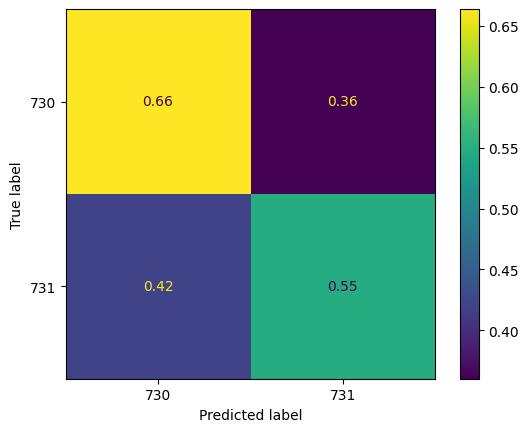

Accuracy: 0.44882856879663463
Accuracy 730: 0.5745599013631071
Accuracy 731: 0.34667186108637577
Integrated:  32567  percentual:  1.0 %


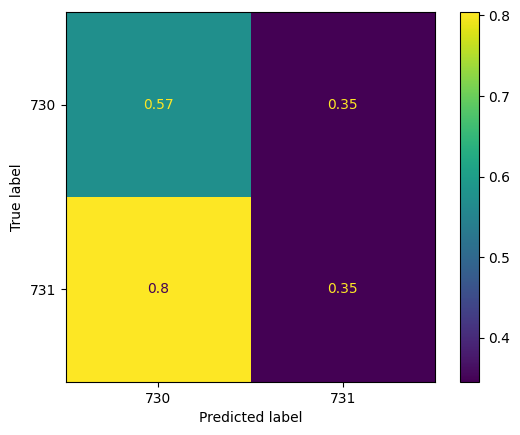

Accuracy: 0.5550403782970491
Accuracy 730: 0.6368116962455218
Accuracy 731: 0.47512749939286003
Integrated:  97701  percentual:  1.0 %


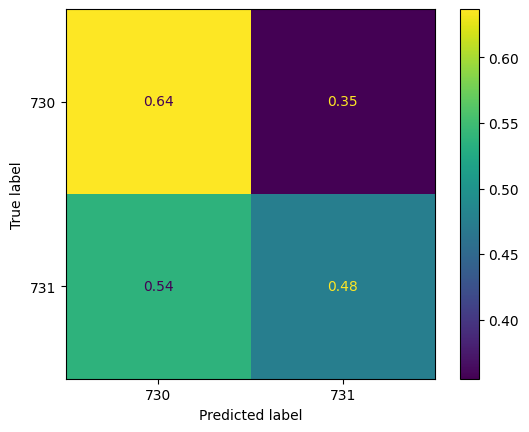

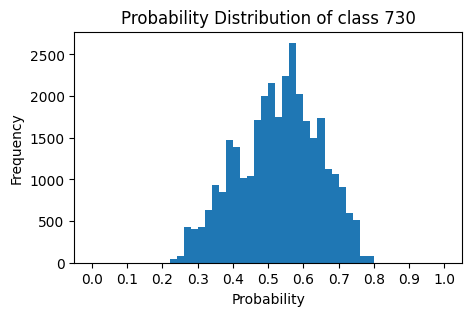

/home/paolo/cvsa_ws/record/monitor/h7/20240923/calibration/two_classifier/classifier/sustained/cl_sus10.yaml
Train set: (65134, 11) (65134,)
Test set: (32567, 11) (32567,)
Best parameters found:  {'priors': [0.5, 0.5], 'reg_param': 1.0}
Best score found:  0.606106787788454
Accuracy train: 0.61061811035711
Accuracy test:  0.4542635182853809
Accuracy all:   0.5584999129998669
Accuracy: 0.61061811035711
Accuracy 730: 0.6244582962303354
Accuracy 731: 0.5957893397786541
Integrated:  65134  percentual:  1.0 %


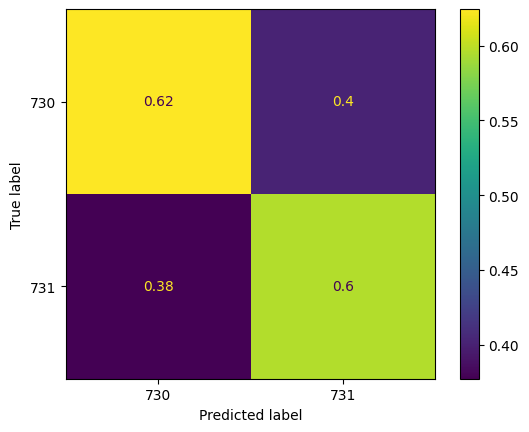

Accuracy: 0.4542635182853809
Accuracy 730: 0.5183916706623741
Accuracy 731: 0.4021593944790739
Integrated:  32567  percentual:  1.0 %


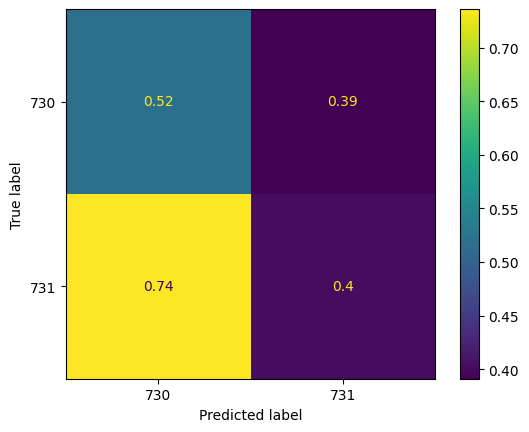

Accuracy: 0.5584999129998669
Accuracy 730: 0.5923916419888587
Accuracy 731: 0.5253784505788067
Integrated:  97701  percentual:  1.0 %


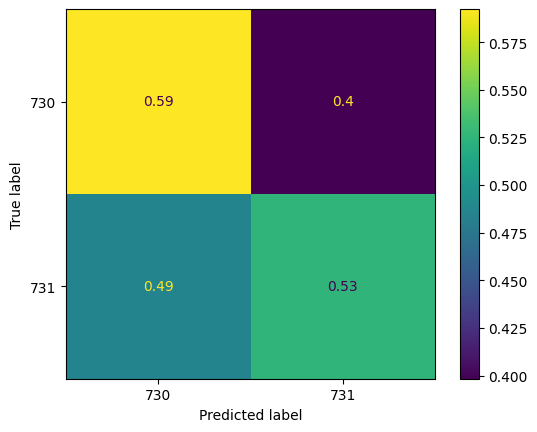

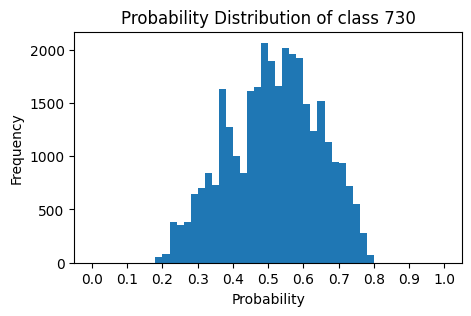

/home/paolo/cvsa_ws/record/monitor/h7/20240923/calibration/two_classifier/classifier/sustained/cl_sus11.yaml
Train set: (65134, 12) (65134,)
Test set: (32567, 12) (32567,)
Best parameters found:  {'priors': [0.5, 0.5], 'reg_param': 1.0}
Best score found:  0.6086245811192479
Accuracy train: 0.6084994012343784
Accuracy test:  0.4621856480486382
Accuracy all:   0.559728150172465
Accuracy: 0.6084994012343784
Accuracy 730: 0.6230335411101217
Accuracy 731: 0.5929271085103677
Integrated:  65134  percentual:  1.0 %


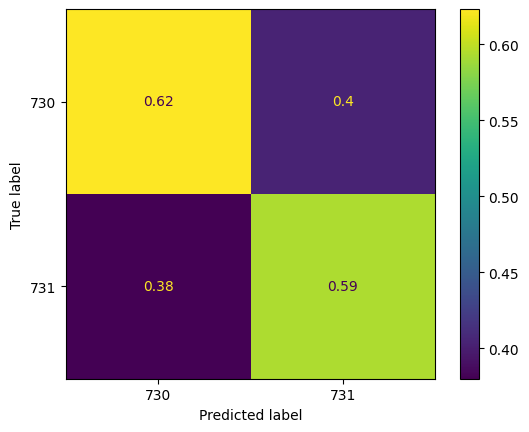

Accuracy: 0.4621856480486382
Accuracy 730: 0.526885403109802
Accuracy 731: 0.40961709706144256
Integrated:  32567  percentual:  1.0 %


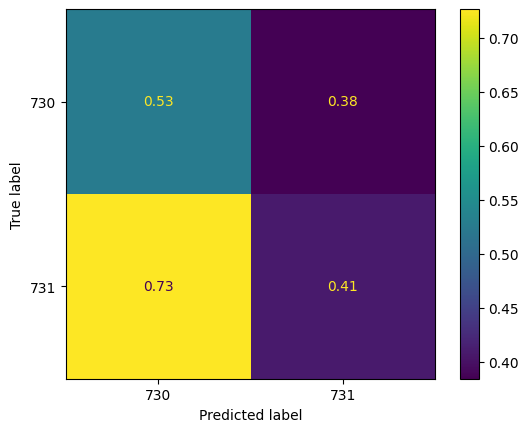

Accuracy: 0.559728150172465
Accuracy 730: 0.5939654993890948
Accuracy 731: 0.5262689225289403
Integrated:  97701  percentual:  1.0 %


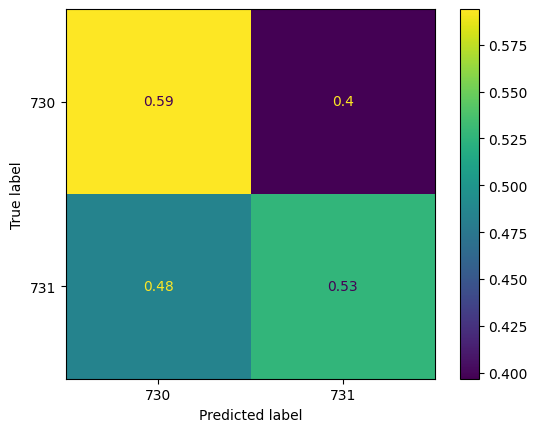

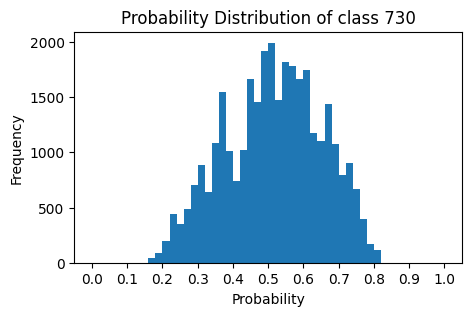

/home/paolo/cvsa_ws/record/monitor/h7/20240923/calibration/two_classifier/classifier/sustained/cl_sus12.yaml
Train set: (65134, 13) (65134,)
Test set: (32567, 13) (32567,)
Best parameters found:  {'priors': [0.5, 0.5], 'reg_param': 1.0}
Best score found:  0.6075652546080845
Accuracy train: 0.6044615715294623
Accuracy test:  0.4722264869346271
Accuracy all:   0.5603832099978506
Accuracy: 0.6044615715294623
Accuracy 730: 0.6241317898486197
Accuracy 731: 0.5833863376160794
Integrated:  65134  percentual:  1.0 %


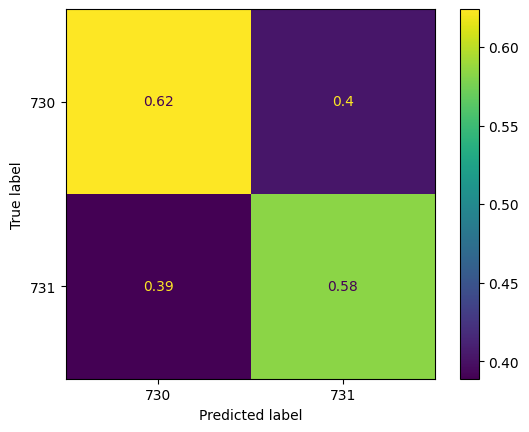

Accuracy: 0.4722264869346271
Accuracy 730: 0.5384615384615384
Accuracy 731: 0.4184105075690116
Integrated:  32567  percentual:  1.0 %


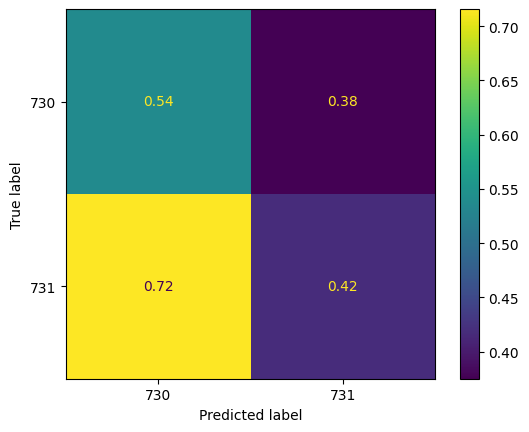

Accuracy: 0.5603832099978506
Accuracy 730: 0.5982314812897347
Accuracy 731: 0.5233951266898729
Integrated:  97701  percentual:  1.0 %


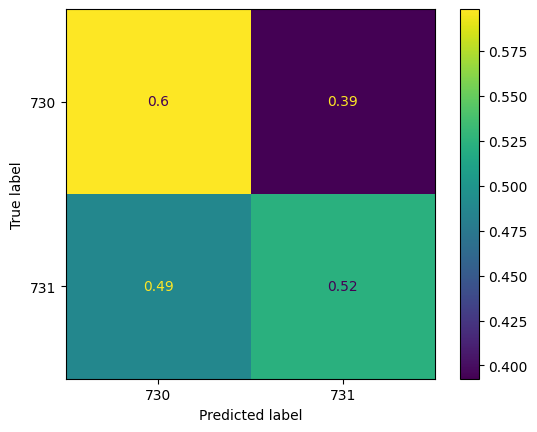

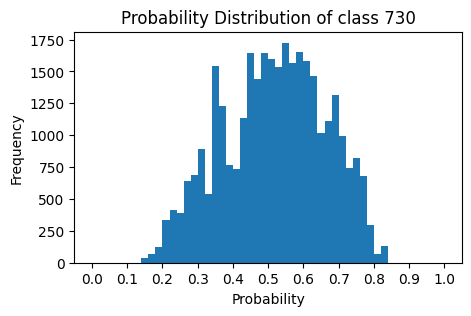

/home/paolo/cvsa_ws/record/monitor/h7/20240923/calibration/two_classifier/classifier/sustained/cl_sus13.yaml
Train set: (65134, 14) (65134,)
Test set: (32567, 14) (32567,)
Best parameters found:  {'priors': None, 'reg_param': 1.0}
Best score found:  0.6064293624606636
Accuracy train: 0.609681579513004
Accuracy test:  0.4760647280989959
Accuracy all:   0.5651426290416679
Accuracy: 0.609681579513004
Accuracy 730: 0.6626892252894034
Accuracy 731: 0.5528876733240046
Integrated:  65134  percentual:  1.0 %


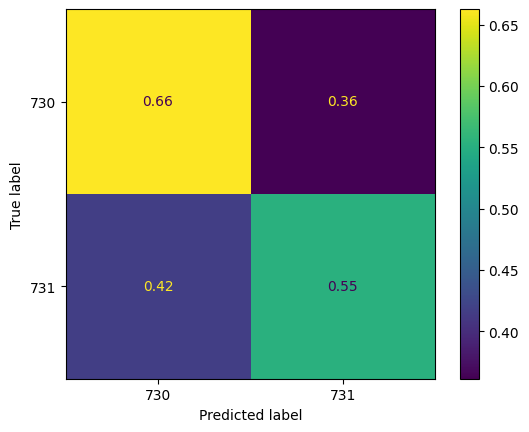

Accuracy: 0.4760647280989959
Accuracy 730: 0.5857250496609356
Accuracy 731: 0.38696571682991987
Integrated:  32567  percentual:  1.0 %


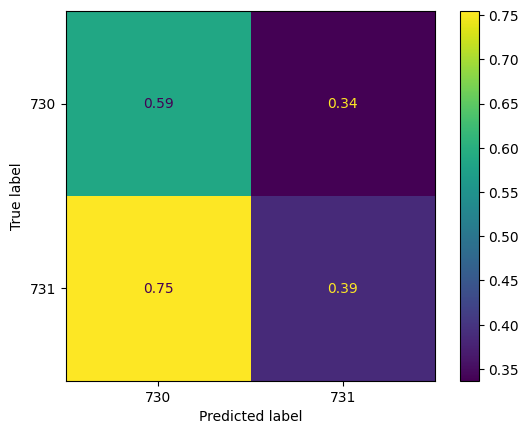

Accuracy: 0.5651426290416679
Accuracy 730: 0.6394209861459131
Accuracy 731: 0.49255241641706465
Integrated:  97701  percentual:  1.0 %


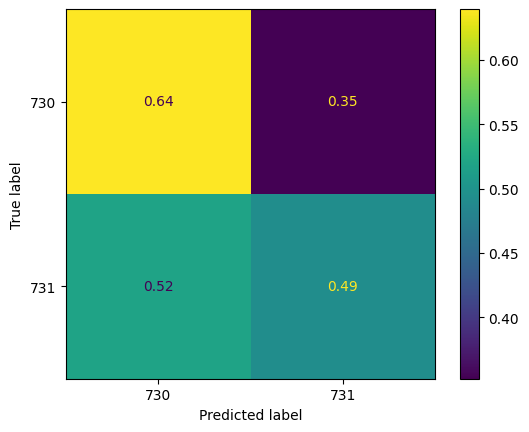

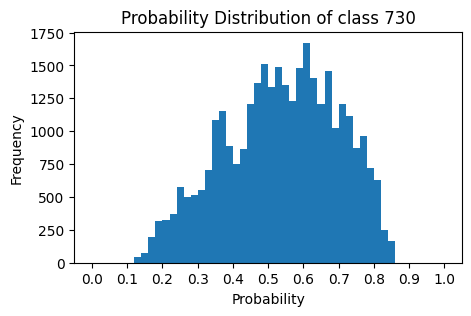

/home/paolo/cvsa_ws/record/monitor/h7/20240923/calibration/two_classifier/classifier/sustained/cl_sus14.yaml
Train set: (65134, 15) (65134,)
Test set: (32567, 15) (32567,)
Best parameters found:  {'priors': [0.5, 0.5], 'reg_param': 1.0}
Best score found:  0.6044641047221593
Accuracy train: 0.6066723984401388
Accuracy test:  0.44744680197746184
Accuracy all:   0.5535971996192465
Accuracy: 0.6066723984401388
Accuracy 730: 0.6256159097655091
Accuracy 731: 0.5863757791629564
Integrated:  65134  percentual:  1.0 %


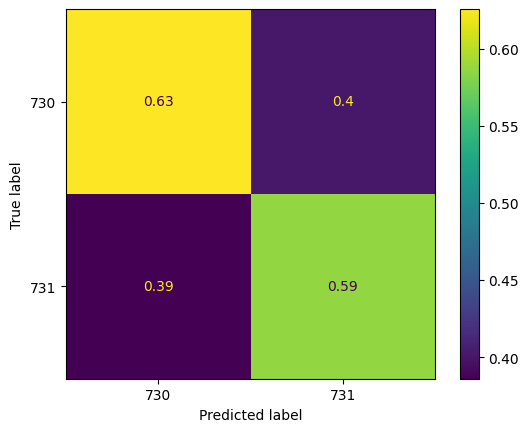

Accuracy: 0.44744680197746184
Accuracy 730: 0.5188711555585999
Accuracy 731: 0.38941451469278715
Integrated:  32567  percentual:  1.0 %


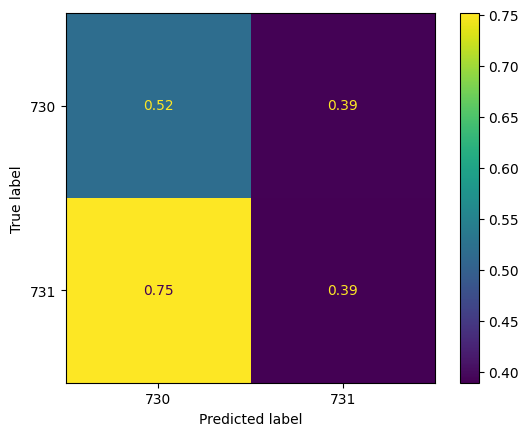

Accuracy: 0.5535971996192465
Accuracy 730: 0.5933442398890016
Accuracy 731: 0.5147535011738039
Integrated:  97701  percentual:  1.0 %


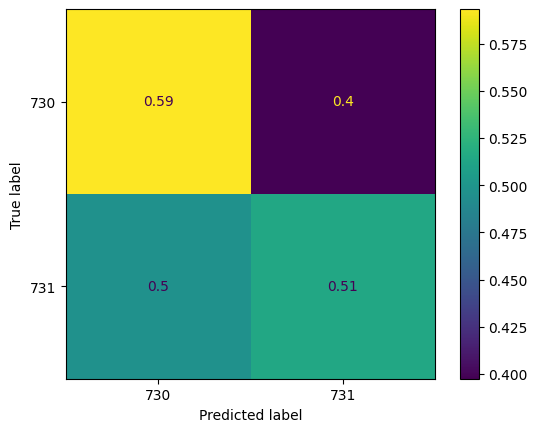

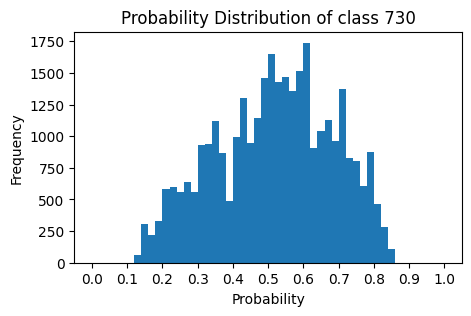

/home/paolo/cvsa_ws/record/monitor/h7/20240923/calibration/two_classifier/classifier/sustained/cl_sus15.yaml
Train set: (65134, 16) (65134,)
Test set: (32567, 16) (32567,)
Best parameters found:  {'priors': [0.5, 0.5], 'reg_param': 1.0}
Best score found:  0.6032359123360356
Accuracy train: 0.6057051616667178
Accuracy test:  0.4583167009549544
Accuracy all:   0.5565756747627967
Accuracy: 0.6057051616667178
Accuracy 730: 0.6272187592757494
Accuracy 731: 0.582654878514184
Integrated:  65134  percentual:  1.0 %


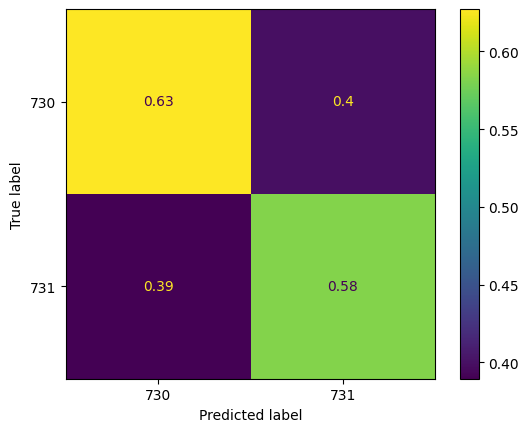

Accuracy: 0.4583167009549544
Accuracy 730: 0.5356531269265018
Accuracy 731: 0.3954808548530721
Integrated:  32567  percentual:  1.0 %


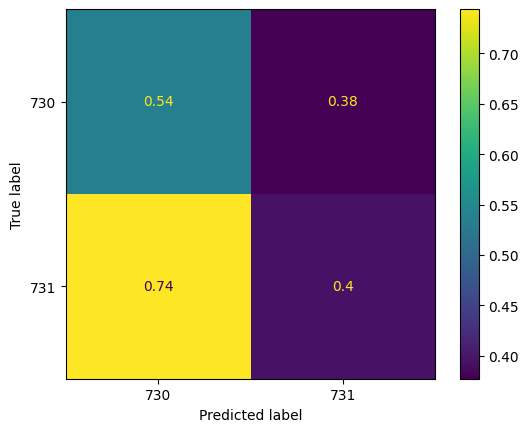

Accuracy: 0.5565756747627967
Accuracy 730: 0.5995361262399305
Accuracy 731: 0.5145915971828705
Integrated:  97701  percentual:  1.0 %


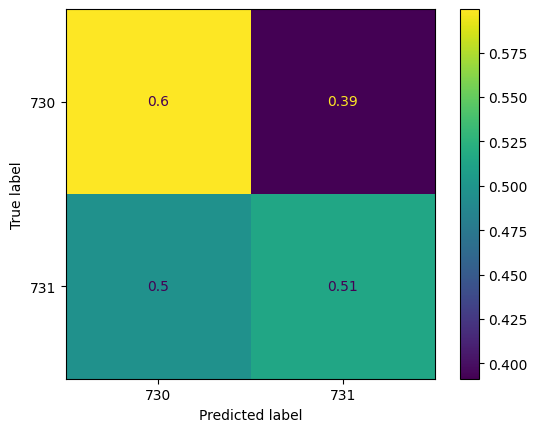

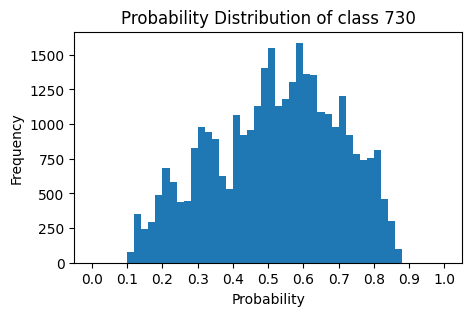

/home/paolo/cvsa_ws/record/monitor/h7/20240923/calibration/two_classifier/classifier/sustained/cl_sus16.yaml
Train set: (65134, 17) (65134,)
Test set: (32567, 17) (32567,)
Best parameters found:  {'priors': None, 'reg_param': 0.5}
Best score found:  0.599597332076168
Accuracy train: 0.6219025393803543
Accuracy test:  0.4581324653790647
Accuracy all:   0.5673125147132578
Accuracy: 0.6219025393803543
Accuracy 730: 0.6507569011576135
Accuracy 731: 0.5909871517618623
Integrated:  65134  percentual:  1.0 %


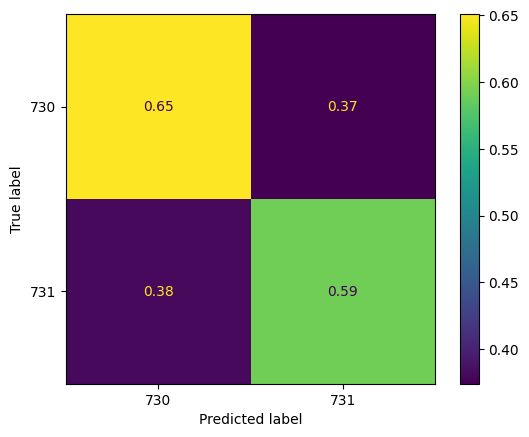

Accuracy: 0.4581324653790647
Accuracy 730: 0.5464757860127406
Accuracy 731: 0.38635351736420304
Integrated:  32567  percentual:  1.0 %


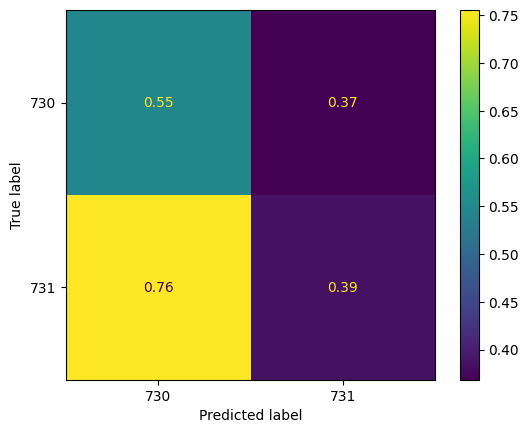

Accuracy: 0.5673125147132578
Accuracy 730: 0.6192300523928845
Accuracy 731: 0.5165749210718045
Integrated:  97701  percentual:  1.0 %


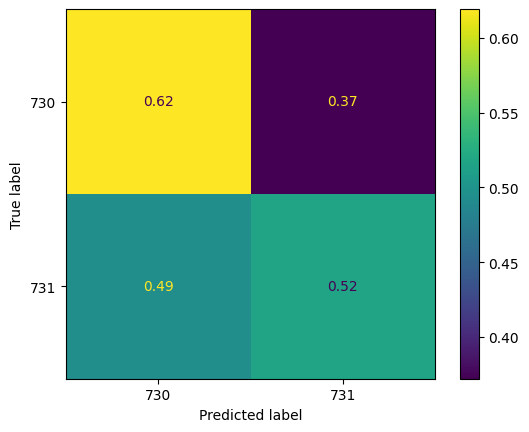

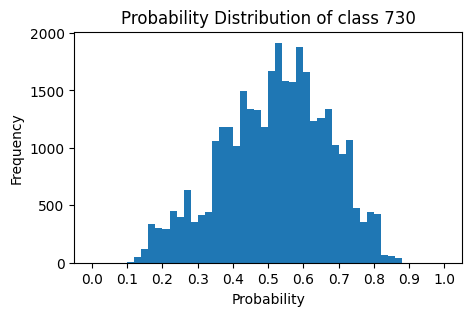

/home/paolo/cvsa_ws/record/monitor/h7/20240923/calibration/two_classifier/classifier/sustained/cl_sus17.yaml
Train set: (65134, 18) (65134,)
Test set: (32567, 18) (32567,)
Best parameters found:  {'priors': [0.5, 0.5], 'reg_param': 1.0}
Best score found:  0.6006411726741083
Accuracy train: 0.5994718580157828
Accuracy test:  0.4818681487395216
Accuracy all:   0.5602706215903624
Accuracy: 0.5994718580157828
Accuracy 730: 0.6213713268032057
Accuracy 731: 0.5760081414578297
Integrated:  65134  percentual:  1.0 %


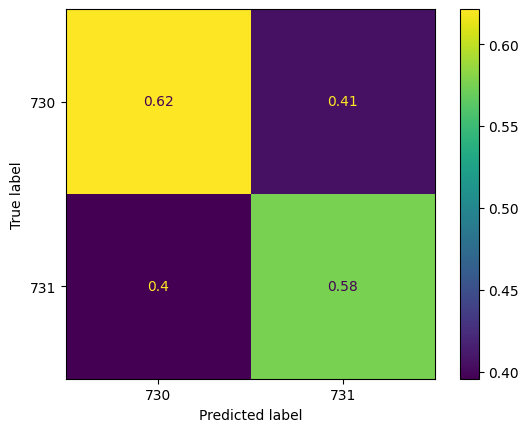

Accuracy: 0.4818681487395216
Accuracy 730: 0.5677786149736284
Accuracy 731: 0.4120658949243099
Integrated:  32567  percentual:  1.0 %


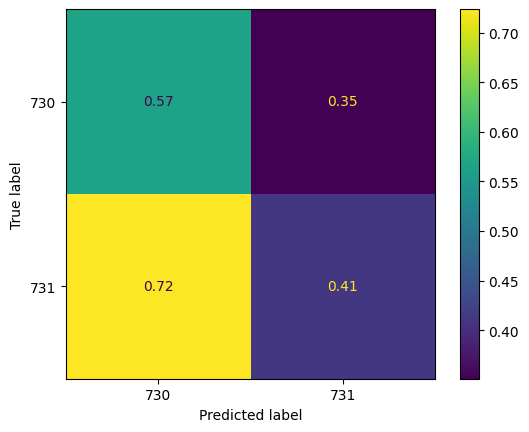

Accuracy: 0.5602706215903624
Accuracy 730: 0.6051688790407753
Accuracy 731: 0.5163927790820043
Integrated:  97701  percentual:  1.0 %


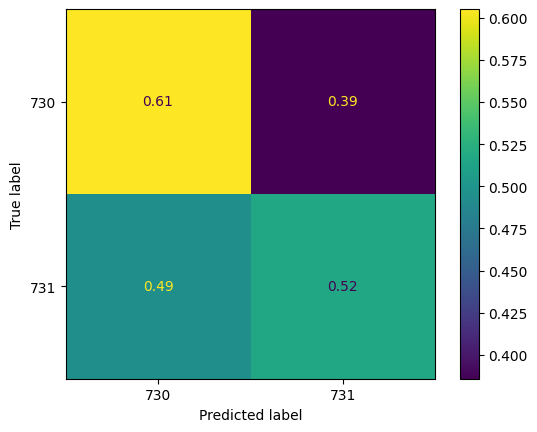

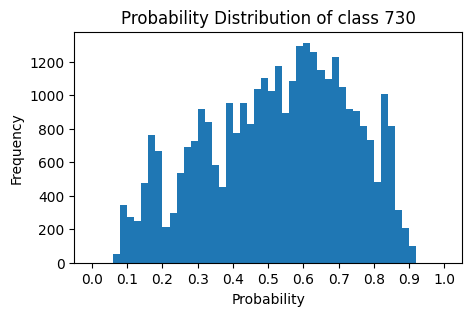

/home/paolo/cvsa_ws/record/monitor/h7/20240923/calibration/two_classifier/classifier/sustained/cl_sus18.yaml
Train set: (65134, 19) (65134,)
Test set: (32567, 19) (32567,)
Best parameters found:  {'priors': [0.5, 0.5], 'reg_param': 1.0}
Best score found:  0.6024527192581197
Accuracy train: 0.5979519145146928
Accuracy test:  0.4724414284398317
Accuracy all:   0.5561150858230725
Accuracy: 0.5979519145146928
Accuracy 730: 0.6216384683882458
Accuracy 731: 0.572573463935886
Integrated:  65134  percentual:  1.0 %


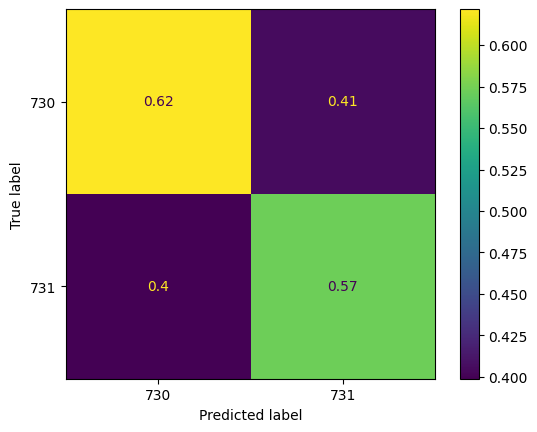

Accuracy: 0.4724414284398317
Accuracy 730: 0.5447633399547914
Accuracy 731: 0.41367987533392697
Integrated:  32567  percentual:  1.0 %


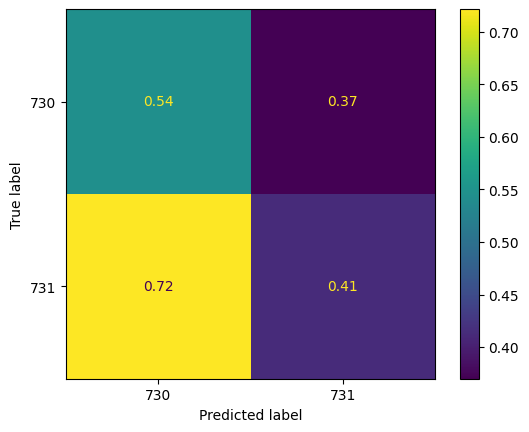

Accuracy: 0.5561150858230725
Accuracy 730: 0.5983971504897596
Accuracy 731: 0.5147939771715373
Integrated:  97701  percentual:  1.0 %


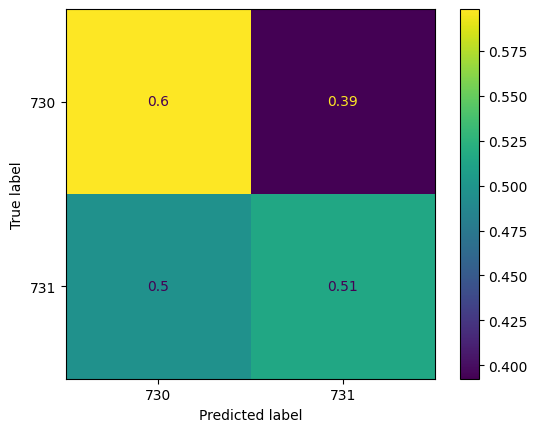

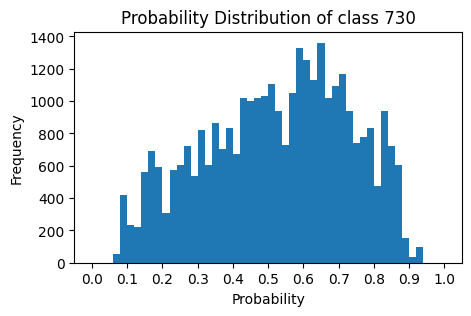

/home/paolo/cvsa_ws/record/monitor/h7/20240923/calibration/two_classifier/classifier/sustained/cl_sus19.yaml
Train set: (65134, 20) (65134,)
Test set: (32567, 20) (32567,)
Best parameters found:  {'priors': [0.5, 0.5], 'reg_param': 1.0}
Best score found:  0.6012398725292121
Accuracy train: 0.5981822089845549
Accuracy test:  0.4751435502195474
Accuracy all:   0.5571693227295524
Accuracy: 0.5981822089845549
Accuracy 730: 0.6214603739982191
Accuracy 731: 0.5732413178984862
Integrated:  65134  percentual:  1.0 %


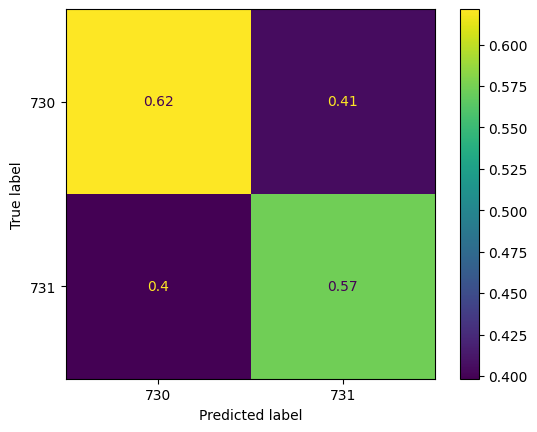

Accuracy: 0.4751435502195474
Accuracy 730: 0.5484622234399616
Accuracy 731: 0.4155721282279608
Integrated:  32567  percentual:  1.0 %


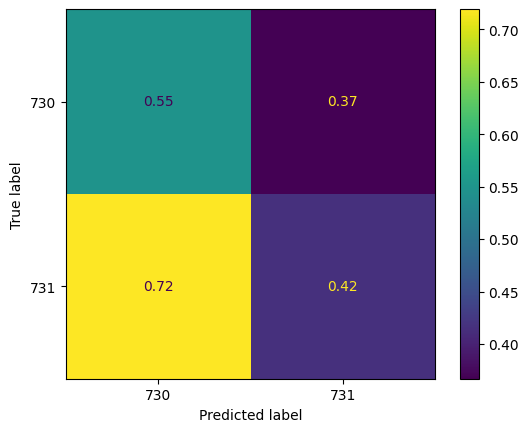

Accuracy: 0.5571693227295524
Accuracy 730: 0.5993911656899087
Accuracy 731: 0.5159070671092042
Integrated:  97701  percentual:  1.0 %


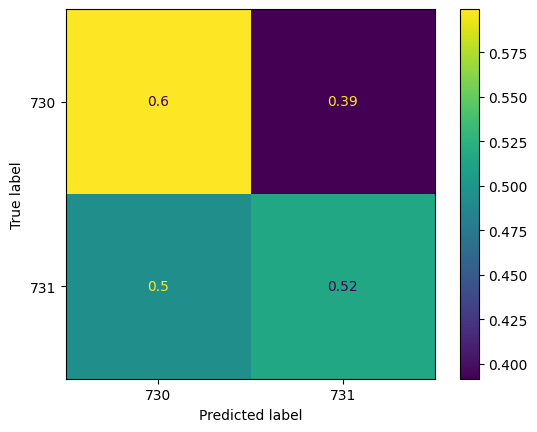

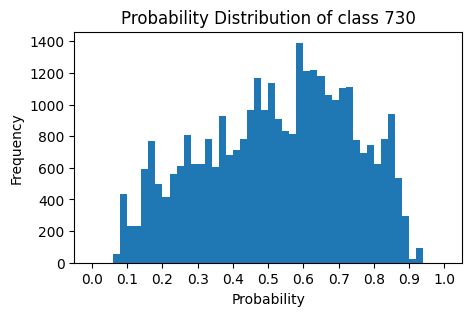

/home/paolo/cvsa_ws/record/monitor/h7/20240923/calibration/two_classifier/classifier/sustained/cl_sus20.yaml
Train set: (65134, 21) (65134,)
Test set: (32567, 21) (32567,)
Best parameters found:  {'priors': [0.5, 0.5], 'reg_param': 1.0}
Best score found:  0.5943310219261273
Accuracy train: 0.5922559646267694
Accuracy test:  0.4787975558080265
Accuracy all:   0.5544364950205218
Accuracy: 0.5922559646267694
Accuracy 730: 0.6155535767289997
Accuracy 731: 0.5672942373743799
Integrated:  65134  percentual:  1.0 %


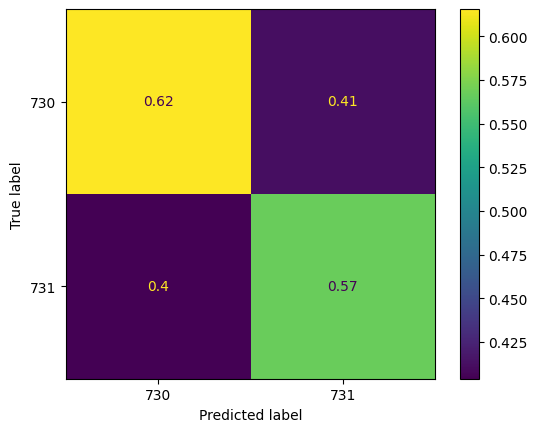

Accuracy: 0.4787975558080265
Accuracy 730: 0.5640112336461401
Accuracy 731: 0.40956144256455923
Integrated:  32567  percentual:  1.0 %


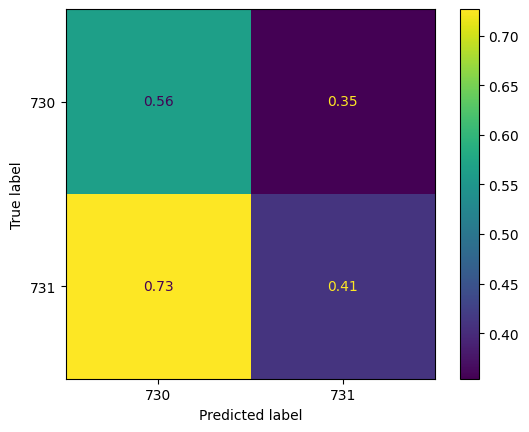

Accuracy: 0.5544364950205218
Accuracy 730: 0.5999710078899957
Accuracy 731: 0.509936857443536
Integrated:  97701  percentual:  1.0 %


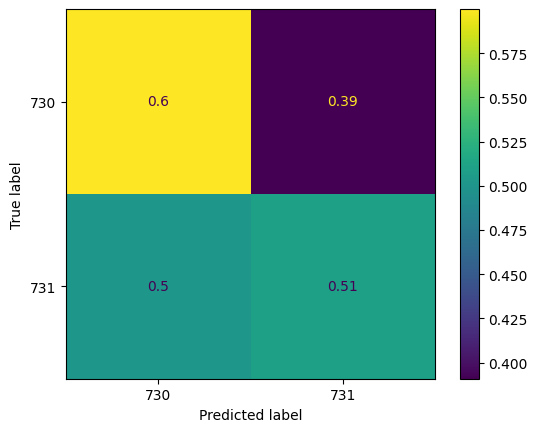

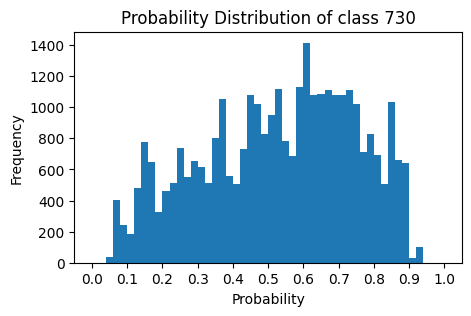

/home/paolo/cvsa_ws/record/monitor/h7/20240923/calibration/two_classifier/classifier/sustained/cl_sus21.yaml
Train set: (65134, 22) (65134,)
Test set: (32567, 22) (32567,)
Best parameters found:  {'priors': None, 'reg_param': 1.0}
Best score found:  0.5927802984768045
Accuracy train: 0.5902600792212976
Accuracy test:  0.4838026222863635
Accuracy all:   0.5547742602429863
Accuracy: 0.5902600792212976
Accuracy 730: 0.6356782428020185
Accuracy 731: 0.5415977610990969
Integrated:  65134  percentual:  1.0 %


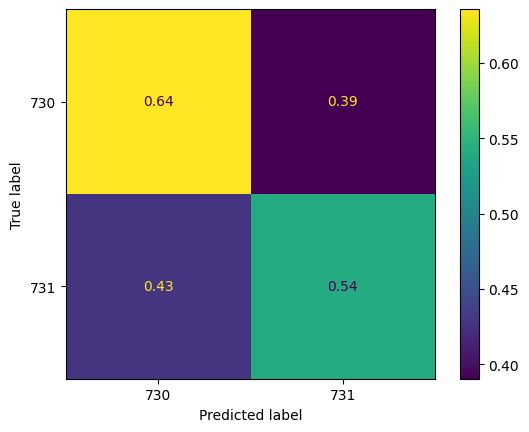

Accuracy: 0.4838026222863635
Accuracy 730: 0.5927118295773683
Accuracy 731: 0.39531389136242207
Integrated:  32567  percentual:  1.0 %


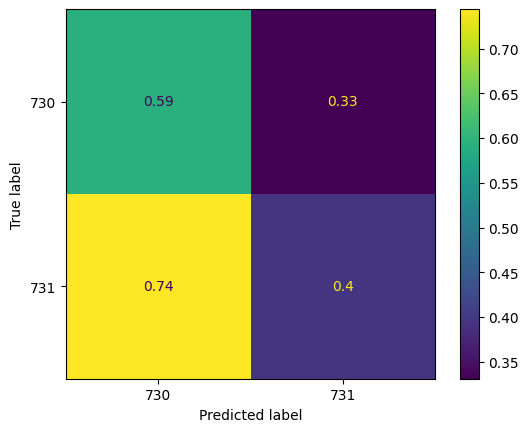

Accuracy: 0.5547742602429863
Accuracy 730: 0.6226883969434033
Accuracy 731: 0.4884036266493969
Integrated:  97701  percentual:  1.0 %


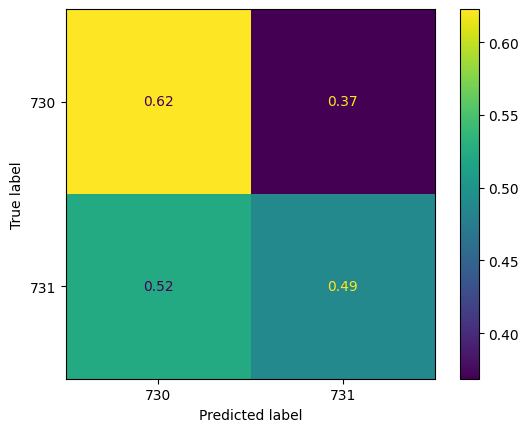

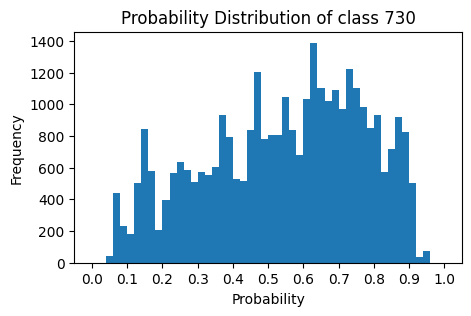

/home/paolo/cvsa_ws/record/monitor/h7/20240923/calibration/two_classifier/classifier/sustained/cl_sus22.yaml
Train set: (65134, 23) (65134,)
Test set: (32567, 23) (32567,)
Best parameters found:  {'priors': None, 'reg_param': 0.5}
Best score found:  0.598506681330609
Accuracy train: 0.632972026898394
Accuracy test:  0.4863512144195044
Accuracy all:   0.5840984227387642
Accuracy: 0.632972026898394
Accuracy 730: 0.6467497773820124
Accuracy 731: 0.6182101513802315
Integrated:  65134  percentual:  1.0 %


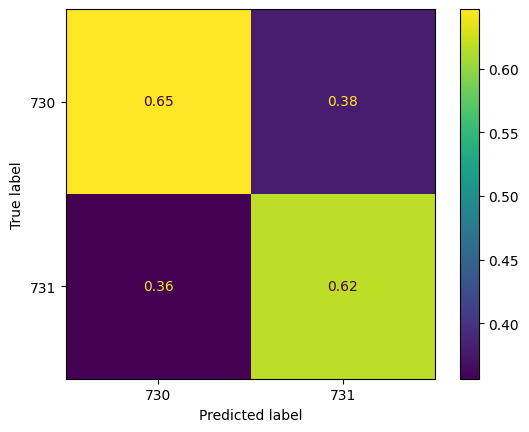

Accuracy: 0.4863512144195044
Accuracy 730: 0.5439413658469758
Accuracy 731: 0.43955921638468387
Integrated:  32567  percentual:  1.0 %


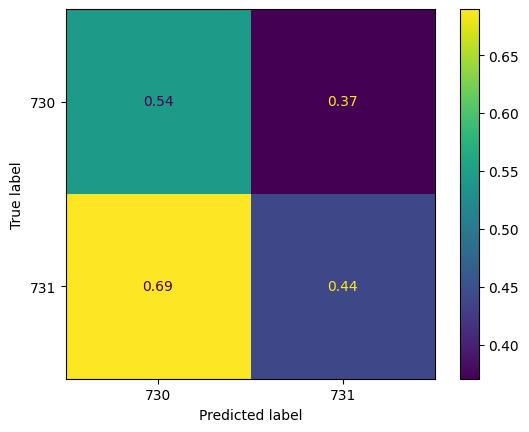

Accuracy: 0.5840984227387642
Accuracy 730: 0.6156681645923502
Accuracy 731: 0.5532461750182142
Integrated:  97701  percentual:  1.0 %


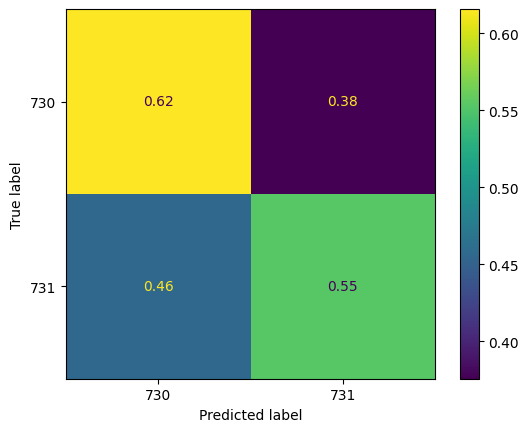

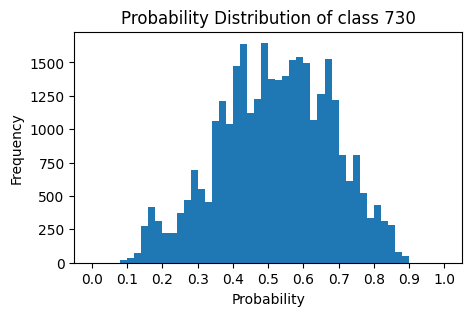

/home/paolo/cvsa_ws/record/monitor/h7/20240923/calibration/two_classifier/classifier/sustained/cl_sus23.yaml
Train set: (65134, 24) (65134,)
Test set: (32567, 24) (32567,)
Best parameters found:  {'priors': None, 'reg_param': 0.5}
Best score found:  0.5965108018163647
Accuracy train: 0.6328492031811342
Accuracy test:  0.4856756839745755
Accuracy all:   0.5837913634456147
Accuracy: 0.6328492031811342
Accuracy 730: 0.6467497773820124
Accuracy 731: 0.6179557308230506
Integrated:  65134  percentual:  1.0 %


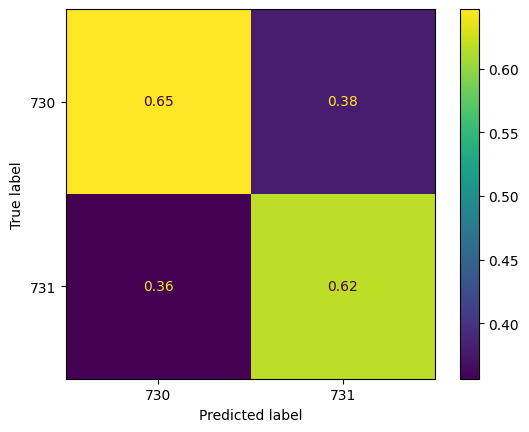

Accuracy: 0.4856756839745755
Accuracy 730: 0.5429823960545243
Accuracy 731: 0.4391139804096171
Integrated:  32567  percentual:  1.0 %


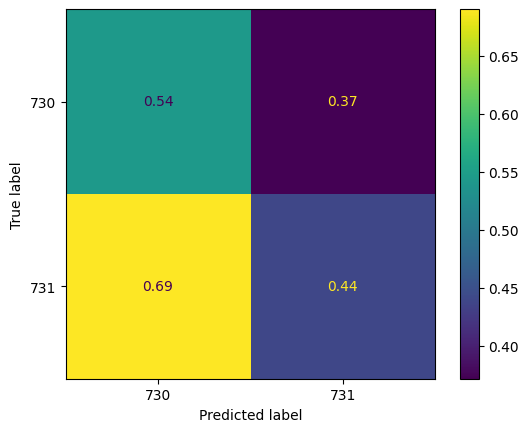

Accuracy: 0.5837913634456147
Accuracy 730: 0.6153782434923067
Accuracy 731: 0.5529223670363475
Integrated:  97701  percentual:  1.0 %


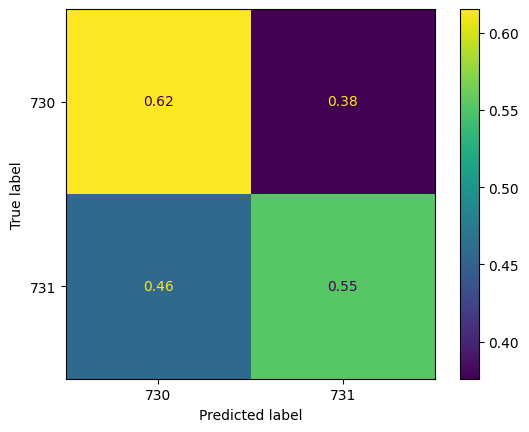

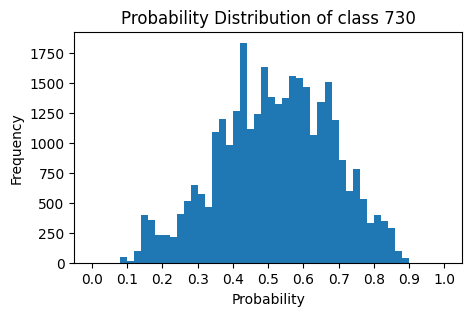

/home/paolo/cvsa_ws/record/monitor/h7/20240923/calibration/two_classifier/classifier/sustained/cl_sus24.yaml
Train set: (65134, 25) (65134,)
Test set: (32567, 25) (32567,)
Best parameters found:  {'priors': None, 'reg_param': 0.5}
Best score found:  0.5952365665654831
Accuracy train: 0.6342002640709921
Accuracy test:  0.485337918752111
Accuracy all:   0.5845794822980318
Accuracy: 0.6342002640709921
Accuracy 730: 0.6444345503116652
Accuracy 731: 0.6232349573845567
Integrated:  65134  percentual:  1.0 %


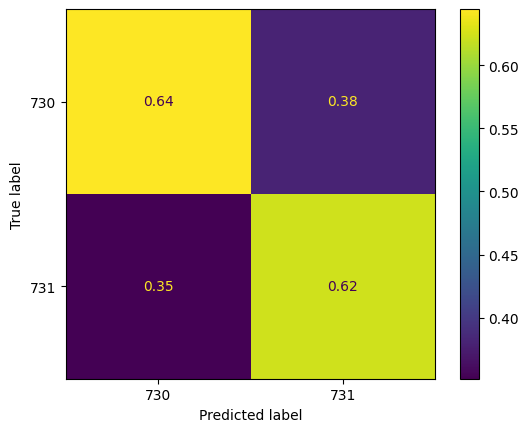

Accuracy: 0.485337918752111
Accuracy 730: 0.5405164737310775
Accuracy 731: 0.4405053428317008
Integrated:  32567  percentual:  1.0 %


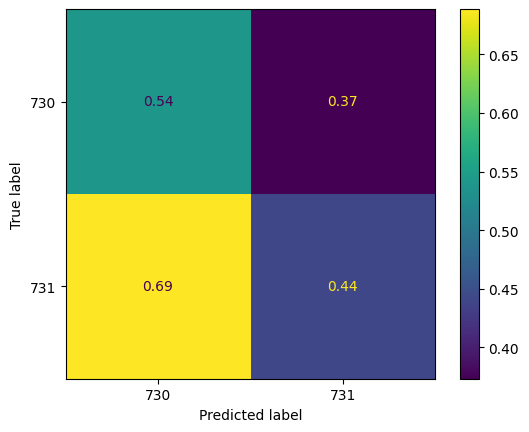

Accuracy: 0.5845794822980318
Accuracy 730: 0.6130174573919526
Accuracy 731: 0.5567878248198818
Integrated:  97701  percentual:  1.0 %


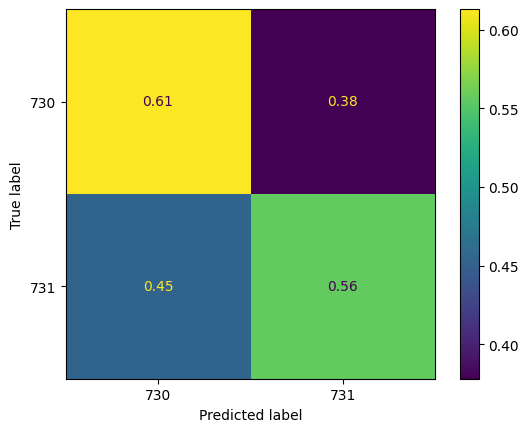

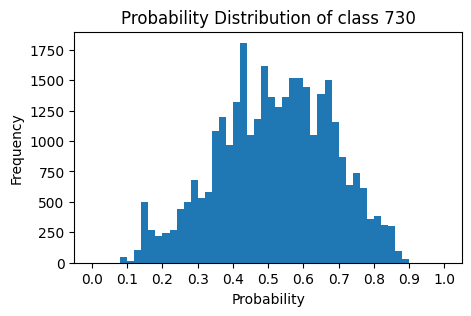

/home/paolo/cvsa_ws/record/monitor/h7/20240923/calibration/two_classifier/classifier/sustained/cl_sus25.yaml
Train set: (65134, 26) (65134,)
Test set: (32567, 26) (32567,)
Best parameters found:  {'priors': None, 'reg_param': 0.5}
Best score found:  0.5948065428272129
Accuracy train: 0.6420609819756194
Accuracy test:  0.4809469708600731
Accuracy all:   0.5883563116037707
Accuracy: 0.6420609819756194
Accuracy 730: 0.6422380528346691
Accuracy 731: 0.6418712631980664
Integrated:  65134  percentual:  1.0 %


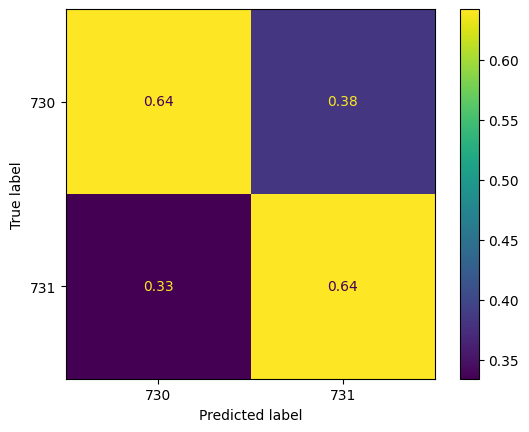

Accuracy: 0.4809469708600731
Accuracy 730: 0.5358586204534557
Accuracy 731: 0.4363312555654497
Integrated:  32567  percentual:  1.0 %


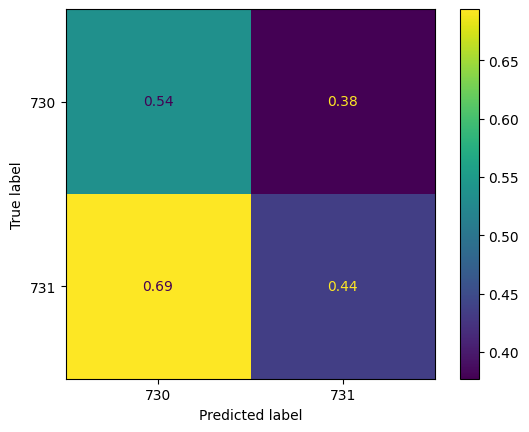

Accuracy: 0.5883563116037707
Accuracy 730: 0.6100768290915115
Accuracy 731: 0.5671294422407512
Integrated:  97701  percentual:  1.0 %


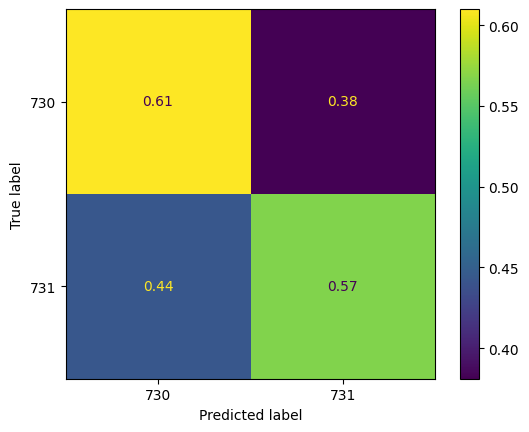

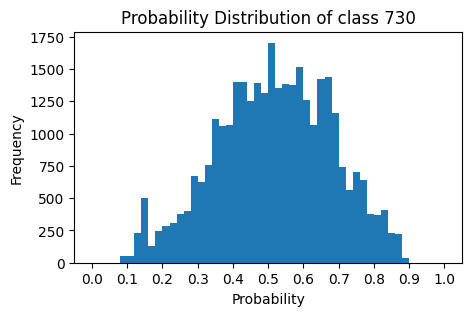

/home/paolo/cvsa_ws/record/monitor/h7/20240923/calibration/two_classifier/classifier/sustained/cl_sus26.yaml
Train set: (65134, 27) (65134,)
Test set: (32567, 27) (32567,)
Best parameters found:  {'priors': None, 'reg_param': 0.5}
Best score found:  0.5958351108424952
Accuracy train: 0.6437191021586268
Accuracy test:  0.480977676789388
Accuracy all:   0.5894719603688806
Accuracy: 0.6437191021586268
Accuracy 730: 0.6413178984861977
Accuracy 731: 0.6462918203790866
Integrated:  65134  percentual:  1.0 %


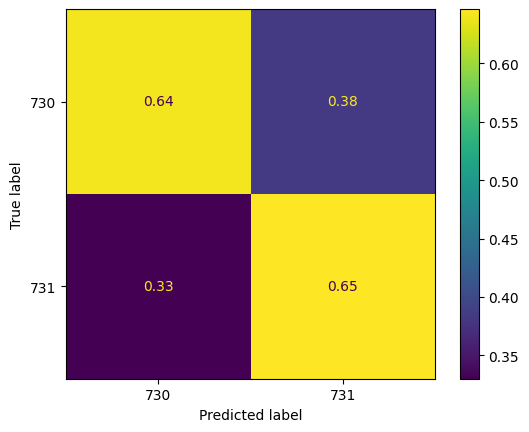

Accuracy: 0.480977676789388
Accuracy 730: 0.5364751010343174
Accuracy 731: 0.4358860195903829
Integrated:  32567  percentual:  1.0 %


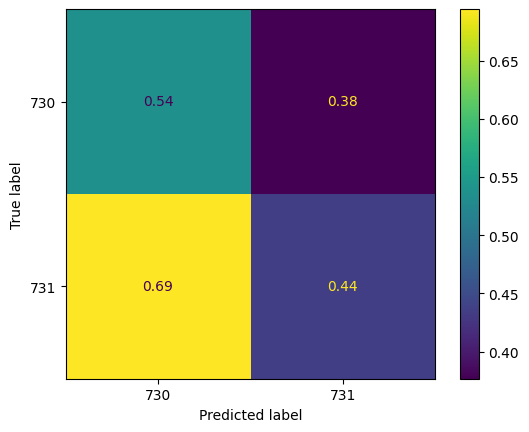

Accuracy: 0.5894719603688806
Accuracy 730: 0.6096212387914431
Accuracy 731: 0.5697806200922853
Integrated:  97701  percentual:  1.0 %


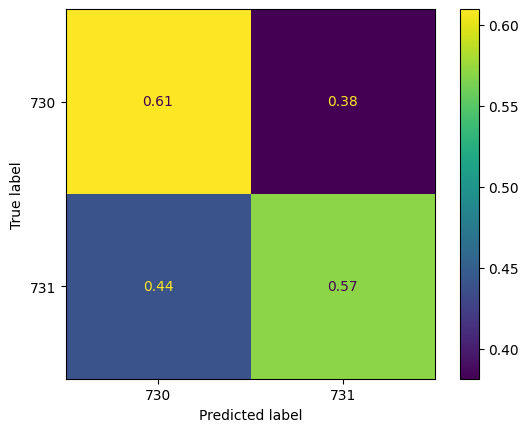

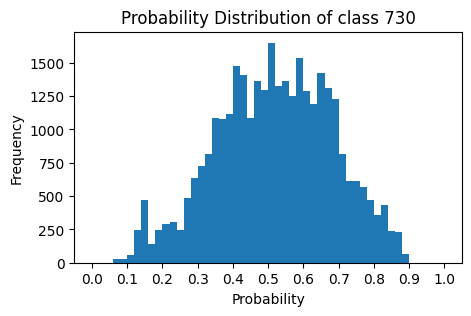

/home/paolo/cvsa_ws/record/monitor/h7/20240923/calibration/two_classifier/classifier/sustained/cl_sus27.yaml


In [ ]:
for idx_dataset in range(1, max_dataset+1):
    path = '/home/paolo/cvsa_ws/record/' + subject + '/' + day + '/calibration/two_classifier/dataset/sustained/sus_data' + str(idx_dataset) +'.mat' 
    data = loadmat(path)

    X = fix_mat(data['X'])
    y = fix_mat(data['y']).ravel()
    info = fix_mat(data['info'])

    if 'logband' in path:
        type_ = 'logbandpower'
    else:
        type_ = 'psd'
        

    # start using last n-1 trials as test set
    n = int(info['nTest'])
    start_test = info['startTrial'][-n] - 1

    X_train = X[:start_test,:]
    y_train = y[:start_test].ravel()
    X_test = X[start_test:,:]
    y_test = y[start_test:].ravel()

    print('Train set:', X_train.shape, y_train.shape)
    print('Test set:', X_test.shape, y_test.shape)
    
    param_grid = {'reg_param': [0.0, 0.1, 0.5, 1.0], 'priors': [None, [0.5, 0.5]]}

    #grid_search = GridSearchCV(estimator=QuadraticDiscriminantAnalysis(), param_grid=param_grid, cv=5, n_jobs=-1, verbose=3).fit(X_train, y_train)
    grid_search = GridSearchCV(estimator=QuadraticDiscriminantAnalysis(), param_grid=param_grid, cv=5, n_jobs=-1).fit(X_train, y_train)

    #print("Results: ", grid_search.cv_results_)
    print("Best parameters found: ", grid_search.best_params_)
    print("Best score found: ", grid_search.best_score_)

    model_qda = QuadraticDiscriminantAnalysis(reg_param=grid_search.best_params_['reg_param'], store_covariance=True, priors=grid_search.best_params_['priors'])
    model_qda.fit(X_train, y_train)

    print(f'Accuracy train: {model_qda.score(X_train, y_train)}')
    print(f'Accuracy test:  {model_qda.score(X_test, y_test)}')
    print(f'Accuracy all:   {model_qda.score(X, y)}')


    ths_rej = [0.5, 0.5]
    bins_step = 0.02

    print_cm_rej(model_qda, X_train, y_train, ths_rej, 'train set',  ['730', '731'])
    print_cm_rej(model_qda, X_test,  y_test,  ths_rej, 'test set',  ['730', '731'])
    print_cm_rej(model_qda, X,  y,  ths_rej, 'all dataset',  ['730', '731'])

    histo_prediction(X_test, model_qda, bins_step, classes=['730', '731'])
    
    features_label = []
    if type(info['chSelected'].tolist()) == int:
        features_label.append(str(info['channelsLabel'][info['chSelected'].tolist() - 1][0]))
    else:
        for i in range(0, len(info['chSelected'].tolist())):
            features_label.append(str(info['channelsLabel'][info['chSelected'][i] - 1][0]))

    files = []
    for i in range(0, len(info['files'])):
        str_file = info['files'][i][0]
        files.append(str(str_file))
        
    band = info['bandSelected'].tolist()
    id_ch = info['chSelected'].tolist()

    model_params = {
        'QdaCfg': {
            'name': "qda",
            'params': {
                'subject': subject,
                'filename': 'qda',
                'filename_dataset': path,
                'files': files,
                'type_data': type_,
                'nclasses': int(len(model_qda.classes_)),
                'classlbs': model_qda.classes_.tolist(),
                'nfeatures': int(model_qda.n_features_in_),
                'chans': features_label,
                'idchans': id_ch, 
                'note': 'idchans are saved in matlab convention, instead the names are correct',
                'sampleRate': int(info['sampleRate']),
                'band': band,
                'filterOrder': int(info['filterOrder']),
                'priors': model_qda.priors_.tolist(),
                'means': model_qda.means_.tolist(),
                'covs': [arr.tolist() for arr in model_qda.covariance_],
                'rotations': [arr.tolist() for arr in model_qda.rotations_],
                'scalings': [arr.tolist() for arr in model_qda.scalings_]
            }
        }
    }

    # Save parameters to a YAML file
    c_dir = os.getcwd()
    c_prev = os.path.abspath(os.path.join(c_dir, os.pardir))
    path2save = c_prev[0:20] + 'record/' + subject + '/' + day + '/calibration/two_classifier/classifier/sustained/cl_sus' + str(idx_dataset) + '.yaml'

    yaml = YAML()
    with open(path2save, 'w') as file:
        yaml.dump(model_params, file)
        
    print(path2save)
